#### Imports

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import numpy as np

import matplotlib.pyplot as plt
import proplot as pplt
import pickle
import copy
import scipy.stats
from scipy.optimize import curve_fit
from erbium_analysis_modules.dtwa_module import DTWAModule
from scipy.interpolate import interp2d
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from scipy.interpolate import CloughTocher2DInterpolator, CubicSpline

2025-06-08 18:59:03.673989: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Global Constants

In [2]:
DTWA_DIR = "dtwa"
DEFAULT_DTWA_NSHOTS = 10 # Number of samples from the experimental filling distribution when doing DTWA
MIN_FILL_FRAC = 0.1 # Get rid of sites with mean filling less than 10% of the max mean filling
N_CUTOFF = 0.25 # the shots with N in the lower and upper 12.5% of the N distribution are cut out
DTWA_SCALE_T = 0.86
TUNNELINGS = [0, 10, 50]

COLORS = ["blue7", "red7", "yellow7"]
COLORS_GRAY = "gray"

# Routines

In [3]:
def get_clips(occs):
    spinup = np.sum(occs[0], axis=(0,1))
    spindown = np.sum(occs[1], axis=(0,1))
    N = spinup + spindown
    N = N[N > np.max(N)/2]
    
    fillings = np.mean(np.sum(occs, axis=0), axis=-1)
    
    N_clip = (np.percentile(N, 100*N_CUTOFF/2), np.percentile(N, 100*(1-N_CUTOFF/2)))
    min_fill = np.max(fillings)*MIN_FILL_FRAC
    
    print("N_clip:", N_clip, " min_fill:", min_fill)
    
    return N_clip, min_fill

In [4]:
def process_occs(occs, reg_mask, sum_spindown, double="none", ratio_clip=None, no_shot_mask=False):
    # Combine 3 images into 2 spin states
    occs = np.stack([
        occs[0], (occs[1].astype(int) + occs[2].astype(int)) if sum_spindown else (occs[1] | occs[2])
    ], axis=0).astype(int)
    
    # Handle 0+1 imaging errors
    double_occ = (occs[0].astype(bool) & occs[1].astype(bool))
    if double == "up":
        occs[1] *= (~double_occ)
    elif double == "down":
        occs[0] *= ~(double_occ)
    
    Nclip, min_fill = get_clips(occs)
    
    # Filter out shots with bad total atom number and bad spin ratio
    spinup = np.sum(occs[0], axis=(0,1))
    spindown = np.sum(occs[1], axis=(0,1))
    N = spinup + spindown

    if not no_shot_mask:
        shot_mask = (N > Nclip[0]) & (N < Nclip[1])
        if ratio_clip is not None:
            ratio = (spinup - spindown)/N
            shot_mask = shot_mask & (ratio > ratio_clip[0]) & (ratio < ratio_clip[1])
        
        occs = occs[:,:,:,shot_mask]
    else:
        shot_mask = np.ones(occs.shape[-1], dtype=bool)
    
    occs_all_sites = occs
    
    # Filter out low filling sites
    mean_occs = np.mean(np.sum(occs, axis=0), axis=-1)
    site_mask = reg_mask & (mean_occs >= min_fill)
    occs = occs*np.expand_dims(np.expand_dims(site_mask, 0), -1)
    
    return occs, shot_mask, occs_all_sites, site_mask

In [5]:
def analyze_diff(directory, scan_index, sum_spindown=True,
                 reg_cutoffs=(0, 12), shot_clip=(None, None),
                 reg_slope=0.75, double="none", ratio_clip=None, transpose=False,
                 maxr=69, maxc=69, dtwaprefix=None, dtwanshots=DEFAULT_DTWA_NSHOTS,
                 dtwatunnelfreq=0, dtwaharmonic=None, dtwapulses=[]):
    
    if not isinstance(scan_index, list):
        scan_index = [scan_index]
    
    occs = None
    variable_values_raw = None
    units_raw = None
    for idx in scan_index:
        data = pickle.load(open(os.path.join(directory, str(idx) + ".pickle"), "rb"))
        if occs is None:
            occs = data["occs"][:,:maxr,:maxc,:]
        else:
            occs = np.concatenate([occs, data["occs"][:,:maxr,:maxc,:]], axis=-1)
        if variable_values_raw is None:
            variable_values_raw = data["variable_values"]
        else:
            for k in variable_values_raw.keys():
                variable_values_raw[k] = np.concatenate([variable_values_raw[k], data["variable_values"][k]])
        if units_raw is None:
            units_raw = data["units"]
    
    # Combine 3 images into 2 spin states
    occs = np.stack([
        occs[0], (occs[1].astype(int) + occs[2].astype(int)) if sum_spindown else (occs[1] | occs[2])
    ], axis=0).astype(int)
    if transpose:
        occs = np.transpose(occs, (0, 2, 1, 3))
    
    # Filter out bad shots
    occs = occs[:,:,:,shot_clip[0]:shot_clip[1]]
    
    # Handle 0+1 imaging errors
    double_occ = (occs[0].astype(bool) & occs[1].astype(bool))
    if double == "up":
        occs[1] *= (~double_occ)
    elif double == "down":
        occs[0] *= ~(double_occ)
    
    Nclip, min_fill = get_clips(occs)
    
    # Filter out shots with bad total atom number and bad spin ratio
    spinup = np.sum(occs[0], axis=(0,1))
    spindown = np.sum(occs[1], axis=(0,1))
    N = spinup + spindown
    ratio = (spinup - spindown)/N
    shot_mask = (N > Nclip[0]) & (N < Nclip[1])
    if ratio_clip is not None:
        shot_mask = shot_mask & (ratio > ratio_clip[0]) & (ratio < ratio_clip[1])

    all_N = np.sum(occs, axis=(0, 1, 2))
    
    occs = occs[:,:,:,shot_mask]
        
    occs_all_sites = occs
    
    # Filter out low filling sites
    mean_occs = np.mean(np.sum(occs, axis=0), axis=-1)
    site_mask = mean_occs >= min_fill
    occs = occs*np.expand_dims(np.expand_dims(site_mask, 0), -1)
    
    variable_values = {}
    for k in variable_values_raw.keys():
        variable_values[k] = np.array(variable_values_raw[k])[shot_clip[0]:shot_clip[1]][shot_mask]
    
    out = []
    masks = []
    
    maska = np.ones(occs.shape[1:3], dtype=bool)
    maska[reg_cutoffs[0] + reg_slope * np.indices(maska.shape)[0] < np.indices(maska.shape)[1]] = False
    masks.append(maska)
    
    maskb = np.zeros(occs.shape[1:3], dtype=bool)
    maskb[reg_cutoffs[1] + reg_slope * np.indices(maskb.shape)[0] < np.indices(maskb.shape)[1]] = True
    masks.append(maskb)
        
    for mask in masks:
        occs_m = occs * np.expand_dims(np.expand_dims(mask, 0), -1)
        
        dN = occs_m[0] - occs_m[1]
        
        spinup = np.sum(occs_m[0], axis=(0,1))
        spindown = np.sum(occs_m[1], axis=(0,1))
        N = spinup + spindown
        dspin = spinup - spindown
        ratio = dspin/N
        p = spinup/N
        qpn = 4*N*p*(1-p)
        xi_meanN = dspin/np.sqrt(np.mean(qpn))
        xi = dspin/np.sqrt(qpn)

        out.append({
            "mask": mask*site_mask,
            "ratio": ratio,
            "occs": occs_m,
            "occs_all_sites": occs_all_sites,
            "N": N,
            "dN": dN,
            "all_N": all_N,
            "Nclip": Nclip,
            "min_fill": min_fill,
            "dspin": dspin,
            "xi": xi,
            "xi_meanN": xi_meanN,
            "variable_values": variable_values,
            "units": copy.deepcopy(units_raw)
        })

        fig, ax = pplt.subplots([1,2], share=False)
        ax[0].plot(N)
        c = ax[1].imshow(np.sum(np.mean(occs_m, axis=-1), axis=0), vmin=0, vmax=1)
        ax[1].colorbar(c)

    if dtwaprefix is not None:
        sim_all_sites = np.sum(occs_all_sites, axis=0)
        #sim_all_sites[~(maska | maskb)] = 0
        plt.figure()
        plt.imshow(np.mean(sim_all_sites, axis=-1))
        disorder = None
        if dtwaharmonic is not None:
            idxs = np.indices(sim_all_sites.shape[:-1])
            center = np.mean(idxs, axis=(1,2))
            print("center:", center)
            disorder = dtwaharmonic*np.linalg.norm(idxs - np.reshape(center, (2,1,1)), axis=0)**2
            plt.figure()
            c = plt.imshow(disorder)
            plt.colorbar(c)
        dtwa = DTWAModule(sim_all_sites,
                           analysis_mask=out[0]["mask"], diff_mask=out[1]["mask"],
                           savedir=DTWA_DIR, saveprefix=dtwaprefix,
                           nshots=dtwanshots, tsteps=1000, endt=0.6, tunnel_freq=dtwatunnelfreq,
                           tunnel_type="metropolis-hastings", disorder=disorder, pulses=dtwapulses)
        dtwa.simulate()
        sim_ts, sim_phis, sim_cs, sim_xi2s, sim_Ns = dtwa.analyze(retdata=True, nphipoints=900)

        sim_xi2rs = sim_xi2s/np.expand_dims(sim_cs**2, axis=-1)
        
        out_dtwa = {
            "ts": sim_ts/DTWA_SCALE_T,
            "phis": sim_phis,
            "cs": np.mean(sim_cs, axis=0),
            "cs_std": scipy.stats.sem(sim_cs, axis=0, ddof=1),
            "xi2s": np.mean(sim_xi2s, axis=0),
            "xi2s_std": scipy.stats.sem(sim_xi2s, axis=0, ddof=1),
            "xi2rs": np.mean(sim_xi2rs, axis=0),
            "xi2rs_std": scipy.stats.sem(sim_xi2rs, axis=0, ddof=1)
        }
        for i in range(2):
            out[i]["dtwa"] = out_dtwa

    fig, ax = pplt.subplots([1,2], share=False)
    ax[0].plot(N)
    c = ax[1].imshow(np.sum(np.mean(occs_all_sites, axis=-1), axis=0), vmin=0, vmax=1)
    ax[1].colorbar(c)
    
    return out

In [6]:
def analyze(directory, scan_index, sum_spindown=True, double="none", 
            ratio_clip=None, maxr=69, maxc=69, shot_clip=(None, None), dtwaprefix=None, 
            dtwanshots=DEFAULT_DTWA_NSHOTS, dtwaendt=0.6, dtwatunnelfreq=0, no_shot_mask=False,
           dtwaharmonic=None, dtwapulses=[], dtwaavgJs=False):
    if not isinstance(scan_index, list):
        scan_index = [scan_index]
    
    occs_raw = None
    variable_values_raw = None
    units_raw = None
    for idx in scan_index:
        data = pickle.load(open(os.path.join(directory, str(idx) + ".pickle"), "rb"))
        if occs_raw is None:
            occs_raw = data["occs"][:,:maxr,:maxc,:]
        else:
            occs_raw = np.concatenate([occs_raw, data["occs"][:,:maxr,:maxc,:]], axis=-1)
        if variable_values_raw is None:
            variable_values_raw = data["variable_values"]
        else:
            for k in variable_values_raw.keys():
                variable_values_raw[k] = np.concatenate([variable_values_raw[k], data["variable_values"][k]])
        if units_raw is None:
            units_raw = data["units"]
    
    # Filter out bad shots
    occs_raw = occs_raw[:,:,:,shot_clip[0]:shot_clip[1]]
    for k in variable_values_raw.keys():
        variable_values_raw[k] = variable_values_raw[k][shot_clip[0]:shot_clip[1]]
    
    occs, shot_mask, occs_all_sites, site_mask = process_occs(occs_raw, np.ones(occs_raw.shape[1:3], dtype=bool), sum_spindown=sum_spindown, 
                                                              ratio_clip=ratio_clip, double=double, no_shot_mask=no_shot_mask)

    print("<N>:", np.sum(occs_raw[:,:,:,shot_mask])/(occs_raw[:,:,:,shot_mask].shape[-1]))
    
    dN = occs[0] - occs[1]
    
    spinup = np.sum(occs[0], axis=(0,1))
    spindown = np.sum(occs[1], axis=(0,1))
    N = spinup + spindown
    dspin = spinup - spindown
    ratio = dspin/N
    xi_meanN = dspin/np.sqrt(np.mean(N))
    xi = dspin/np.sqrt(N)

    variable_values = {}
    for k in variable_values_raw.keys():
        variable_values[k] = np.array(variable_values_raw[k])[shot_mask]

    out = {
        "ratio": ratio,
        "occs": occs,
        "occs_all_sites": occs_all_sites,
        "mask": site_mask,
        "N": N,
        "dspin": dspin,
        "dN": dN,
        "xi": xi,
        "xi_meanN": xi_meanN,
        "variable_values": variable_values,
        "units": copy.deepcopy(units_raw)
    }
    
    if dtwaprefix is not None:
        disorder = None
        if dtwaharmonic is not None:
            idxs = np.indices(occs_all_sites.shape[1:-1])
            center = np.mean(idxs, axis=(1,2))
            print("center:", center)
            disorder = dtwaharmonic*np.linalg.norm(idxs - np.reshape(center, (2,1,1)), axis=0)**2
            plt.figure()
            c = plt.imshow(disorder)
            plt.colorbar(c)
        dtwa = DTWAModule(np.sum(occs_all_sites, axis=0),
                           analysis_mask=site_mask,
                           savedir=DTWA_DIR, saveprefix=dtwaprefix,
                           nshots=dtwanshots, tsteps=1000, endt=dtwaendt,
                           tunnel_freq=dtwatunnelfreq, tunnel_type="metropolis-hastings",
                         disorder=disorder, pulses=dtwapulses, avg_all_Js=dtwaavgJs)
        dtwa.simulate()
        sim_ts, sim_phis, sim_cs, sim_xi2s, sim_Ns = dtwa.analyze(retdata=True, nphipoints=900)

        sim_xi2rs = sim_xi2s/np.expand_dims(sim_cs**2, axis=-1)
        
        out["dtwa"] = {
            "ts": sim_ts/DTWA_SCALE_T,
            "phis": sim_phis,
            "cs": np.mean(sim_cs, axis=0),
            "cs_std": scipy.stats.sem(sim_cs, axis=0, ddof=1),
            "xi2s": np.mean(sim_xi2s, axis=0),
            "xi2s_std": scipy.stats.sem(sim_xi2s, axis=0, ddof=1),
            "xi2rs": np.mean(sim_xi2rs, axis=0),
            "xi2rs_std": scipy.stats.sem(sim_xi2rs, axis=0, ddof=1)
        }

    fig, ax = pplt.subplots([1,2], share=False)
    ax[0].plot(N)
    c = ax[1].imshow(np.sum(np.mean(occs_all_sites, axis=-1), axis=0), vmin=0, vmax=1)
    ax[1].colorbar(c)
    
    return out

In [7]:
def get_scan_stats(directory, scan_index, **kwargs):
    d = analyze(directory, scan_index, **kwargs)
    
    print("<N>:", np.mean(d["N"]), "max filling:", np.max(np.mean(np.sum(d["occs_all_sites"], axis=0), axis=-1)))

In [8]:
def sin(x, a, f, o, p):
    return a*np.sin(2*np.pi*f*x + p) + o

def sin2(x, a, o, p):
    return a*np.sin(2*np.pi*x + p) + o

In [9]:
def quad(x, x0, c, o):
    return c*(x-x0)**2 + o

def quad2(x, c, b):
    return 1 + c*x**2 + b*x

In [10]:
def exp(x, a, b):
    return a*np.exp(-x/b)

def contrast(x, a, b):
    return (a/2)*(np.exp(-x/b) + 1)

In [11]:
def var_var(s):
    return np.mean((s - np.mean(s)) ** 4)/len(s) - (np.var(s)**2*(len(s)-3))/(len(s)*(len(s) - 1))

In [12]:
def fit_squeeze_phase(x, s, a, p):
    #p = -np.pi - np.arcsin(2*(1 - s)/a - 1)
    return 0.5*(a-s)*(1 + np.sin(2*np.pi*2*rabi*x + p)) + s

def fit_squeeze(x, f, s, a, p):
    s = min(1, max(s, 0))
    a = max(a, 1)
    #p = -np.pi - np.arcsin(2*(1 - s)/a - 1)
    return 0.5*(a-s)*(1 + np.sin(2*np.pi*2*f*x + p)) + s

def fit_squeeze_nophase(x, f, s, a):
    s = min(1, max(s, 0))
    a = max(a, 1)
    p = -np.pi - np.arcsin(2*(1 - s)/(a-s) - 1)
    return 0.5*(a-s)*(1 + np.sin(2*np.pi*2*f*x + p)) + s

In [13]:
def get_avg_corrs(dN, n=5, symmetrize=True):
    moccs = np.sum(dN, axis=-1)/np.sum(np.abs(dN), axis=-1)
        
    corrs = np.einsum("ijn,abn->ijab", dN, dN)/np.einsum("ijn,abn->ijab", np.abs(dN), np.abs(dN)) \
      - np.einsum("ij,ab->ijab", moccs, moccs) # <C_{ij}C_{ab}> - <C_{ij}><C_{ab}>
    corrs[np.isnan(corrs)] = 0
    
    avg_corrs = []

    for i in range(n//2, corrs.shape[0] - n//2 - 1):
        for j in range(n//2, corrs.shape[1] - n//2 - 1):
            avg_corrs.append(corrs[i,j,(i - n//2):(i + n//2 + 1),(j - n//2):(j + n//2 + 1)])
    avg_corrs = np.array(avg_corrs)
    
    # symmetrize
    if symmetrize:
        avg_corrs = 0.25*(avg_corrs + np.flip(avg_corrs, axis=(1, 2)) +\
                          np.flip(np.transpose(avg_corrs, (0, 2, 1)), axis=1) +\
                          np.flip(np.transpose(avg_corrs, (0, 2, 1)), axis=2))
        #avg_corrs = avg_corrs[:,0:(n//2 + 1),0:(n//2 + 1)]
        avg_corrs = 0.5*(avg_corrs + np.transpose(avg_corrs, (0, 2, 1))) # flip along diagonal

    std_corrs = scipy.stats.sem(avg_corrs, axis=0)
    avg_corrs = np.mean(avg_corrs, axis=0)
    avg_corrs[n//2,n//2] = 0
    std_corrs[n//2,n//2] = 0
        
    return avg_corrs, std_corrs, corrs

def get_corrs(dN, x, y, n=5):
    moccs = np.mean(dN, axis=-1) 
    
    corrs = np.einsum("ijn,abn->ijab", dN, dN)/dN.shape[2] \
      - np.einsum("ij,ab->ijab", moccs, moccs) # <SiSj> - <Si><Sj>
    
    return corrs

In [14]:
def chisquared(obs, exp, sigma, nfitparam):
    return np.sum((obs - exp)**2/sigma**2)/(len(obs) - nfitparam)

def fit_curve(func, x, y, sigma, p0, maxfev=5000):
    popt, pcov = curve_fit(func, x, y, sigma=sigma, p0=p0, absolute_sigma=True, maxfev=maxfev)
    
    chisq = chisquared(y, func(x, *popt), sigma, len(p0))
    
    return popt, pcov, chisq

def error_bar_percentile(s, axis=None):
    return (np.percentile(s, 16, axis=axis), np.percentile(s, 84, axis=axis))

In [15]:
def fit_thick(func, x, p, pcov, nsamples=100, nx=100):
    ps = np.random.multivariate_normal(p, pcov, nsamples)
    
    ys = []
    for i in range(nsamples):
        ys.append(func(fit_x, *tuple(ps[i])))

    fit_l, fit_u = error_bar_percentile(ys, axis=0)

    return fit_l, fit_u

In [16]:
def gaussian_filter_vertical(M):
    return gaussian_filter1d(M, 1, axis=0)

In [17]:
def get_contrast(d, mask=None, phi_varname="MicrowavePulseSweepVar", do_fit=True, bootstrap=True, n_bootstrap_resamples=200, ret_pbdist=False, 
                 fit_p0=(1, 1, 0, np.pi/2), plot=True):
    all_phis = np.array(d["variable_values"][phi_varname])
    phis = np.unique(all_phis)
    
    x = []
    y_mean = []
    y_std = []
    Ns = []
    Ns_std = []
    samples = []
    for phi in phis:
        if mask is not None:
            m = (all_phis == phi) & mask
        else:
            m = all_phis == phi
        s = d["ratio"][m]
        if len(s) > 1:
            y_mean.append(np.mean(s))
            y_std.append(scipy.stats.sem(s, ddof=1))
            samples.append(s)
            x.append(phi)
            Ns.append(np.mean(d["N"][m]))
            Ns_std.append(scipy.stats.sem(d["N"][m], ddof=1))
    y_mean = np.array(y_mean)
    y_std = np.array(y_std)
    x = np.array(x)

    y_std[np.isnan(y_std) | (y_std == 0.0)] = 0.01 # HACK

    if plot:
        fig, ax = pplt.subplots([1])
        ax.errorbar(x, y_mean, y_std, fmt=".")

    p0 = fit_p0

    pbdists = []
    
    if do_fit:
        if bootstrap:
            chisq = None
            popt = []
            pstd = []
                
            for i in range(len(p0)):
                def do_fit(*args):
                    mu = np.array([ np.mean(s) for s in args ])
                    std = np.array([ scipy.stats.sem(s, ddof=1) for s in args ])
                    std[np.isnan(std) | (std == 0.0)] = 0.01 # HACK
                    return fit_curve(sin, x, mu, std, p0)[0][i]

                r = scipy.stats.bootstrap(samples, do_fit, n_resamples=n_bootstrap_resamples)
                bdist = r.bootstrap_distribution
                mu = np.median(bdist) #do_fit(*samples)
                if i == 0:
                    bdist = np.clip(np.abs(bdist), 0, 1)
                    mu = np.clip(np.abs(mu), 0, 1)
                if i == 2:
                    bdist = np.clip(bdist, -1, 1)
                    mu = np.clip(mu, -1, 1)
                l, u = error_bar_percentile(bdist)
                popt.append(mu)
                pstd.append((mu - l, u - mu))
                pbdists.append(bdist)
        else:
            popt, pcov, chisq = fit_curve(sin, x, y_mean, y_std, p0)
            pstd = np.diag(pcov)**0.5
            fit_x = np.linspace(np.min(x), np.max(x), 1000)
            if plot:
                ax.plot(fit_x, sin(fit_x, *popt))
    else:
        popt, pstd, chisq = None, None, None
    
    if plot:
        ax.format(xlabel="Phi (rad)", ylabel="Ratio", title=((r'$\chi^2=%.3f$' % chisq) if do_fit and not bootstrap else ""))

    if bootstrap and ret_pbdist:
        return (x, y_mean, y_std), (popt, pstd, pbdists[0]), chisq, (Ns, Ns_std)
        
    return (x, y_mean, y_std), (popt, pstd), chisq, (Ns, Ns_std)

def get_squeezing(d, mask, rabi, phi_varname="MicrowavePulseSweepVar", bootstrap=True, n_bootstrap_resamples=1000, phi_bins=1):
    all_phis = np.array(d["variable_values"][phi_varname])
    phis = np.unique(all_phis)
    
    all_x = []
    all_s = []
    for phi_i, phi in enumerate(phis):
        pmask = all_phis == phi
        if mask is not None:
            pmask = pmask & mask
        s = d["dspin"][pmask]
        p = 0.5*(1 + np.mean(d["ratio"][pmask]))
        sql = 4*p*(1-p)*np.mean(d["N"][pmask])
        if len(s) > 1:
            all_x.append(phi)
            all_s.append(s/np.sqrt(sql))
    all_x = np.array(all_x)

    y_mean = []
    y_std = []
    x = []
    bdists = []
    for phi_i in range(0, len(phis), phi_bins):
        s = np.concatenate(all_s[phi_i:(phi_i+phi_bins)])
        if bootstrap:
            mu = np.var(s, ddof=1)
            r = scipy.stats.bootstrap((s,), lambda a: np.var(a, ddof=1), n_resamples=n_bootstrap_resamples)
            bdist = r.bootstrap_distribution
            l, u = error_bar_percentile(bdist)
            y_mean.append(mu)
            y_std.append((mu - l, u - mu))
            bdists.append(bdist)
        else:
            y_mean.append(np.var(s, ddof=1))
            y_std.append(var_var(s)**0.5) 
        x.append(np.mean(all_x[phi_i:(phi_i+phi_bins)]))
    y_mean = np.array(y_mean)
    y_std = np.array(y_std).T
    x = np.array(x)

    fig, ax = pplt.subplots([1])
    
    ax.errorbar(x*360*rabi, y_mean, y_std, fmt=".")
    ax.format(ylim=(0.1, 10), yscale="log", xlim=(-5, np.max(x*360*rabi) + 5), 
                  xlabel="Readout angle (deg)", ylabel=r'$\xi^2$')
    
    return x, y_mean, y_std, all_s, bdists

def get_squeezing_diff(d, mask, rabi, phi_varname="MicrowavePulseSweepVar", beta=1, bootstrap=True, n_bootstrap_resamples=1000):
    if phi_varname is not None:
        all_phis = np.array(d[0]["variable_values"][phi_varname])
        phis = np.unique(all_phis)
    else:
        all_phis = np.zeros(len(d[0]["N"]))
        phis = [0]
    
    x = []
    y_mean = []
    y_std = []
    all_s = []
    bdists = []
    for phi in phis:
        pmask = all_phis == phi
        if mask is not None:
            pmask = pmask & mask
                
        ss = []
        sqls = []
        for i in range(2):
            ss.append(d[i]["dspin"][pmask])
            p = 0.5*(1 + np.mean(d[i]["ratio"][pmask]))
            sqls.append(4*p*(1-p)*np.mean(d[i]["N"][pmask]))
            
        if len(ss[0]) > 1 and len(ss[1]) > 1:
            s = ss[0] - beta*ss[1]
            sql = sqls[0] + beta**2*sqls[1]
            if bootstrap:
                mu = np.var(s/np.sqrt(sql), ddof=1)
                r = scipy.stats.bootstrap((s/np.sqrt(sql),), lambda a: np.var(a, ddof=1), n_resamples=n_bootstrap_resamples)
                bdist = r.bootstrap_distribution
                l, u = error_bar_percentile(bdist)
                y_mean.append(mu)
                y_std.append((mu - l, u - mu))
                bdists.append(bdist)
            else:
                y_mean.append(np.var(s/np.sqrt(sql), ddof=1))
                y_std.append(var_var(s/np.sqrt(sql))**0.5)
            x.append(phi)
            all_s.append(s/np.sqrt(sql))
    y_mean = np.array(y_mean)
    y_std = np.array(y_std).T
    x = np.array(x)

    fig, ax = pplt.subplots([1])
    
    ax.errorbar(x*360*rabi, y_mean, y_std, fmt=".")
    ax.format(ylim=(0.1, 10), yscale="log", xlim=(-5, np.max(x*360*rabi) + 5), 
                  xlabel="Readout angle (deg)", ylabel=r'$\xi^2$')
    
    return x, y_mean, y_std, all_s, bdists

def get_meanfield(d, mask, phi_varname="MicrowavePulseSweepVar"):
    all_phis = np.array(d["variable_values"][phi_varname])
    phis = np.unique(all_phis)
    
    x = []
    y_mean = []
    y_std = []
    for phi in phis:
        s = d["ratio"][(all_phis == phi) & mask]
        if len(s) > 1:
            y_mean.append(np.mean(s))
            y_std.append(scipy.stats.sem(s, ddof=1))
            x.append(phi)
    y_mean = np.array(y_mean)
    y_std = np.array(y_std)
    x = np.array(x)

    func = sin(sin)
    
    #y_std[np.isnan(y_std)] = 0.02

    fig, ax = pplt.subplots([1])
    ax.errorbar(x, y_mean, y_std, fmt=".")
    ax.format(xlabel="Theta (s)", ylabel="Ratio")

In [18]:
def chi_oat(aoccs):
    toccs = np.sum(aoccs, axis=0)
    mean_occs = np.mean(toccs, axis=-1)
    mask = mean_occs.flatten() > 0
    occs = toccs.reshape((-1, toccs.shape[-1]))[mask,:]
    
    idxs = np.indices(toccs.shape[0:2]).reshape((2, -1))[:,mask]
    
    diffs = 1/np.linalg.norm(np.expand_dims(idxs, axis=-1) - np.expand_dims(idxs, axis=-2), axis=0)**3
    samesite = np.isnan(diffs) | np.isinf(diffs)
    diffs[samesite] = 0
    
    boccs = occs.astype(bool)
    doccs = np.expand_dims(boccs, axis=0) & np.expand_dims(boccs, axis=1)
    
    adiffs = np.expand_dims(diffs, axis=-1)*doccs
    chi = np.sum(adiffs, axis=(0,1))/np.sum(adiffs != 0, axis=(0,1))
    
    print(chi)
    print("f:", np.mean(mean_occs))
    print("N:", np.sum(occs[:,0]))
    print(9*np.mean(mean_occs)/np.sum(occs[:,0]))
    
    return (2*np.pi)*1.1*chi

def oat_contrast(chi, t, N):
    return np.power(np.cos(chi*t), N-1)

def oat_squeezing(chi, t, N):
    #theta0 = 12**(1/6)*(N/2)**(-2/3)
    theta = 2*chi*t
    C = 0.25*(
        np.sqrt(np.power(1 - np.power(np.cos(theta), N-2), 2) + 16*np.power(np.sin(theta/2), 2)*np.power(np.cos(theta/2), 2*N-4)) \
        - (1 - np.power(np.cos(theta), N-2))
    )
    xi2 = 1 - (N-1)*C
    
    return xi2

In [19]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm

def plot_occs(ax, d, vmax=1, xlim=(None, None), ylim=(None, None), colorbar=True):
    an_mask = np.expand_dims(np.array(d["mask"]).flatten(), axis=-1).astype(bool)
    occs_f = np.sum(d["occs_all_sites"], axis=0).reshape((-1, d["occs_all_sites"].shape[-1]))
    #ax.imshow(
    #  np.mean(occs_f, axis=-1).reshape(d["occs_all_sites"].shape[1:3]).T,
    #  origin="lower",
    #    cmap="Mono",
    #  vmin=0, vmax=vmax
    #)
    analyzed = np.mean(an_mask & occs_f, axis=-1).reshape(d["occs_all_sites"].shape[1:3]).T[xlim[0]:xlim[1],:][:,ylim[0]:ylim[1]]
    analyzed = np.ma.masked_where(analyzed == 0, analyzed)
    c = ax.imshow(
      analyzed[xlim[0]:xlim[1],:][:,ylim[0]:ylim[1]],
      origin="lower",
      vmin=0, vmax=vmax
    )
    ax.format(xlabel="x sites", ylabel="y sites", title=r'Mean filling $\langle N\rangle=%.1f$' % np.sum(analyzed))
    if colorbar:
        ax.colorbar(c)

def plot_occs_diff(ax, d, vmax=1, xlim=(None, None), ylim=(None, None), colorbar=True):
    #base = cm.get_cmap("stellar", 256)
    #newcolors = base(np.linspace(0, 1, 256))
    #pink = np.array([248/256, 24/256, 148/256, 1])
    #newcolors[:25, :] = pink
    #newcmp = ListedColormap(newcolors)
    
    an_mask = np.expand_dims(np.array(d[0]["mask"]).flatten(), axis=-1).astype(bool)
    an_mask_diff = np.expand_dims(np.array(d[1]["mask"]).flatten(), axis=-1).astype(bool)
    occs_f = np.sum(d[0]["occs_all_sites"], axis=0).reshape((-1, d[0]["occs_all_sites"].shape[-1]))
    #ax.imshow(
    #    np.mean(occs_f, axis=-1).reshape(d[0]["occs_all_sites"].shape[1:3]).T[xlim[0]:xlim[1],:][:,ylim[0]:ylim[1]],
    #    origin="lower",
    #    cmap="Mono"
    #)
    analyzed = np.mean(an_mask & occs_f, axis=-1).reshape(d[0]["occs_all_sites"].shape[1:3]).T +\
        np.mean(an_mask_diff & occs_f, axis=-1).reshape(d[0]["occs_all_sites"].shape[1:3]).T
    analyzed = np.ma.masked_where(analyzed == 0, analyzed)
    plotted = analyzed[xlim[0]:xlim[1],:][:,ylim[0]:ylim[1]]
    c = ax.imshow(
        plotted,
        origin="lower"
        #cmap="blue"
    )
    #ax.format(xlabel="x sites", ylabel="y sites")#, title=r'Mean filling $\langle N\rangle=%.1f$' % np.sum(analyzed))
    if colorbar:
        ax.colorbar(c, tickdir="in")
    
    return plotted
    
def plot_xi2(ax, xi2_all, ts, phis, rabi, filt=None, dbmin=-5, cmap="Balance", nbins=(1,1)):
    Phis = phis*2*np.pi*rabi*180/np.pi
    xi2_all = xi2_all if filt is None else filt(xi2_all)
    
    ts = np.mean(np.reshape(ts, (len(ts)//nbins[0], nbins[0])), axis=1)
    Phis = np.mean(np.reshape(Phis, (len(Phis)//nbins[1], nbins[1])), axis=1)
    xi2_all = np.mean(np.reshape(xi2_all, (xi2_all.shape[0]//nbins[0], nbins[0], xi2_all.shape[1]//nbins[1], nbins[1])), axis=(1, 3))
    
    c = ax.pcolormesh(ts, Phis, 10*np.log10(xi2_all.T),
                         vmin=dbmin, vmax=-dbmin, cmap=cmap, discrete=False)
    ax.format(ylim=(max(0, Phis[0] - 0.5*(Phis[1] - Phis[0])), None))
    return c

def plot_xi2_sim(ax, d, ts, phis, rabi, dbmin=-5, cmap="Balance"):
    sim_ts = d["dtwa"]["ts"]
    sim_phis = d["dtwa"]["phis"]
    sim_xi2s = d["dtwa"]["xi2s"]
    
    sim_ts_mask = (sim_ts >= (ts[0] - 0.5*(ts[1] - ts[0]))) & (sim_ts <= (ts[-1] + 0.5*(ts[-1] - ts[-2])))
    sim_phis_mask = (sim_phis >= 2*np.pi*rabi*(phis[0] - 0.5*(phis[1] - phis[0]))) & \
                    (sim_phis <= 2*np.pi*rabi*(phis[-1] + 0.5*(phis[-1] - phis[-2])))
    sim_Ts, sim_Phis = np.meshgrid(np.array(sim_ts)[sim_ts_mask], sim_phis[sim_phis_mask], indexing="ij")
    sim_Xi2s = sim_xi2s[sim_ts_mask,:][:,sim_phis_mask]

    return ax.pcolormesh(sim_Ts, sim_Phis*180/np.pi, 10*np.log10(sim_Xi2s),
                         vmin=dbmin, vmax=-dbmin, cmap=cmap, discrete=False, rasterized=True)

def plot_xi2_oat(ax, d, ts, phis, rabi, dbmin=-5, cmap="Balance"):
    sim_ts = d["dtwa"]["ts"]
    sim_phis = d["dtwa"]["phis"]
    sim_xi2s = d["dtwa"]["xi2s"]
    
    sim_ts_mask = (sim_ts >= (ts[0] - 0.5*(ts[1] - ts[0]))) & (sim_ts <= (ts[-1] + 0.5*(ts[-1] - ts[-2])))
    sim_phis_mask = (sim_phis >= 2*np.pi*rabi*(phis[0] - 0.5*(phis[1] - phis[0]))) & \
                    (sim_phis <= 2*np.pi*rabi*(phis[-1] + 0.5*(phis[-1] - phis[-2])))
    sim_Ts, sim_Phis = np.meshgrid(np.array(sim_ts)[sim_ts_mask], sim_phis[sim_phis_mask], indexing="ij")
    
    chi = chi_oat(d["occs_all_sites"])
    meanN = int(np.round(np.mean(np.sum(d["occs_all_sites"], axis=(0,1,2)))))
    sim_Xi2s = oat_squeezing(chi, sim_Ts, meanN)

    return ax.pcolormesh(sim_Ts, sim_Phis*180/np.pi, 10*np.log10(sim_Xi2s),
                         vmin=dbmin, vmax=-dbmin, cmap=cmap, discrete=False, rasterized=True)

def plot_xi2_sim_ratio(ax, d, xi2_all, ts, phis, rabi, dbmin=-5, cmap="Balance", filt=None, nbins=(1, 1)):
    sim_ts = d["dtwa"]["ts"]
    sim_phis = d["dtwa"]["phis"]
    sim_xi2s = d["dtwa"]["xi2s"]
    
    Phis = phis*2*np.pi*rabi
    
    ts = np.mean(np.reshape(ts, (len(ts)//nbins[0], nbins[0])), axis=1)
    Phis = np.mean(np.reshape(Phis, (len(Phis)//nbins[1], nbins[1])), axis=1)
    xi2_all = np.mean(np.reshape(xi2_all, (xi2_all.shape[0]//nbins[0], nbins[0], xi2_all.shape[1]//nbins[1], nbins[1])), axis=(1, 3))

    sim_ts_mask = np.argmin(np.abs(np.expand_dims(ts, axis=-1) - np.expand_dims(sim_ts, axis=0)), axis=-1)
    sim_phis_mask = np.argmin(np.abs(np.expand_dims(Phis, axis=-1) - np.expand_dims(sim_phis, axis=0)), axis=-1)
    sim_Xi2s = sim_xi2s[sim_ts_mask,:][:,sim_phis_mask]
    
    xi2_ratio = xi2_all / sim_Xi2s
    
    c = ax.pcolormesh(ts, Phis*180/np.pi, 10*np.log10((xi2_ratio if filt is None else filt(xi2_ratio)).T),
                         vmin=dbmin, vmax=-dbmin, cmap=cmap, discrete=False)
    ax.format(ylim=(max(0, Phis[0] - 0.5*(Phis[1] - Phis[0])), None))
    return c

In [20]:
def save_data(name, data, header=""):
    path = os.path.join("final_data/", name + ".csv")
    
    np.savetxt(
        path, 
        data.T, 
        delimiter=",",
        header=header,
        comments=""
    )

def save_data_twosided(name, xdata, ydata, yerrs, xaxis, yaxis):
    header = f"{xaxis},{yaxis},yerror (lower), yerror (upper)"
    data = np.stack([xdata, ydata, yerrs[0], yerrs[1]], axis=0)
    
    save_data(name, data, header=header)
    
def save_data_onesided(name, xdata, ydata, yerr, xaxis, yaxis):
    header = f"{xaxis},{yaxis},yerror"
    data = np.stack([xdata, ydata, yerr], axis=0)
    
    save_data(name, data, header=header)

In [21]:
def show_doublons(d_analyze, all_ts, ax=None, label=None, color=None, normN=False):
    doublon_data = []
    totalNs = []
    unique_ts = np.unique(all_ts)
    for tv in unique_ts:
        totalN = np.sum(d_analyze["occs"], axis=(0, 1, 2))[all_ts == tv]
        totalNs.append([ np.mean(totalN), scipy.stats.sem(totalN, ddof=1) ])
        doublons = np.sum(d_analyze["occs"][0]*d_analyze["occs"][1], axis=(0,1))[all_ts == tv]/totalN
        doublon_data.append([np.mean(doublons), scipy.stats.sem(doublons, ddof=1)])
    doublon_data = np.array(doublon_data)
    totalNs = np.array(totalNs)

    if ax is None:
        fig, ax = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(8, 4))
    
    ax[0].errorbar(unique_ts, doublon_data[:,0], yerr=doublon_data[:,1], fmt=".", label=label, color=color)
    ax[0].set_xlabel("Time (s)")
    ax[0].set_ylabel("Doublon fraction")

    if not normN:
        ax[1].errorbar(unique_ts, totalNs[:,0], yerr=totalNs[:,1], fmt=".", label=label, color=color)
        ax[1].plot(unique_ts, totalNs[np.argmin(unique_ts),0]*np.exp(-(unique_ts - np.min(unique_ts))/16.8), color=color)
        ax[1].set_xlabel("Time (s)")
        ax[1].set_ylabel("Total atoms")
    else:
        normN = totalNs[np.argmin(unique_ts),0]
        ax[1].errorbar(unique_ts, totalNs[:,0]/normN, yerr=totalNs[:,1]/normN, fmt=".", label=label, color=color)
        ax[1].plot(unique_ts, np.exp(-(unique_ts - np.min(unique_ts))/16.8), color=color)
        ax[1].set_xlabel("Time (s)")
        ax[1].set_ylabel(r"$N(t)/N(t_0)$")

# Tunneling

## Contrast

N_clip: (78.0, 98.0)  min_fill: 0.016875
<N>: 87.73706896551724


Output()

  0%|          | 0/10 [00:00<?, ?it/s]

Calculating xi^2


  0%|          | 0/10 [00:00<?, ?it/s]

Ns in analyze: [93 91 76 79 82 82 90 84 88 92]


/home/vassilios/anaconda3/envs/tf/lib/python3.10/site-packages/erbium_analysis_modules/dtwa_module.py:143: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = axs[0].pcolormesh(Ts, Phis*180/np.pi, 10*np.log10(np.mean(xi2s, axis=0)))


N_clip: (76.0, 92.0)  min_fill: 0.0196875
<N>: 83.65625


Output()

  0%|          | 0/10 [00:00<?, ?it/s]

Calculating xi^2


  0%|          | 0/10 [00:00<?, ?it/s]

Ns in analyze: [78 80 84 71 81 72 77 79 87 84]


/home/vassilios/anaconda3/envs/tf/lib/python3.10/site-packages/erbium_analysis_modules/dtwa_module.py:143: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = axs[0].pcolormesh(Ts, Phis*180/np.pi, 10*np.log10(np.mean(xi2s, axis=0)))


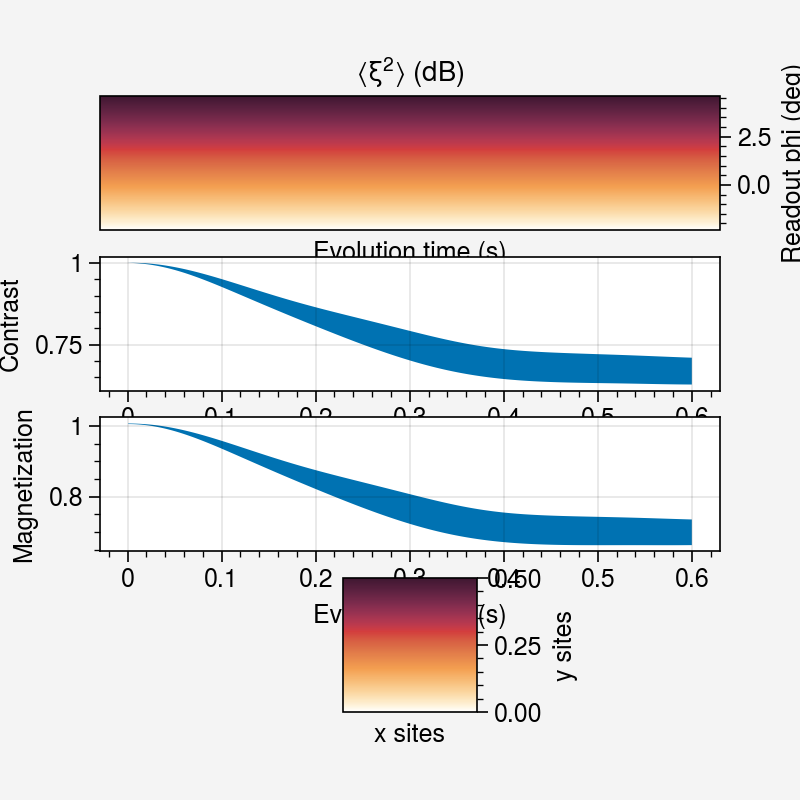

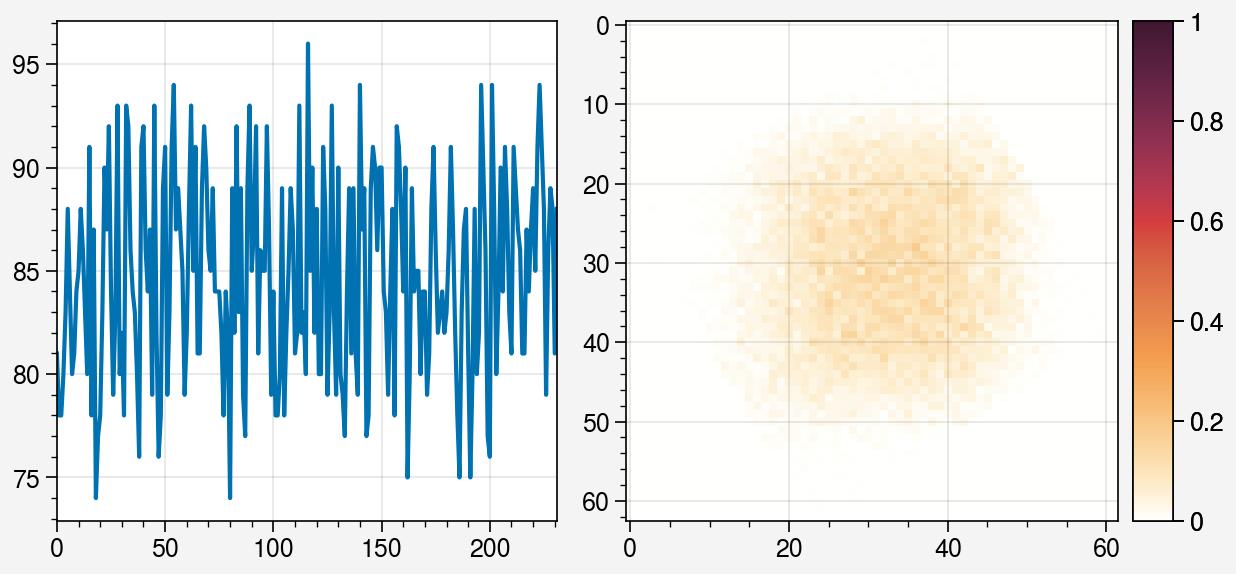

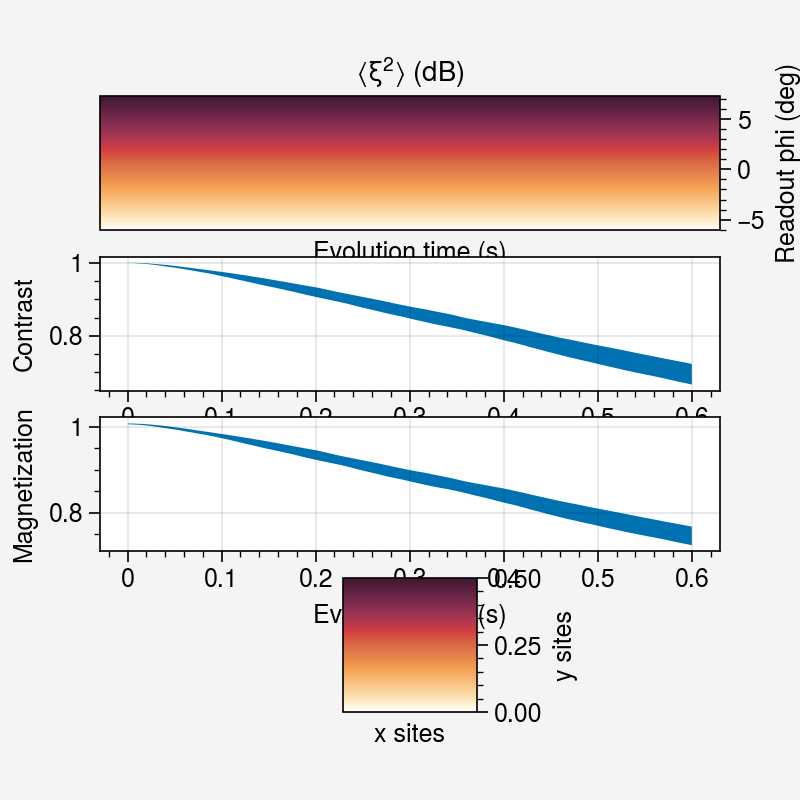

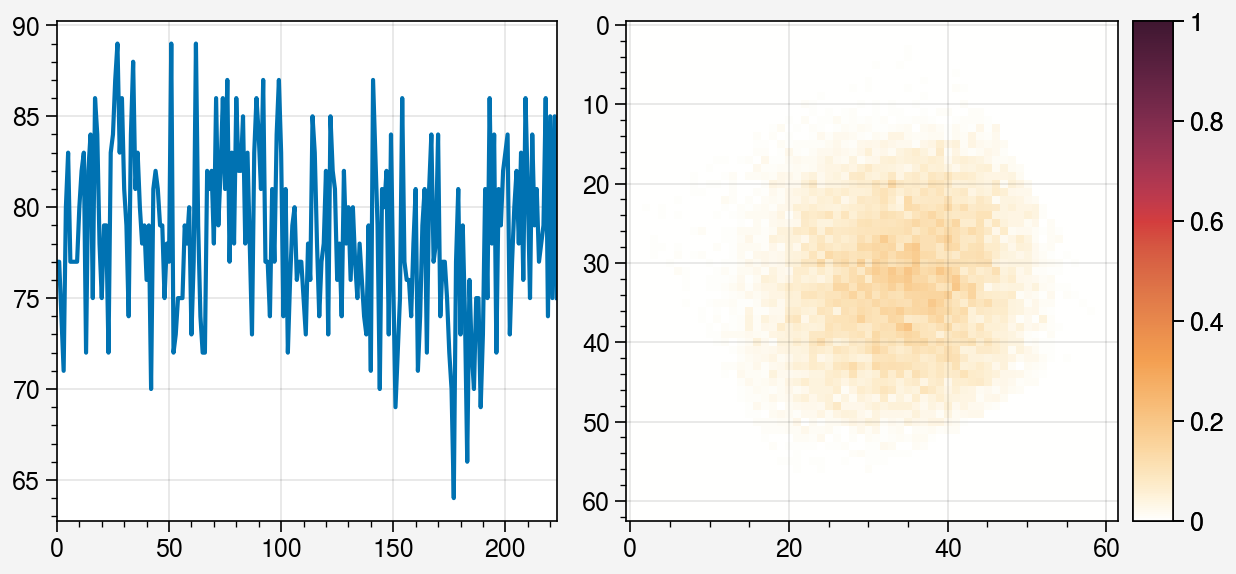

In [21]:
dirs = ['./data/2024/03/19', './data/2024/03/19', './data/2024/03/15']
scans = [80, 109, 113]

ds = []
for i in range(2):
    d = analyze(dirs[i], scans[i], sum_spindown=True, double="none", dtwaprefix="tunnelingcontrast%dHz_mh11" % TUNNELINGS[i],
                dtwatunnelfreq=TUNNELINGS[i])
    ds.append(d)

N_clip: (53.0, 68.0)  min_fill: 0.0209375
<N>: 60.75949367088607


Output()

  0%|          | 0/10 [00:00<?, ?it/s]

Calculating xi^2


  0%|          | 0/10 [00:00<?, ?it/s]

Ns in analyze: [55 50 56 48 59 53 47 54 58 58]


/home/vassilios/anaconda3/envs/tf/lib/python3.10/site-packages/erbium_analysis_modules/dtwa_module.py:143: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = axs[0].pcolormesh(Ts, Phis*180/np.pi, 10*np.log10(np.mean(xi2s, axis=0)))


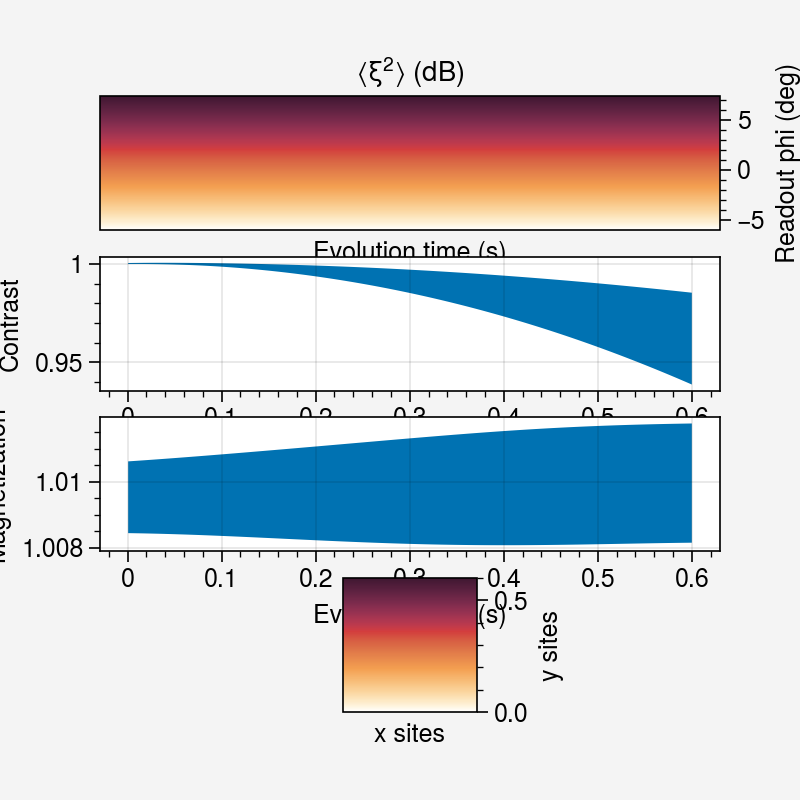

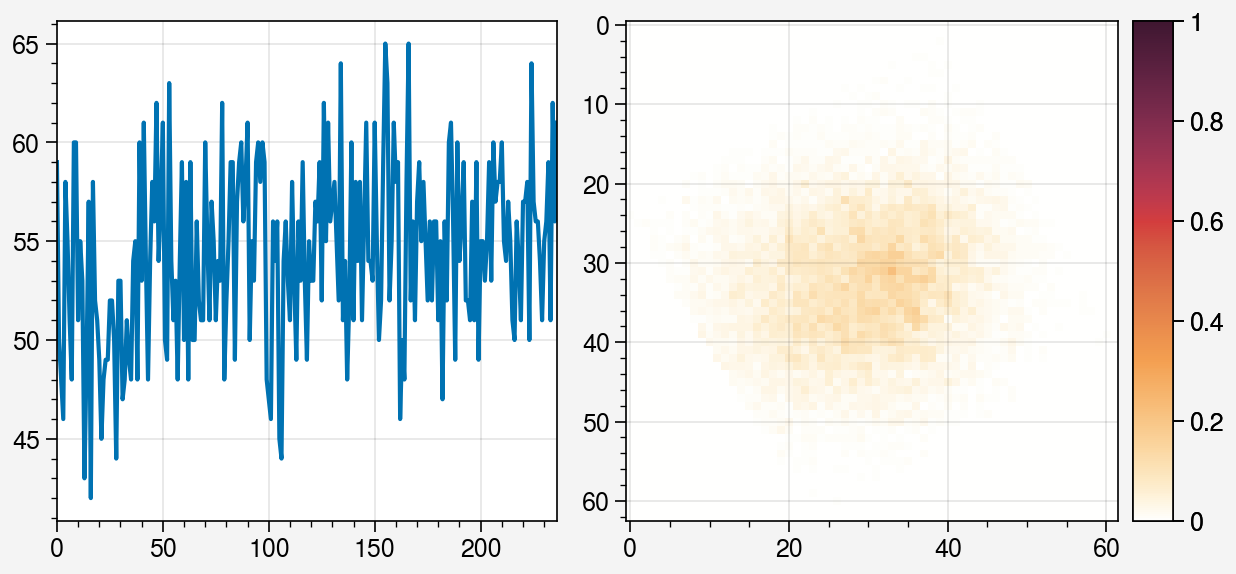

In [24]:
ds.append(
    analyze(dirs[2], scans[2], sum_spindown=True, double="none", dtwaprefix="tunnelingcontrast50Hz_avg",
                dtwatunnelfreq=0, dtwaavgJs=True)
)

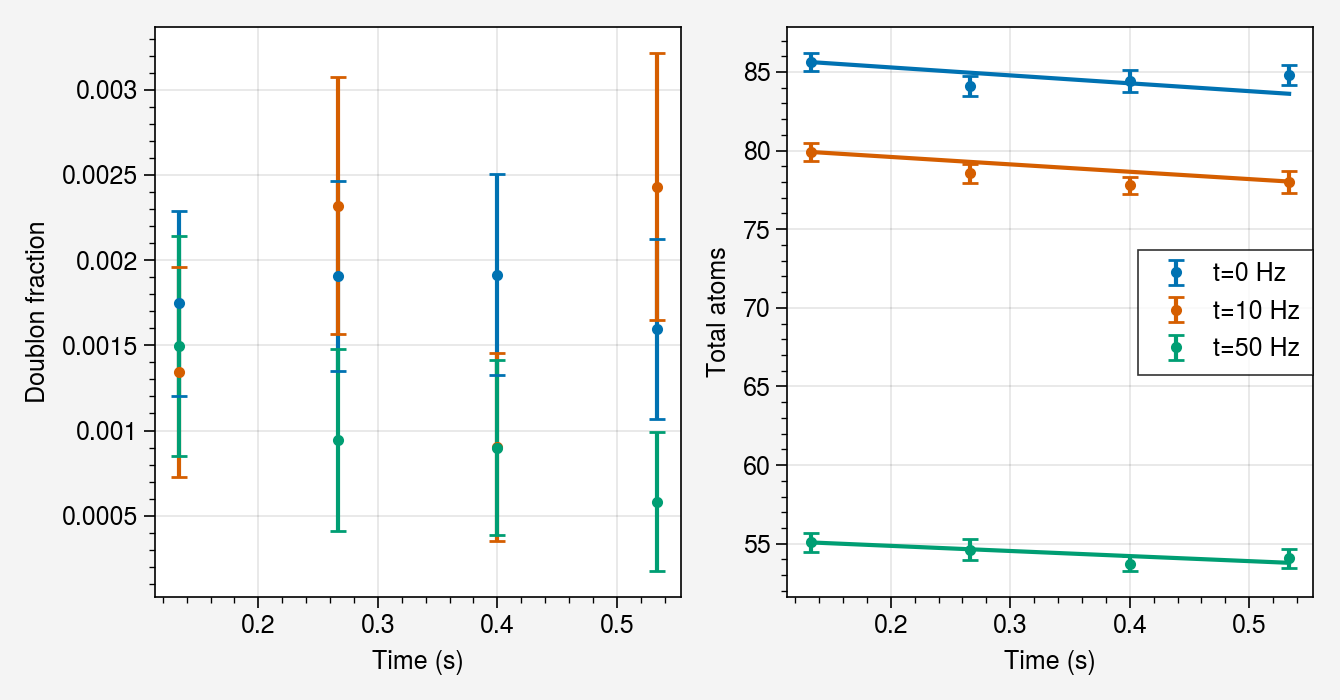

In [51]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(6.7, 3.5))

for i in range(3):
    show_doublons(ds[i], np.array(ds[i]["variable_values"]["MicrowavePulseSweepVar2"]), ax=ax, color=f"C{i}", label=f"t={TUNNELINGS[i]} Hz")
ax[1].legend()
fig.tight_layout()
fig.savefig("figures/doublons_tunneling.png")

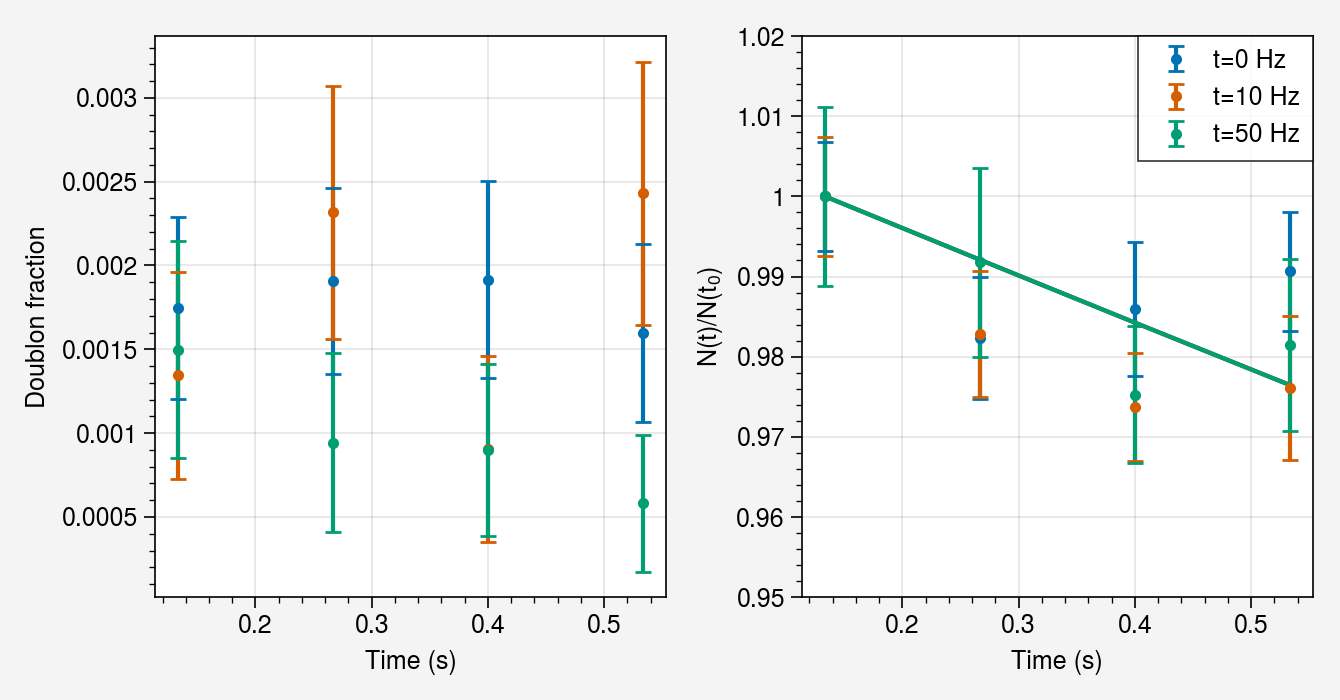

In [52]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(6.7, 3.5))

for i in range(3):
    show_doublons(ds[i], np.array(ds[i]["variable_values"]["MicrowavePulseSweepVar2"]), normN=True, ax=ax, color=f"C{i}", label=f"t={TUNNELINGS[i]} Hz")
ax[1].legend()
ax[1].set_ylim(0.95, 1.02)
fig.tight_layout()
fig.savefig("figures/doublons_tunneling_normN.png")

N_clip: (53.0, 68.0)  min_fill: 0.0209375
<N>: 60.75949367088607


Output()

  0%|          | 0/10 [00:00<?, ?it/s]

Calculating xi^2


  0%|          | 0/10 [00:00<?, ?it/s]

Ns in analyze: [47 56 50 49 53 50 61 46 53 53]


/home/vassilios/anaconda3/envs/tf/lib/python3.10/site-packages/erbium_analysis_modules/dtwa_module.py:143: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = axs[0].pcolormesh(Ts, Phis*180/np.pi, 10*np.log10(np.mean(xi2s, axis=0)))


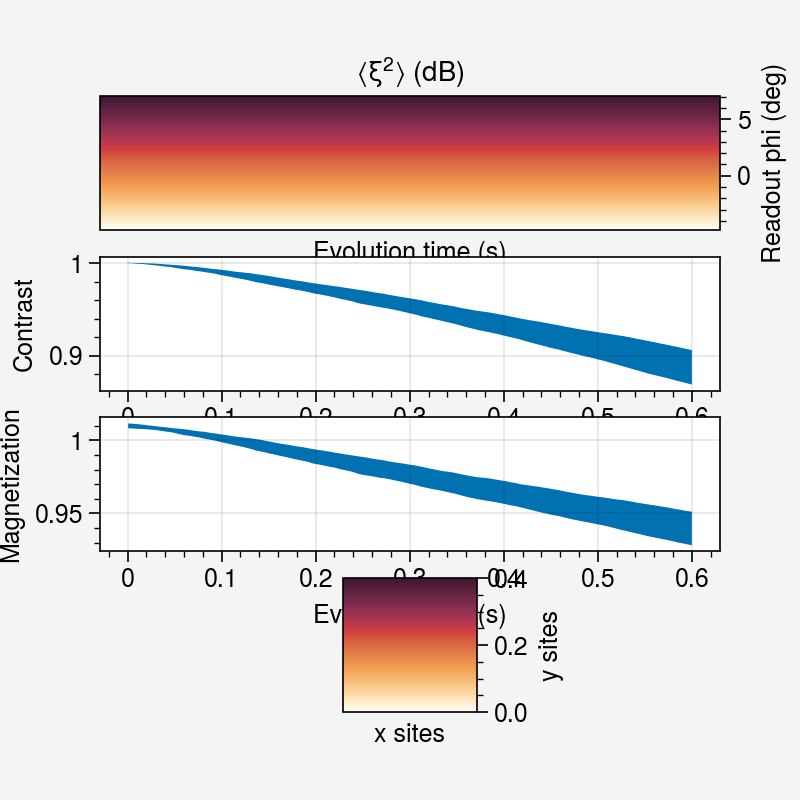

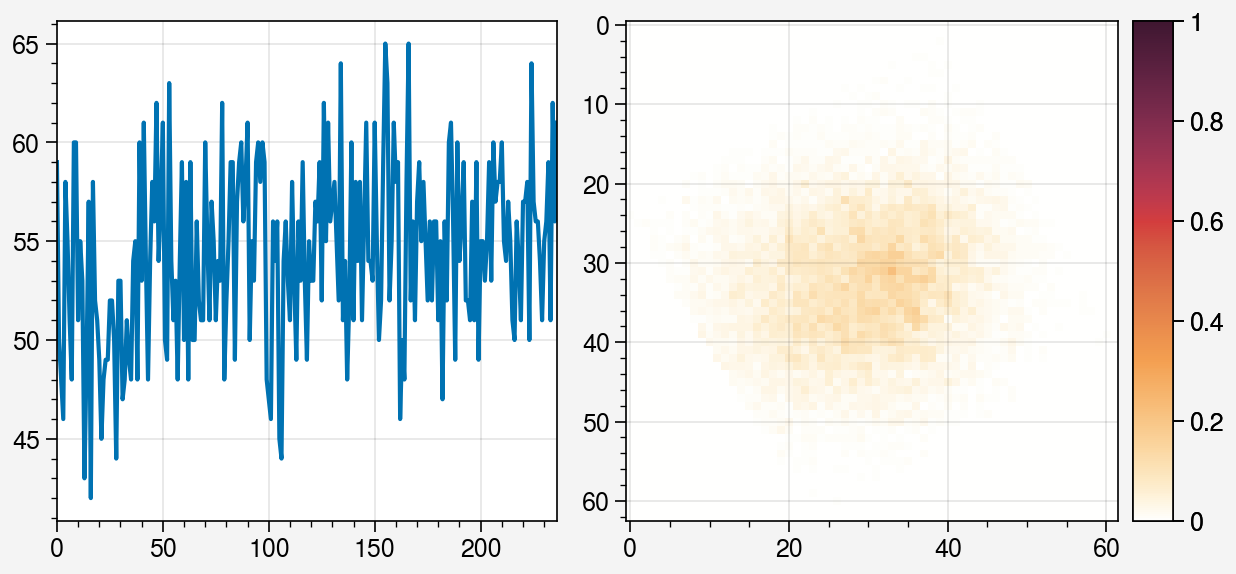

In [23]:
d_50Hz_mh = analyze(dirs[2], scans[2], sum_spindown=True, double="none", dtwaprefix="tunnelingcontrast%dHz_mh11" % TUNNELINGS[2],
                dtwatunnelfreq=TUNNELINGS[2])

In [24]:
MH_50Hz_Color = "green7"

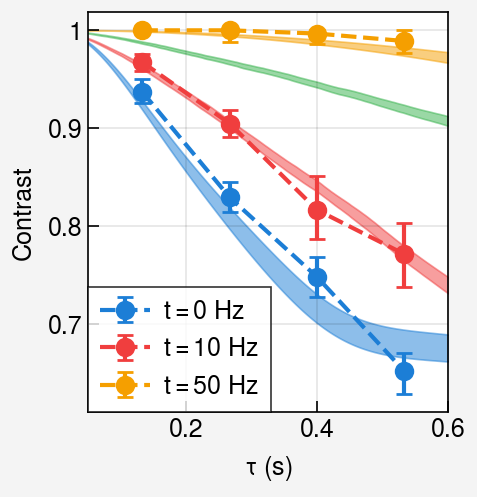

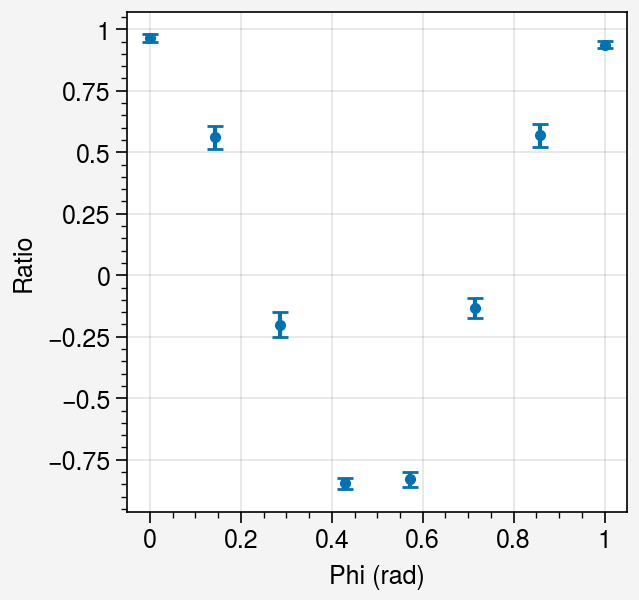

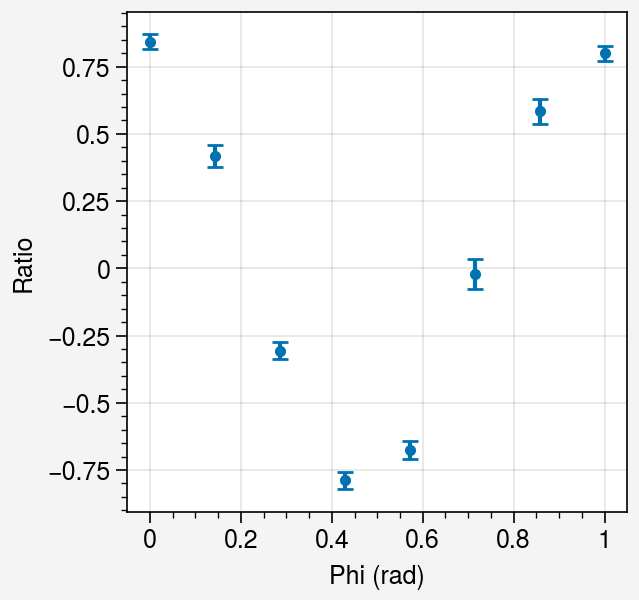

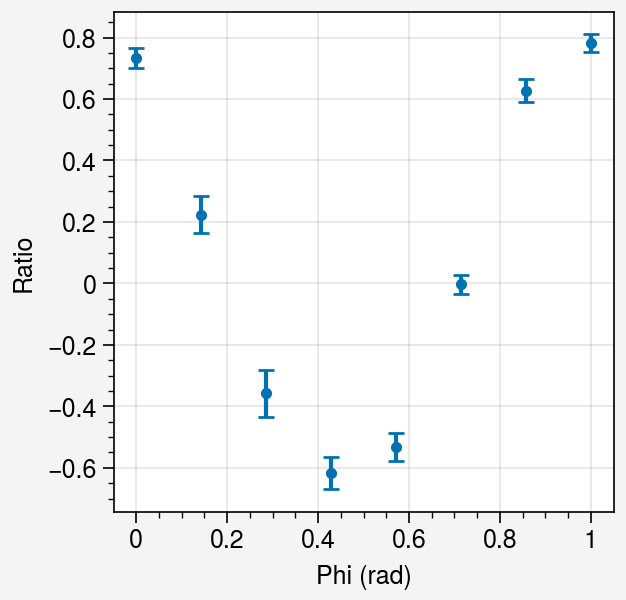

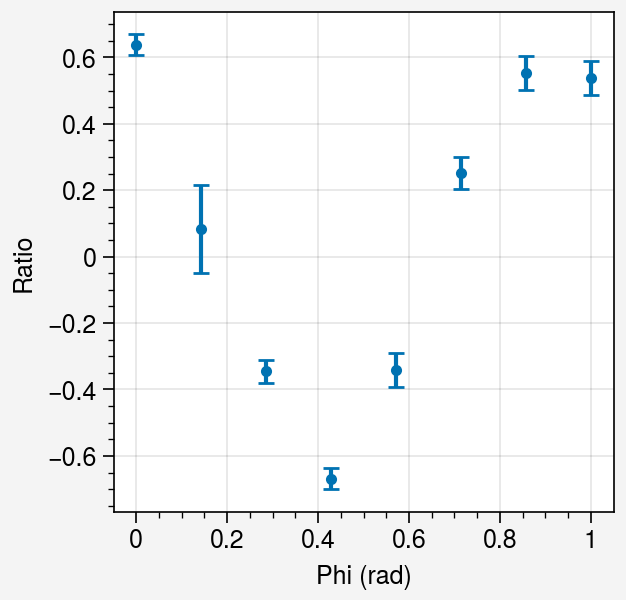

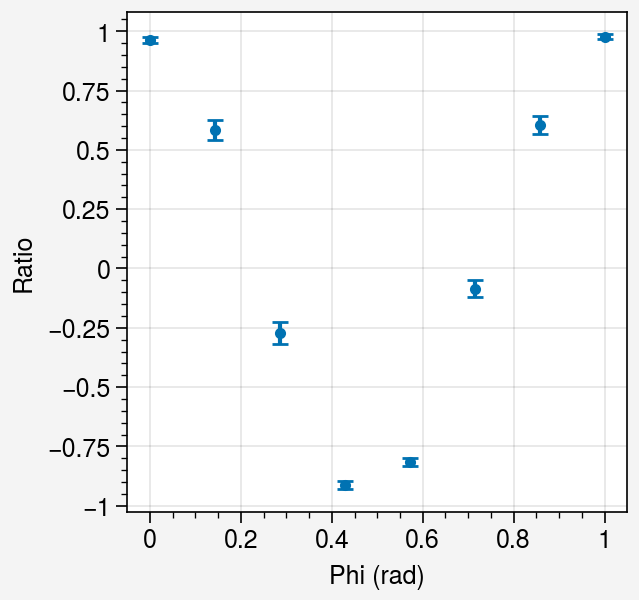

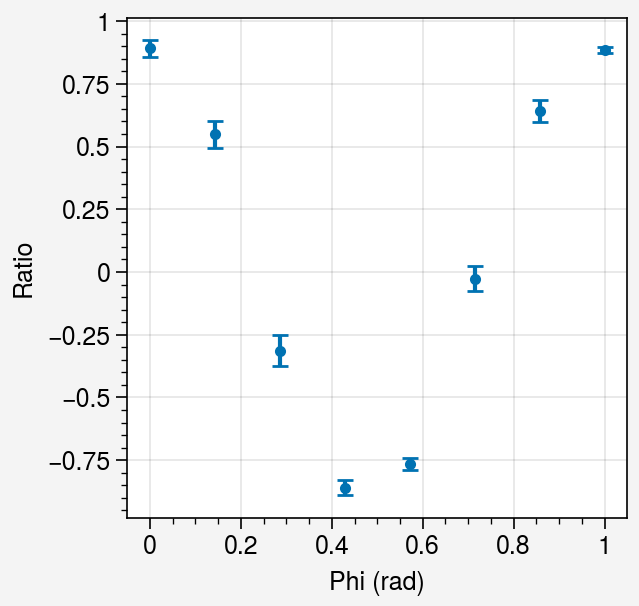

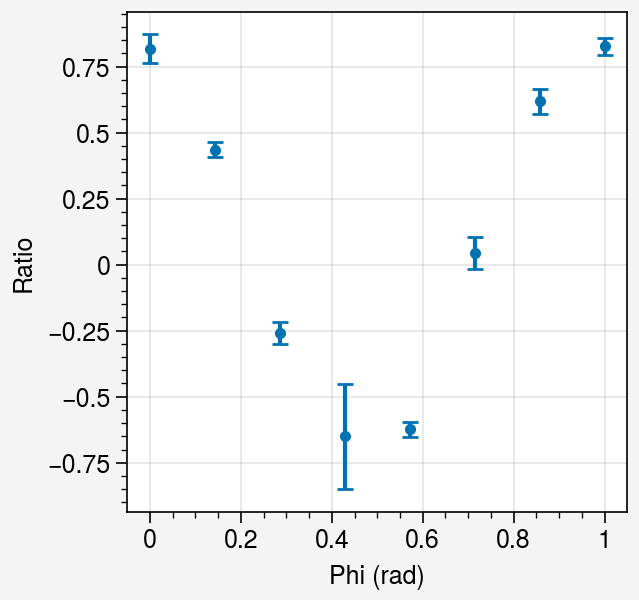

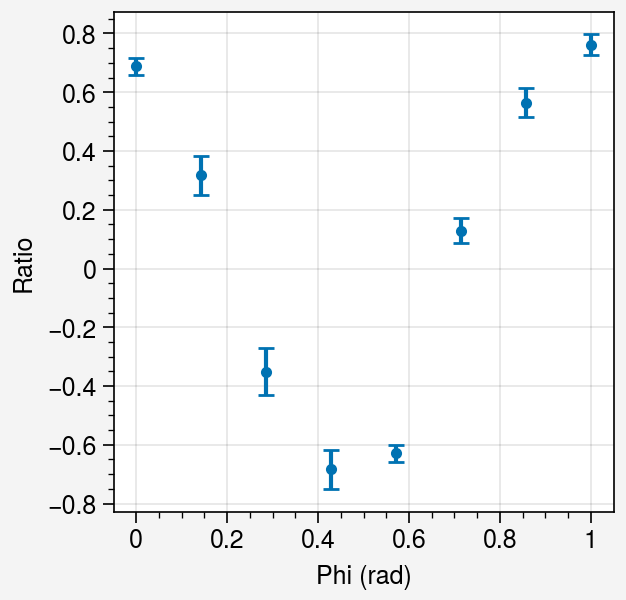

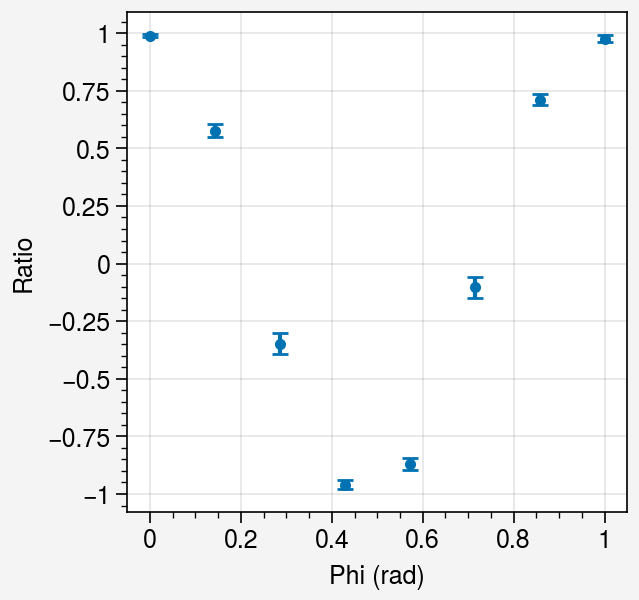

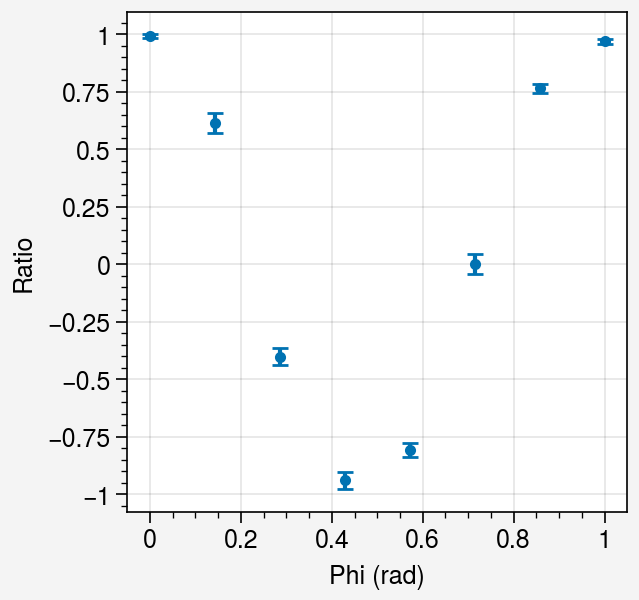

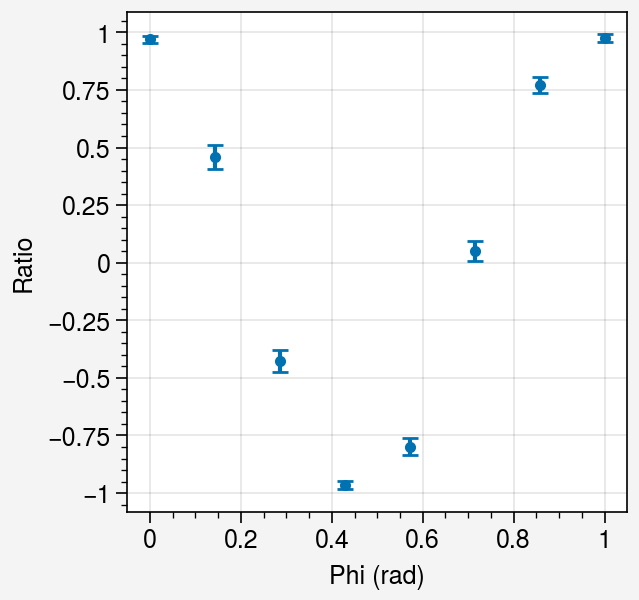

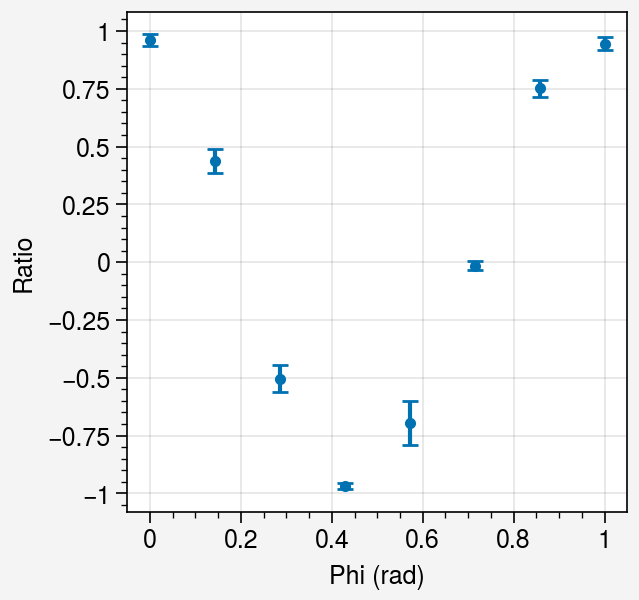

In [25]:
fig, ax = pplt.subplots([1], share=False, refwidth=1.8, refheight=2)

compare_tidx = 3

tun_cs = []
tun_cs_std = []
tun_cs_bdists = []

n_bootstrap_resamples = 500

for i in range(3):
    d = ds[i]
    
    all_ts = np.array(d["variable_values"]["MicrowavePulseSweepVar2"])
    ts = np.unique(all_ts)

    cs = []
    cs_std = []
    cs_bdists = []
    for j, t in enumerate(ts):
        (x, y, y_std), (popt, pstd, bdists), chisq, _ = get_contrast(d, all_ts == t, ret_pbdist=True, n_bootstrap_resamples=n_bootstrap_resamples)

        if j == compare_tidx:
            c = COLORS[i]
            #ax[1].errorbar(360*x, y, y_std, fmt=".", color=c)
            fit_x = np.linspace(np.min(x), np.max(x), 1000)
            #ax[1].plot(360*fit_x, sin(fit_x, *popt), color=c)
    
        cs.append(popt[0])
        cs_std.append(pstd[0])
        cs_bdists.append(bdists)

    cs_std = np.array(cs_std).T
    
    c = COLORS[i]
    ax[0].errorbar(ts, cs, yerr=cs_std, fmt="o", ls="--", color=c, label=r'$t=%d$ Hz' % TUNNELINGS[i])
    ax[0].fill_between(d["dtwa"]["ts"], d["dtwa"]["cs"] - d["dtwa"]["cs_std"], d["dtwa"]["cs"] + d["dtwa"]["cs_std"], 
                   alpha=0.5, color=c)
    
    if i == 2:
        c = MH_50Hz_Color
        ax[0].fill_between(d_50Hz_mh["dtwa"]["ts"], d_50Hz_mh["dtwa"]["cs"] - d_50Hz_mh["dtwa"]["cs_std"], 
                           d_50Hz_mh["dtwa"]["cs"] + d_50Hz_mh["dtwa"]["cs_std"], 
                           alpha=0.5, color=c)
    
    tun_ts = ts
    
    tun_cs.append(cs)
    tun_cs_std.append(cs_std)
    tun_cs_bdists.append(cs_bdists)
    
    save_data_twosided("fig4_C_%dHz" % TUNNELINGS[i], ts, cs, cs_std, "tau (s)", "Contrast")

    #vmax = 0.5
    #plot_occs(ax[2+i], d, vmax)
    #ax[2+i].format(righttitle=r'$t=%d$ Hz' % TUNNELINGS[i])
ax[0].format(xlabel=r'$\tau$ (s)', ylabel="Contrast",
             xlim=(0.05, 0.6), tickdir="in", yminorticks=[], xminorticks=[])
ax[0].legend(ncols=1)

    

fig.savefig("figures/tunneling_contrast.pdf")
fig.savefig("figures/tunneling_contrast.png", dpi=300)

## Squeezing

N_clip: (54.0, 69.0)  min_fill: 0.03066010422698321
<N>: 61.06014712245781


/tmp/ipykernel_133891/1561827269.py:24: RuntimeWarning: invalid value encountered in divide
  ratio = (spinup - spindown)/N


Output()

  0%|          | 0/10 [00:00<?, ?it/s]

Calculating xi^2


  0%|          | 0/10 [00:00<?, ?it/s]

Ns in analyze: [52 61 53 47 53 58 57 57 56 53]


/home/vassilios/anaconda3/envs/tf/lib/python3.10/site-packages/erbium_analysis_modules/dtwa_module.py:143: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = axs[0].pcolormesh(Ts, Phis*180/np.pi, 10*np.log10(np.mean(xi2s, axis=0)))


N_clip: (55.0, 69.0)  min_fill: 0.03172109010557329
<N>: 61.788432267884325


/tmp/ipykernel_133891/1561827269.py:24: RuntimeWarning: invalid value encountered in divide
  ratio = (spinup - spindown)/N


Output()

  0%|          | 0/10 [00:00<?, ?it/s]

Calculating xi^2


  0%|          | 0/10 [00:00<?, ?it/s]

Ns in analyze: [53 61 50 56 53 57 57 62 54 56]


/home/vassilios/anaconda3/envs/tf/lib/python3.10/site-packages/erbium_analysis_modules/dtwa_module.py:143: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = axs[0].pcolormesh(Ts, Phis*180/np.pi, 10*np.log10(np.mean(xi2s, axis=0)))


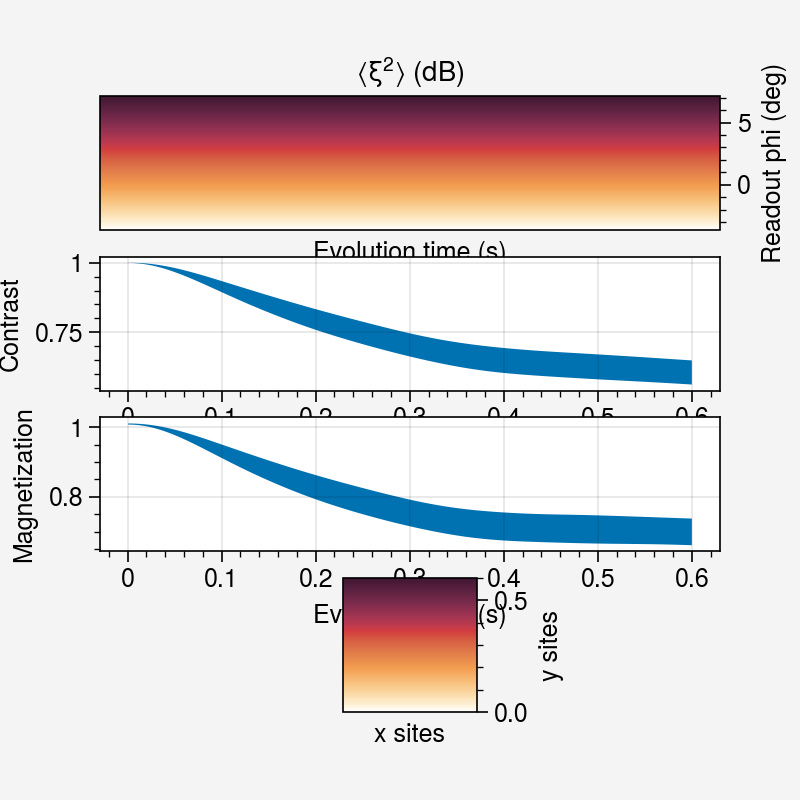

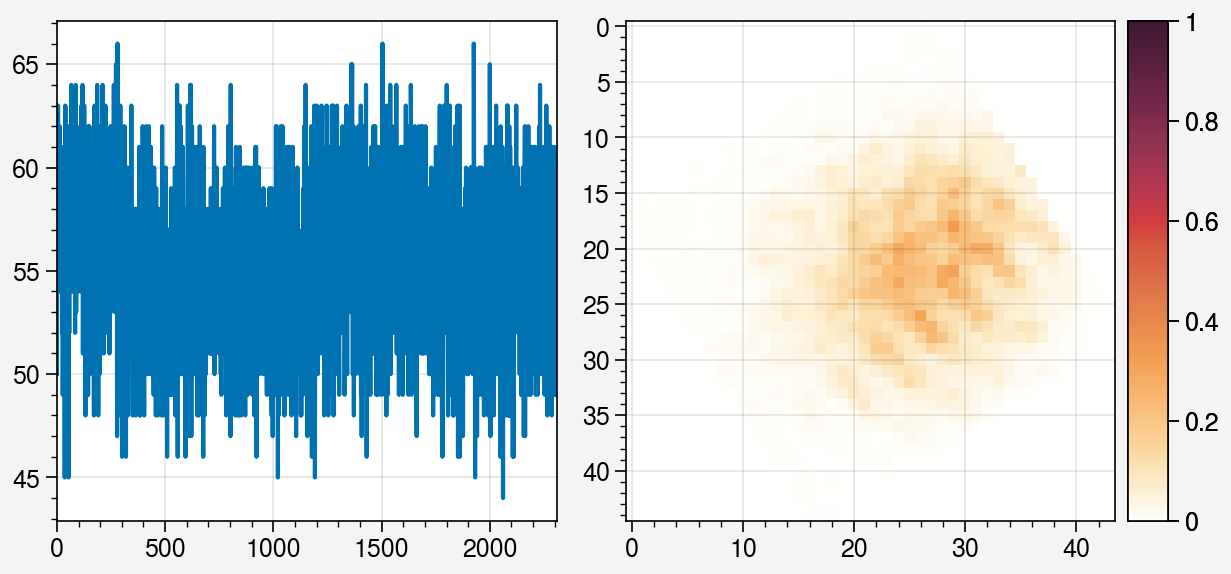

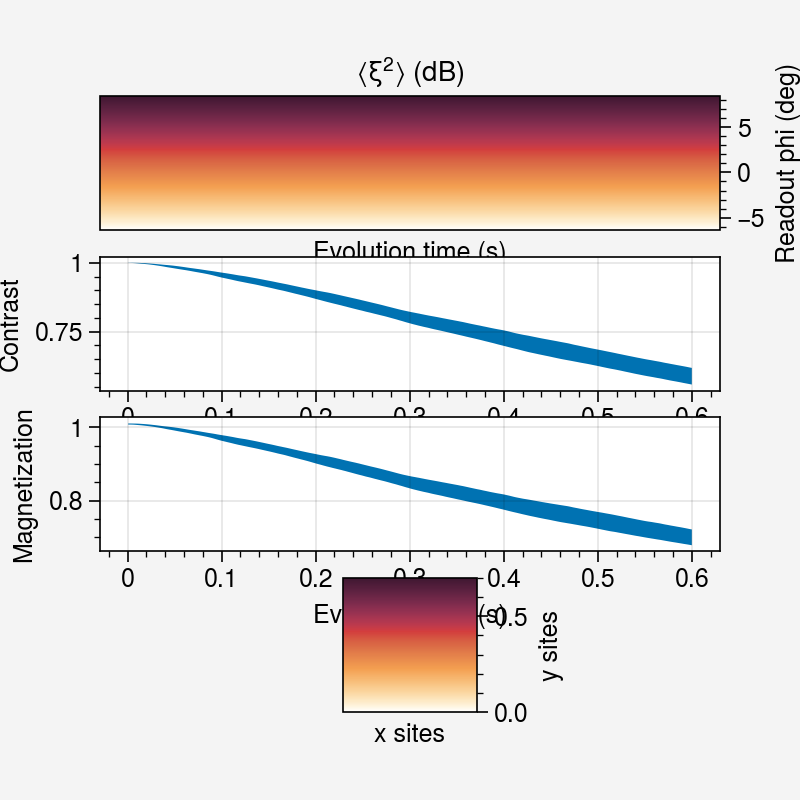

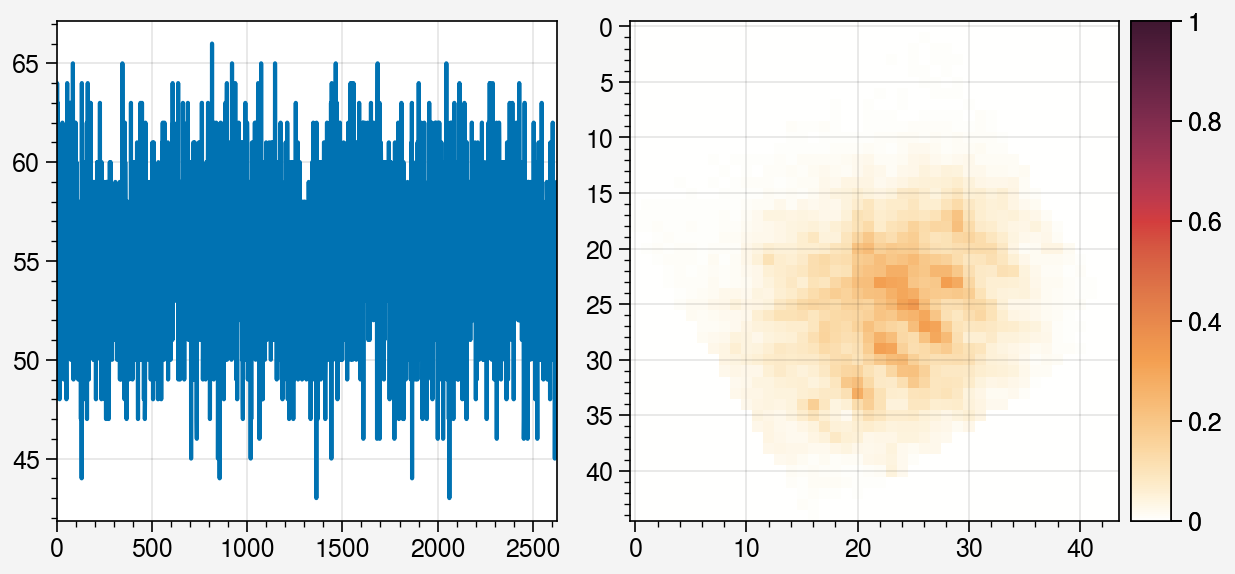

In [32]:
dirs = ['./data/2024/02/02', './data/2024/02/02', './data/2024/02/01']
scans = [40, 18, 179]

d_t = []
for i in range(2):
    d = analyze(dirs[i], scans[i],
                     sum_spindown=True,
                     ratio_clip=(-0.5, 0.5),
                     double="none", dtwaprefix="tunnelingsqueezing%dHz_mh11" % TUNNELINGS[i],
                     dtwatunnelfreq=TUNNELINGS[i])

    d_t.append(d)

N_clip: (63.0, 78.0)  min_fill: 0.024176857949200378
<N>: 68.85526315789474


/tmp/ipykernel_133891/1561827269.py:24: RuntimeWarning: invalid value encountered in divide
  ratio = (spinup - spindown)/N


Output()

  0%|          | 0/10 [00:00<?, ?it/s]

Calculating xi^2


  0%|          | 0/10 [00:00<?, ?it/s]

Ns in analyze: [67 61 67 67 65 70 59 65 61 64]


/home/vassilios/anaconda3/envs/tf/lib/python3.10/site-packages/erbium_analysis_modules/dtwa_module.py:143: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = axs[0].pcolormesh(Ts, Phis*180/np.pi, 10*np.log10(np.mean(xi2s, axis=0)))


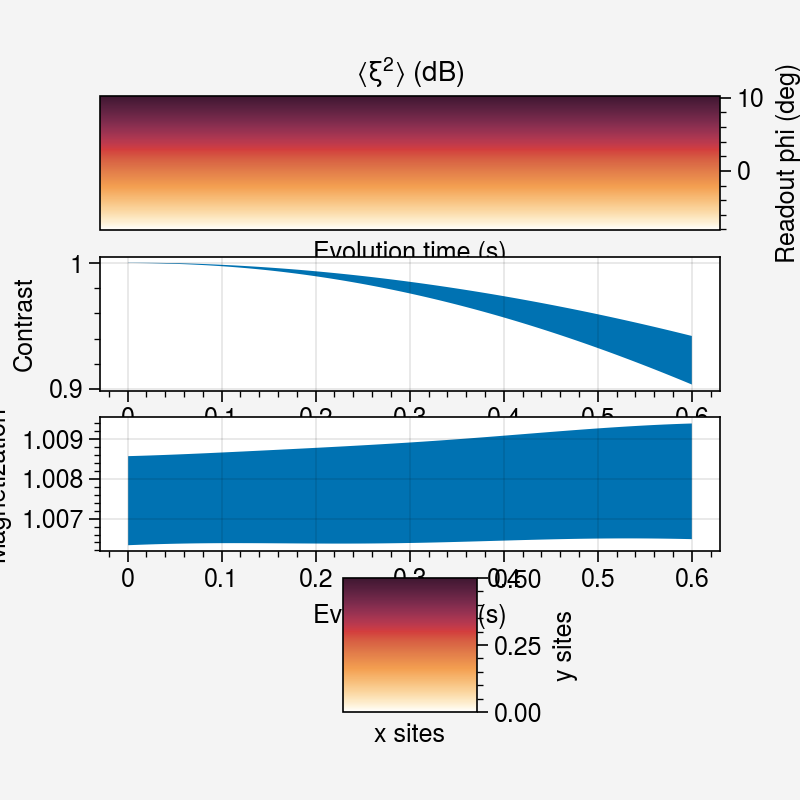

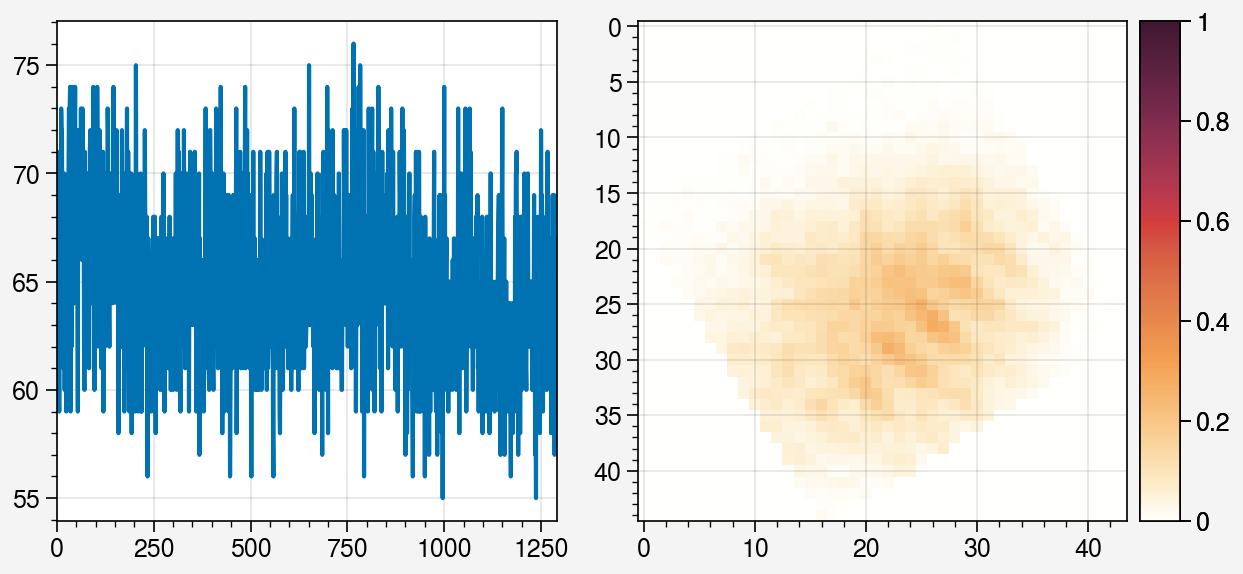

In [33]:
d_t.append(
    analyze(dirs[2], scans[2],
                     sum_spindown=True,
                     ratio_clip=(-0.5, 0.5),
                     double="none", dtwaprefix="tunnelingsqueezing50Hz_avg",
                     dtwatunnelfreq=0, dtwaavgJs=True)
)

/home/vassilios/anaconda3/envs/tf/lib/python3.10/site-packages/proplot/ui.py:143: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  return plt.figure(FigureClass=pfigure.Figure, **kwargs)


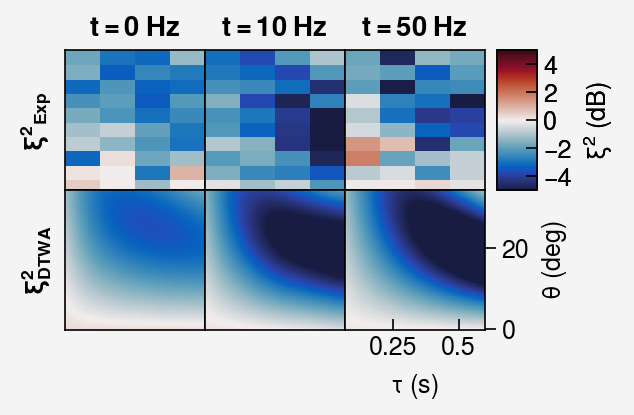

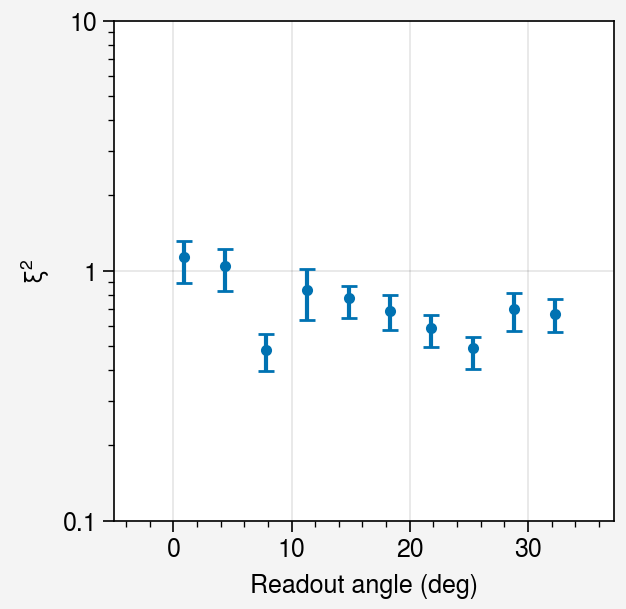

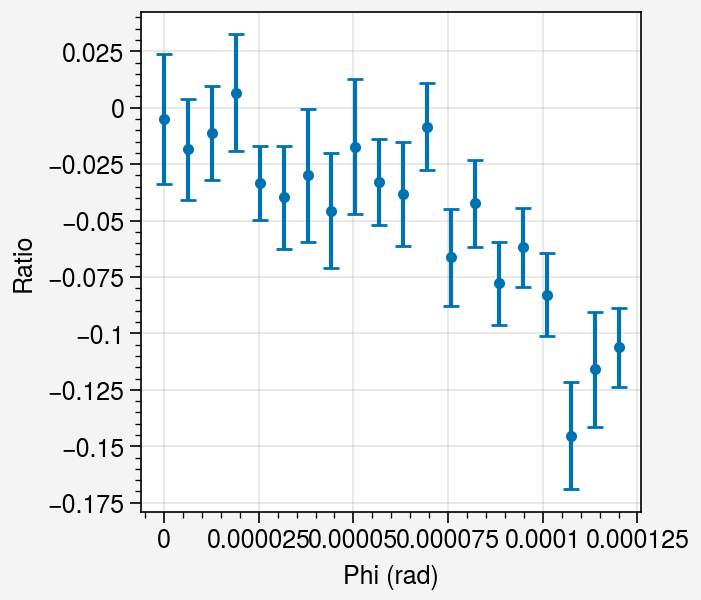

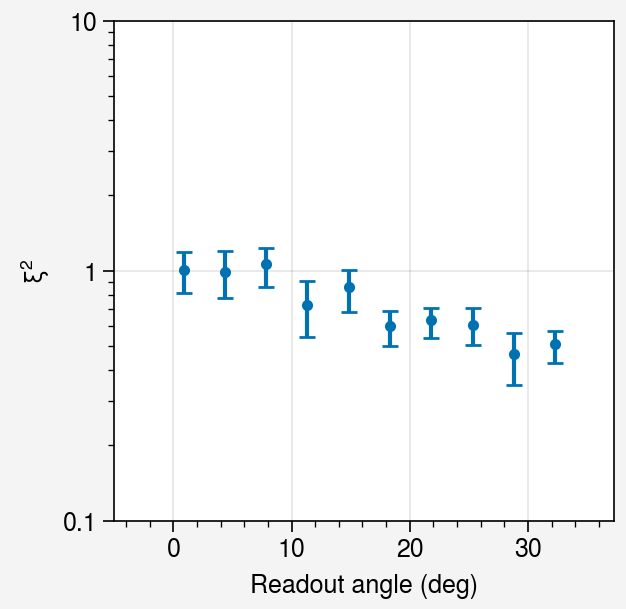

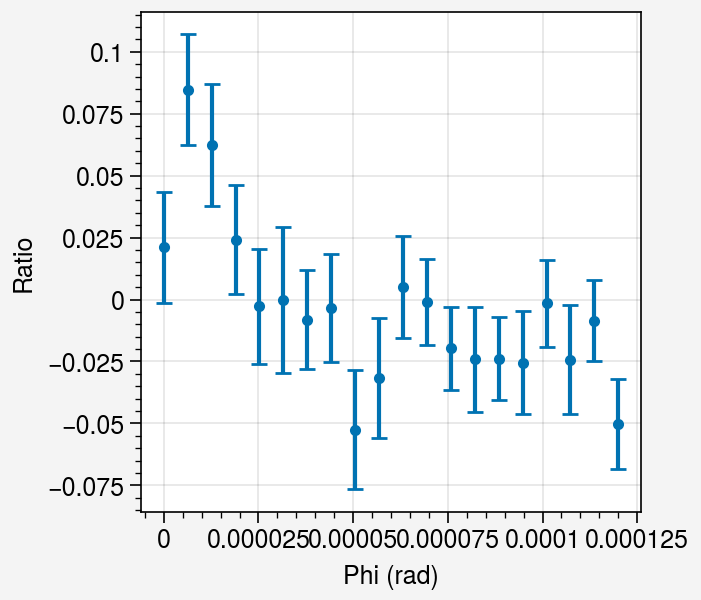

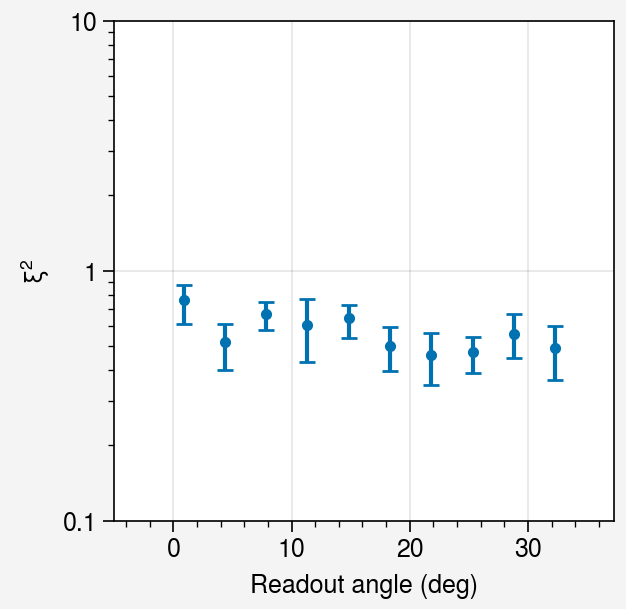

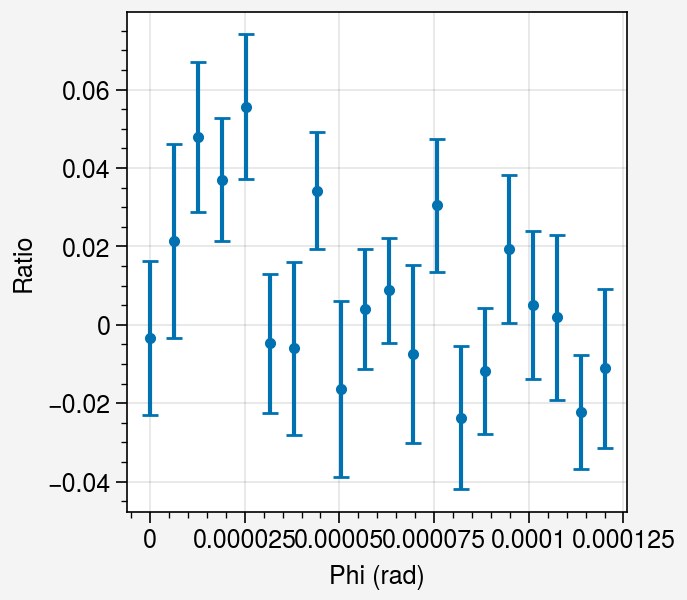

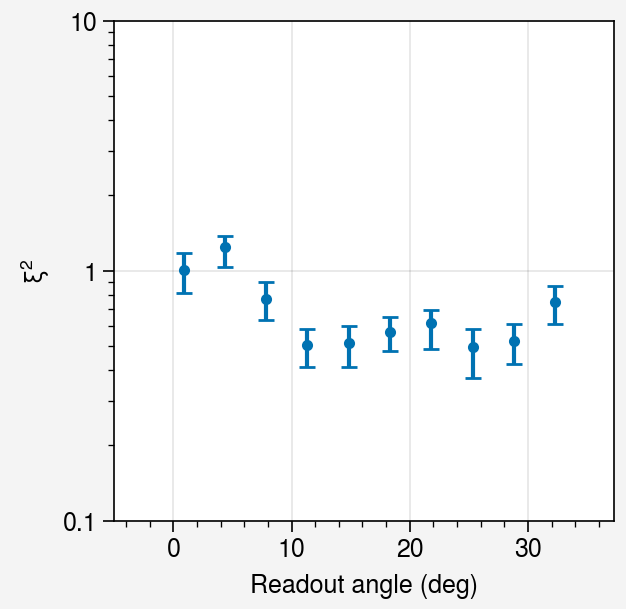

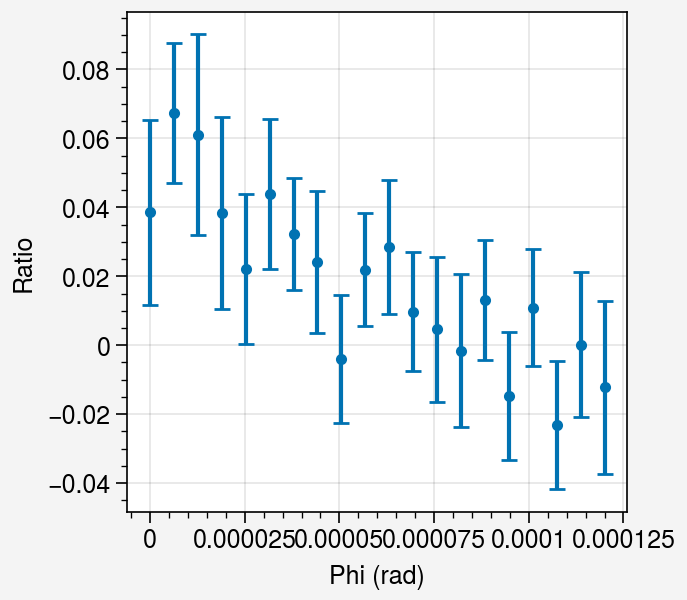

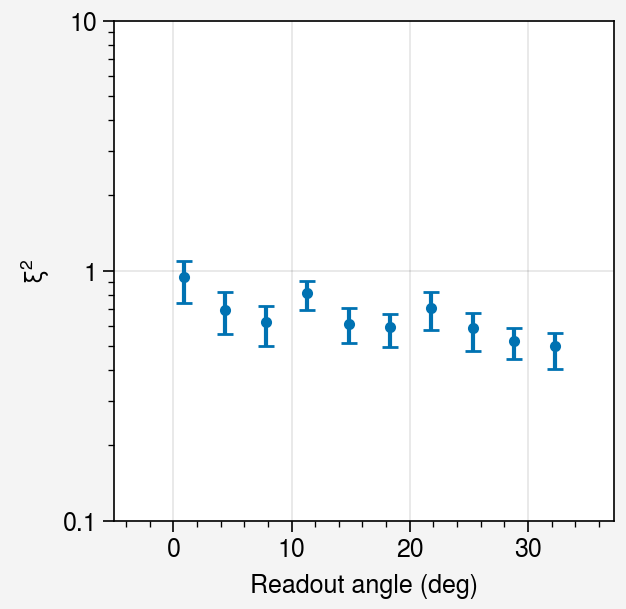

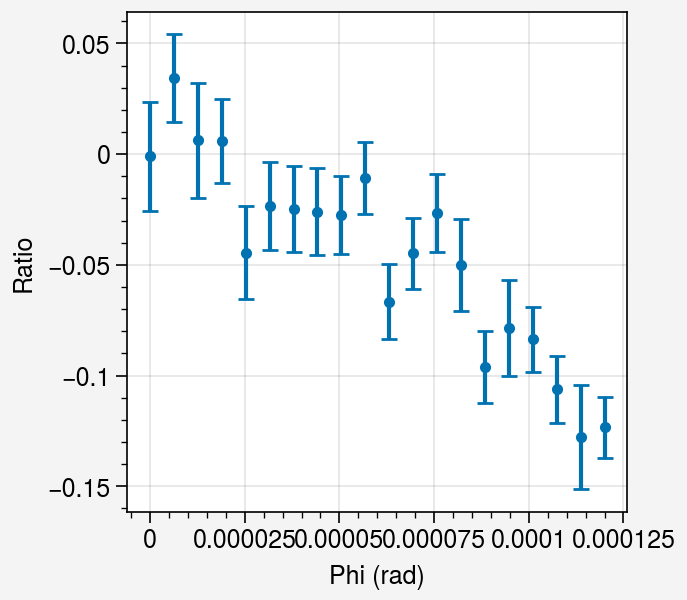

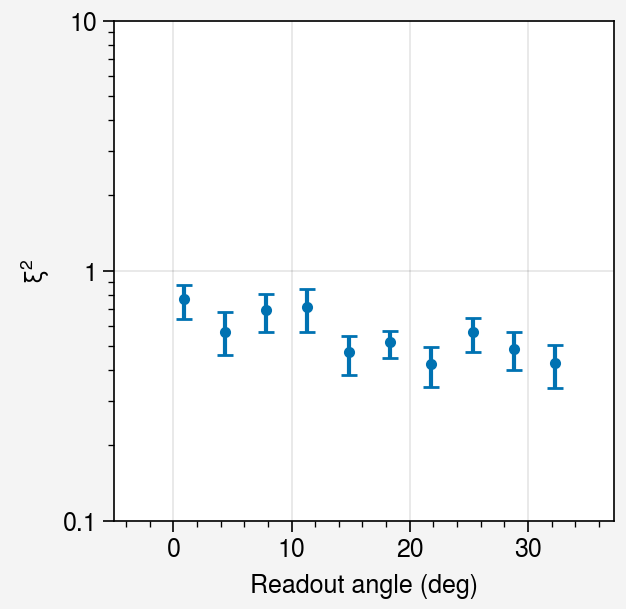

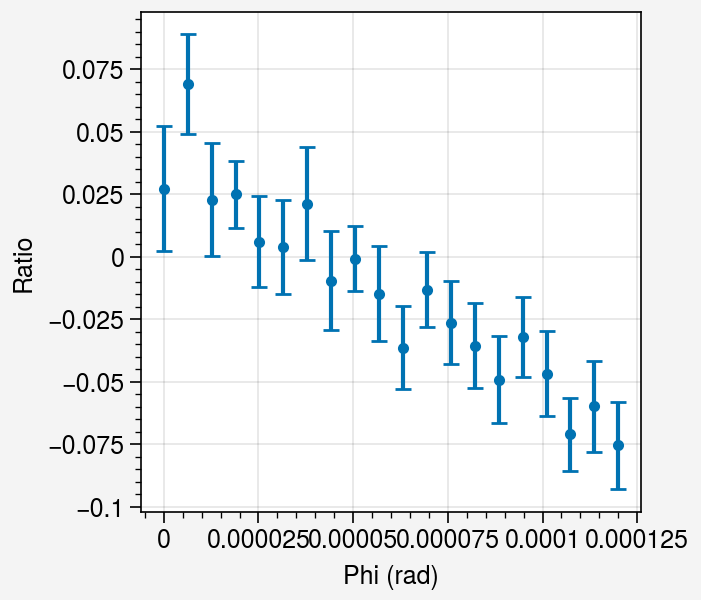

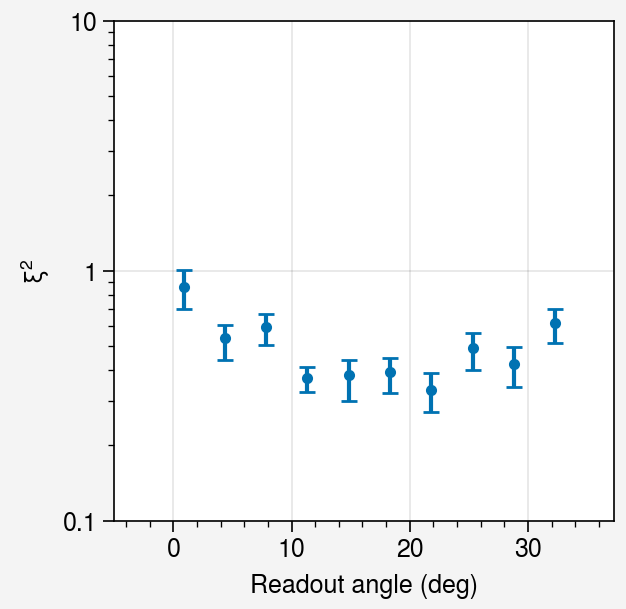

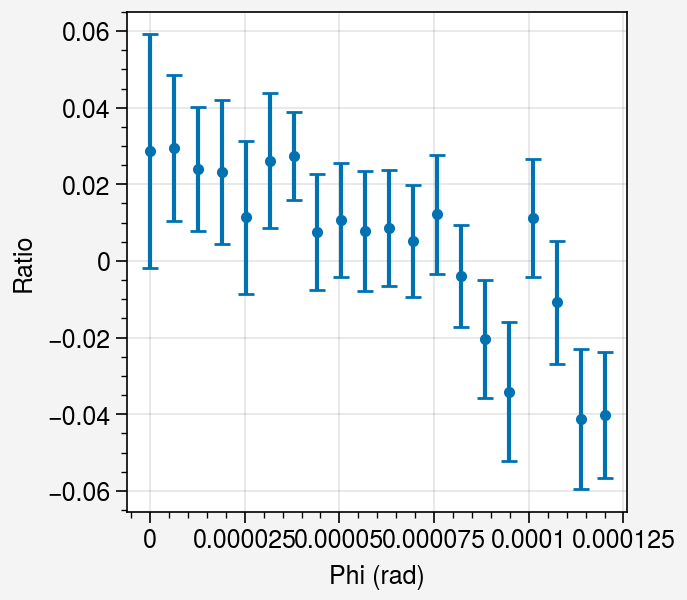

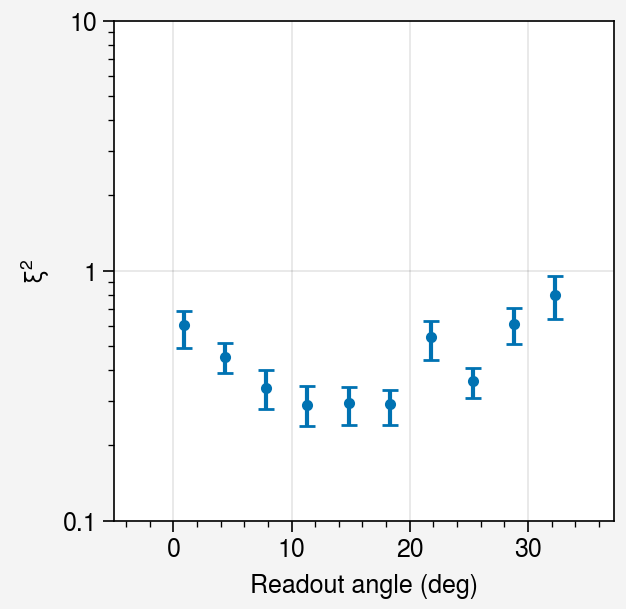

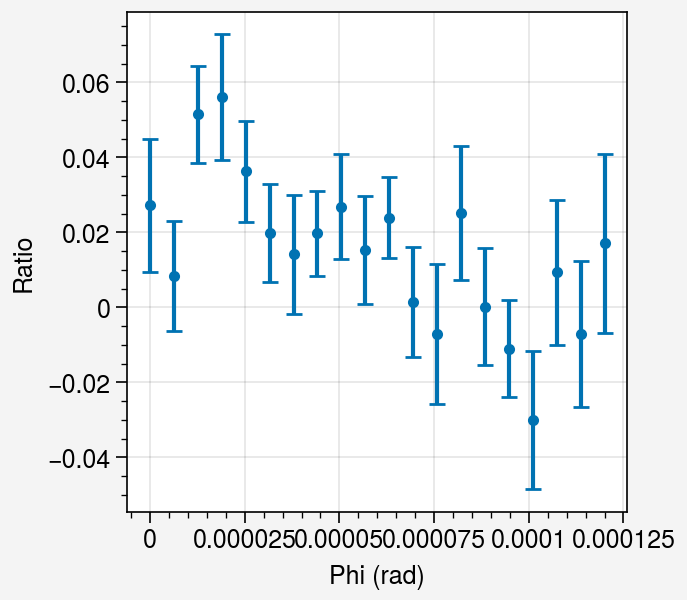

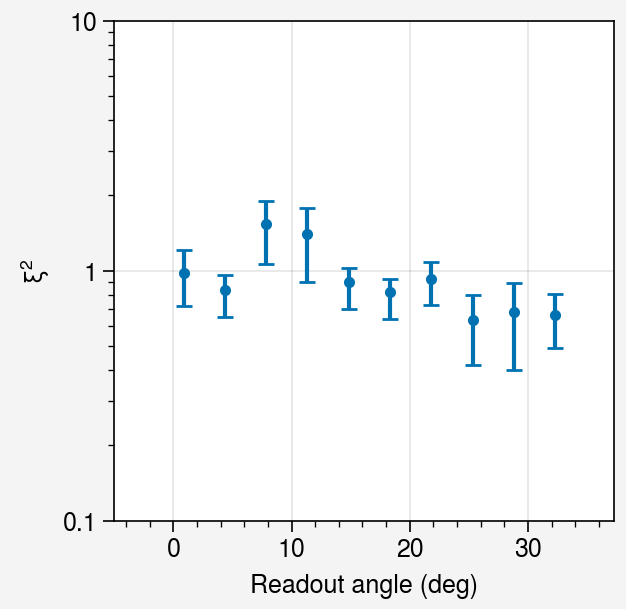

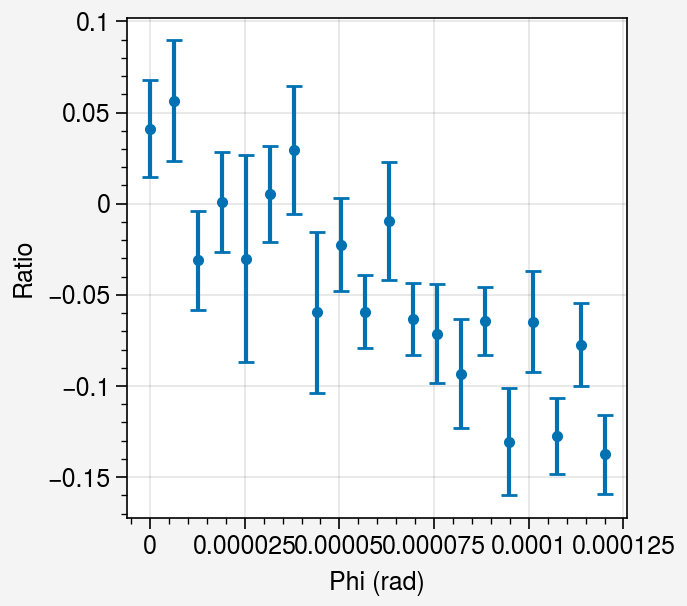

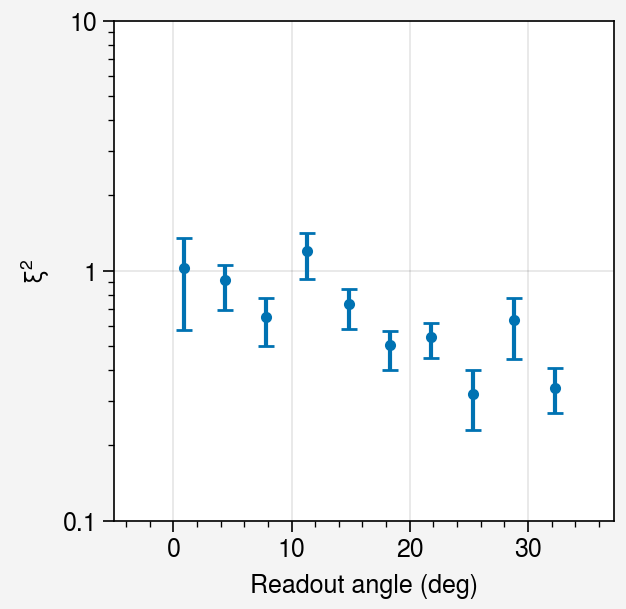

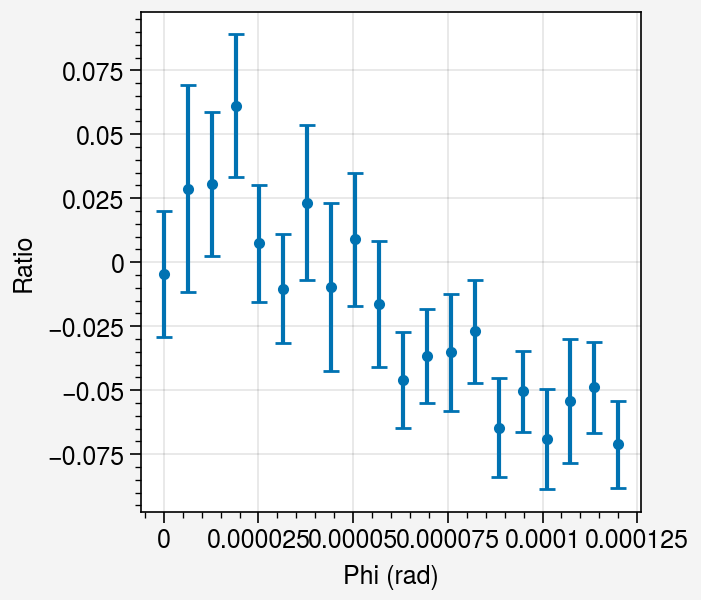

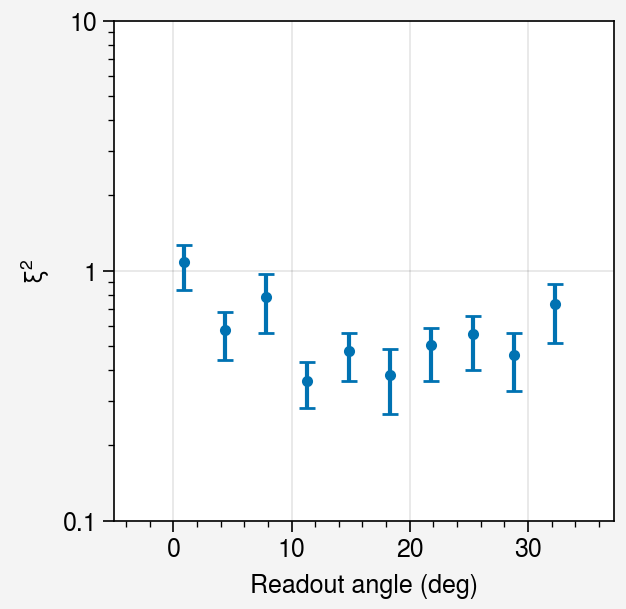

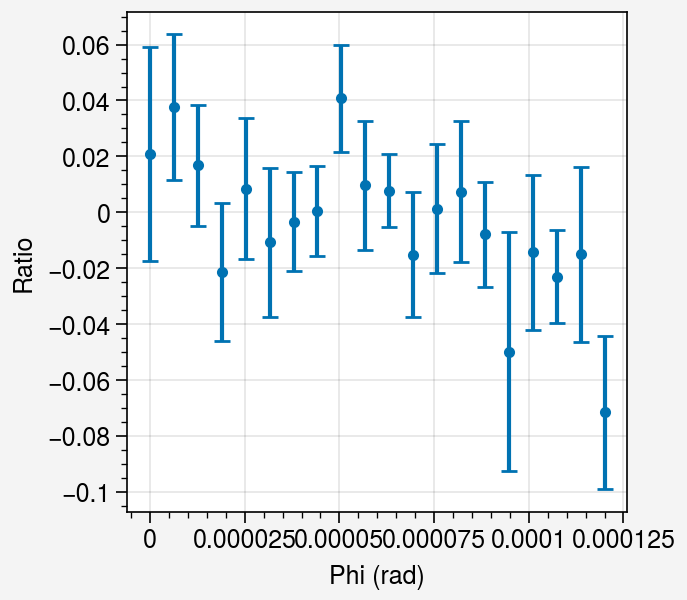

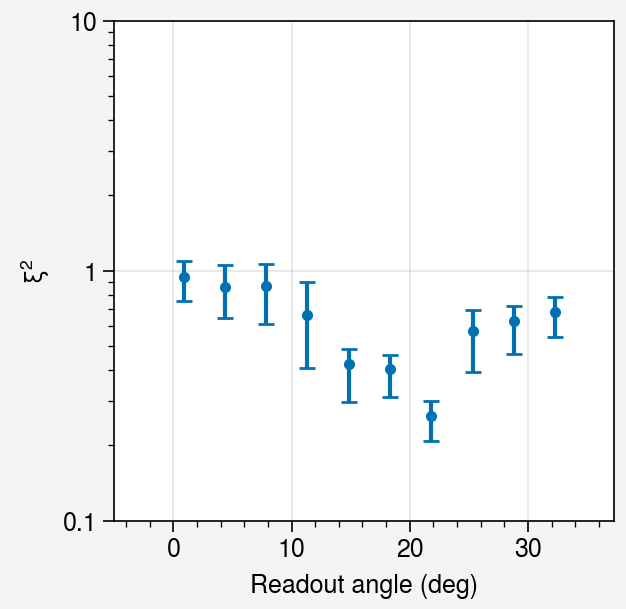

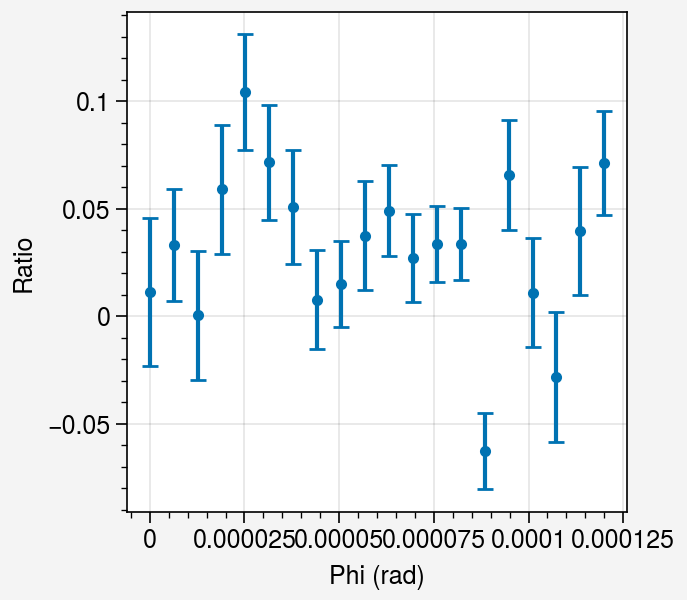

In [41]:
rabi = 0.5/0.651e-3 # TODO

fig, ax = pplt.subplots([[1,2,3],[4,5,6]], share=False, refwidth=0.7, refheight=0.7, space=0)

xi2_all_t = []
xi2_all_std_t = []
xi2_all_bdists_t = []

n_bootstrap_resamples = 500

for i in range(3):
    d = d_t[i]
    
    all_ts = np.array(d["variable_values"]["MicrowavePulseSweepVar2"])
    ts = np.unique(all_ts)

    xi2_all = []
    xi2_all_std = []
    xi2_all_bdists = []
    for ti, t in enumerate(ts):
        x, y_mean, y_std, all_s, bdists = get_squeezing(d, all_ts == t, rabi, phi_bins=2, n_bootstrap_resamples=n_bootstrap_resamples)
        xi2_all.append(y_mean)
        xi2_all_std.append(y_std)
        xi2_all_bdists.append(bdists)
        
        (c_x, c_y, c_y_std), (c_popt, c_pstd), c_chisq, _ = get_contrast(d, all_ts == t, ret_pbdist=False, do_fit=False)
        
        save_data_twosided("fig4_B_%dHz_t%.3fs" % (TUNNELINGS[i], t), x*2*np.pi*rabi*180/np.pi, y_mean, y_std, "theta (deg)", "xi^2")
    xi2_all = np.array(xi2_all)
    xi2_all_std = np.array(xi2_all_std)
        
    xi2_all_t.append(xi2_all)
    xi2_all_std_t.append(xi2_all_std)
    xi2_all_bdists_t.append(xi2_all_bdists)
    
    c = plot_xi2(ax[i], xi2_all, ts, x, rabi)#, nbins=(1, 2)) #filt=lambda y: np.stack([ gaussian_filter(y[i], 1) for i in range(y.shape[0]) ]), nbins=(1,2))
    #plot_xi2(ax[3+i], xi2_all, ts, x, rabi, filt=lambda y: gaussian_filter(y, 1))
    plot_xi2_sim(ax[3+i], d, ts, x, rabi)
    #plot_xi2_sim_ratio(ax[3+i], d, xi2_all, ts, x, rabi, nbins=(1, 2))

    
    
    #vmax = 0.5
    #plot_occs(ax[9+i], d, vmax)
    for j in range(2):
        ax[3*j+i].format(xminorticks=[], yminorticks=[])
        if not (i == 2 and j == 1):
            ax[3*j+i].format(xticks=[], yticks=[])

    ax[i].format(title=r'$\mathbf{t=%d}\;\mathbf{Hz}$' % TUNNELINGS[i])
ax[0].format(ylabel=r'$\mathbf{\xi^2}_{\mathbf{Exp}}$ ')
ax[3].format(ylabel=r'$\mathbf{\xi^2_{\mathbf{DTWA}}}$') #/\xi^2_{\mathrm{DTWA}}$ (dB)')
ax[5].format(xlabel=r'$\tau$ (s)', ylabel=r'$\theta$ (deg)', ytickloc="right", xtickdir="in")
cbar = ax[2].colorbar(c, tickdir="in")
cbar.set_label(r'$\xi^2$ (dB)')
#fig.suptitle(r'$\xi^2$ (dB)')
fig.savefig("figures/tunneling_squeezing.svg", dpi=300)
fig.savefig("figures/tunneling_squeezing.png", dpi=300)

[0.9368517407120189, 0.8290149000588263, 0.7477388379483809, 0.6514342225456717]
[2.06533749e+01 3.67908938e-03 1.15049470e+00] [[ 2.47037682e+00 -8.78181072e-04  2.43747272e-02]
 [-8.78181072e-04  1.23115165e-06 -7.71625324e-05]
 [ 2.43747272e-02 -7.71625324e-05  1.22778011e-02]] 1.126659591595432
[2.06533749e+01 3.67908938e-03 1.15049470e+00]
cs: 0.6332725364745533
[0.9673041434412242, 0.9046372662227411, 0.8163009750424413, 0.7711007081511129]
[1.50248213e+01 2.54784262e-03 4.70639819e-01] [[ 9.72377330e-01  1.21183372e-04 -5.74556535e-03]
 [ 1.21183372e-04  3.53439962e-07 -2.25671829e-05]
 [-5.74556535e-03 -2.25671829e-05  3.00190109e-03]] 0.7893457154657559
[1.50248213e+01 2.54784262e-03 4.70639819e-01]
cs: 0.6829643360708467
[1.0, 1.0, 0.9966983348516092, 0.9890449226843661]
[1.97046833e+01 2.16353105e-03 3.45529702e-01] [[ 1.63686750e+00 -2.32043442e-04  1.18657447e-02]
 [-2.32043442e-04  2.02876267e-07 -9.54101616e-06]
 [ 1.18657447e-02 -9.54101616e-06  1.63592261e-03]] 1.07271

/tmp/ipykernel_21350/207921041.py:78: ProplotWarning: Got conflicting or duplicate keyword args: {'yminorlocator': 'null', 'yminorticks': []}. Using the first one.
  ax.format(xlabel=r'$\theta$ (deg)', ylabel=r'$\xi^2_R$ (dB)', yscale="log", tickdir="in",


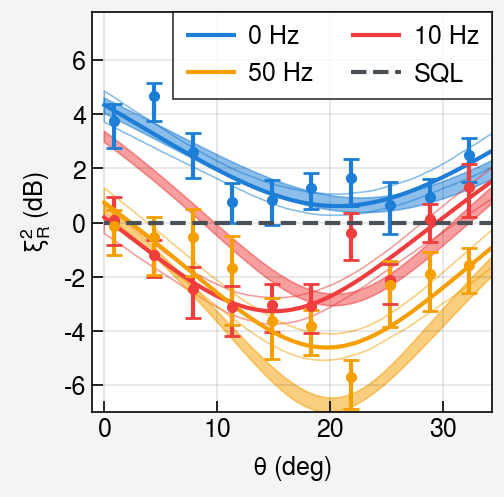

In [29]:
fig, ax = pplt.subplots([1], refwidth=2, refheight=2)

tidx = 3

popts = []
pcovs = []

xi2r_mu_all = []
xi2r_std_all = []

for i in range(3):
    c = COLORS[i]
    #ax.errorbar(360*rabi*x, xi2_all_t[i][tidx,:], yerr=xi2_all_std_t[i][tidx,:,:], fmt="o", 
    #            color=c)#, label=r'$t=%d$ Hz' % TUNNELINGS[i])

    print(tun_cs[i])
    
    xi2r_mu = []
    xi2r_std = []
    for pidx in range(len(xi2_all_bdists_t[i][tidx])):
        mu = xi2_all_t[i][tidx][pidx]/tun_cs[i][tidx]**2
        l, u = error_bar_percentile(xi2_all_bdists_t[i][tidx][pidx]/tun_cs_bdists[i][tidx]**2)
        xi2r_mu.append(mu)
        xi2r_std.append((mu - l, u - mu))
    xi2r_std = np.array(xi2r_std).T

    xi2r_mu_all.append(xi2r_mu)
    xi2r_std_all.append(xi2r_std)

    ax.errorbar(360*rabi*x, xi2r_mu, yerr=xi2r_std, fmt=".", 
                color=c)#, label=r'$t=%d$ Hz' % TUNNELINGS[i])
    
    #p0 = (0.002, -0.01)
    #popt, pcov, chisq = fit_curve(quad2, 360*rabi*x, xi2_all_t[i][tidx,:], np.mean(xi2_all_std_t[i][tidx,:,:], axis=0), p0, maxfev=8000)
    p0 = (20, 0.01, 0.5)
    popt, pcov, chisq = fit_curve(quad, 360*rabi*x, xi2r_mu, np.mean(xi2r_std, axis=0), p0, maxfev=80000)
    print(popt, pcov, chisq)
    fit_x = np.linspace(0, np.max(360*rabi*x) + 5, 1000)
    #ax.plot(fit_x, quad(fit_x, *popt), color=c, ls="--")
    
    fitl, fitu = fit_thick(quad, fit_x, popt, pcov, nsamples=1000)

    popts.append(popt)
    pcovs.append(pcov)
    print(popt)

    fit_mu = quad(fit_x, *popt)
    ax.plot(fit_x, fit_mu, color=c, label="%d Hz" % TUNNELINGS[i])
    ax.fill_between(fit_x, fitl, fitu, facecolor="none", edgecolor=c, alpha=0.5, ls="-")

    #if i < 3:
    stidx = np.argmin(np.abs(ts[tidx] - d_t[i]["dtwa"]["ts"]))
    #cstidx = np.argmin(np.abs(ts[tidx] - ds[i]["dtwa"]["ts"]))
    print("cs:", d_t[i]["dtwa"]["cs"][stidx])
    #print(d_t[i]["dtwa"]["cs_std"][stidx])
    dtwa_x = d_t[i]["dtwa"]["phis"]*180/np.pi
    dtwa_y = d_t[i]["dtwa"]["xi2rs"][stidx,:]#/ds[i]["dtwa"]["cs"][cstidx]**2
    dtwa_std = d_t[i]["dtwa"]["xi2rs_std"][stidx,:]#/ds[i]["dtwa"]["cs"][cstidx]**2
    #print(dtwa_y, dtwa_std)
    ax.fill_between(dtwa_x, dtwa_y - dtwa_std, dtwa_y + dtwa_std, color=COLORS[i], alpha=0.5)
    
    save_data_twosided("fig4_D_%dHz" % TUNNELINGS[i], 360*rabi*x, xi2r_mu, xi2r_std, "theta (deg)", "xi^2_R")
    
    #else:
    #    Ns = np.sum(d["occs_all_sites"], axis=(0,1,2))
    #    oat_chis = chi_oat(d["occs_all_sites"])
    #    oat_xi2 = oat_squeezing(oat_chis, ts[tidx], Ns)
    #    oat_xi2_mu = np.mean(oat_xi2)
    #    oat_xi2_std = scipy.stats.sem(oat_xi2)
    #    print(oat_xi2_mu)
        #ax.fill_between(oat_ts, oat_xi2s_mu - oat_xi2s_std, oat_xi2s_mu + oat_xi2s_std, alpha=0.5, color=COLORS[i],
        #                  hatch="//")

dBs = np.arange(-6, 8, 2)

ax.plot([np.min(fit_x), np.max(fit_x)], [1, 1], color="grey7", ls="--", label="SQL")

ax.format(xlabel=r'$\theta$ (deg)', ylabel=r'$\xi^2_R$ (dB)', yscale="log", tickdir="in",
            xlim=(360*rabi*np.min(x) - 2, 360*rabi*np.max(x) + 2), ylim=(0.2, 6),
          #title=r'$\tau=%.2f$ s' % ts[tidx],
          ylocator=np.power(10, dBs/10), yformatter=[ "%d" % dB for dB in dBs ],
         yminorlocator="null", yminorticks=[], xminorticks=[])
    
ax.legend(ncols=2)

fig.savefig("figures/tunneling_squeezing_xi2r.pdf")
fig.savefig("figures/tunneling_squeezing_xi2r.png", dpi=300)

# Correlations

In [30]:
from matplotlib.colors import Normalize, SymLogNorm

# vmin must be negative, vmax must be positive
class corrs_norm(Normalize):
    def __init__(self, vmin, vmax, linear_cutoff, linear_regime = 0.1):
        self.vmin = vmin
        self.vmax = vmax
        self.linear_regime = linear_regime
        self.linear_cutoff = linear_cutoff
        Normalize.__init__(self, vmin, vmax, clip=False)

    def __call__(self, vv, clip=None):
        if isinstance(vv, float):
            return self.call(vv)
            
        return np.ma.array([ self.call(v) for v in vv.flatten() ]).reshape(vv.shape)

    def call(self, v):
        if np.abs(v) < self.linear_cutoff:
            return 0.5 + self.linear_regime*v/self.linear_cutoff
    
        if v > 0:
            return 0.5 + self.linear_regime + (0.5 - self.linear_regime)*\
                (np.log(v) - np.log(self.linear_cutoff))/(np.log(self.vmax) - np.log(self.linear_cutoff))
    
        return 0.5 - self.linear_regime - (0.5 - self.linear_regime)*\
            (np.log(-v) - np.log(self.linear_cutoff))/(np.log(-self.vmin) - np.log(self.linear_cutoff))

N_clip: (83.0, 99.0)  min_fill: 0.019125000000000003
<N>: 91.29636048526864


/tmp/ipykernel_21350/932470463.py:2: RuntimeWarning: invalid value encountered in divide
  moccs = np.sum(dN, axis=-1)/np.sum(np.abs(dN), axis=-1)
/tmp/ipykernel_21350/932470463.py:4: RuntimeWarning: invalid value encountered in divide
  corrs = np.einsum("ijn,abn->ijab", dN, dN)/np.einsum("ijn,abn->ijab", np.abs(dN), np.abs(dN)) \
/tmp/ipykernel_21350/932470463.py:2: RuntimeWarning: invalid value encountered in divide
  moccs = np.sum(dN, axis=-1)/np.sum(np.abs(dN), axis=-1)


xi2: -1.093053880578955 dB
-0.2566588067610357 0.012359593859756471


/tmp/ipykernel_21350/932470463.py:4: RuntimeWarning: invalid value encountered in divide
  corrs = np.einsum("ijn,abn->ijab", dN, dN)/np.einsum("ijn,abn->ijab", np.abs(dN), np.abs(dN)) \


xi2: 2.7658312444463355 dB
-0.011518781392153406 0.3520941148737129
N_clip: (87.0, 105.0)  min_fill: 0.028499999999999998
<N>: 96.21821305841924


/tmp/ipykernel_21350/932470463.py:2: RuntimeWarning: invalid value encountered in divide
  moccs = np.sum(dN, axis=-1)/np.sum(np.abs(dN), axis=-1)
/tmp/ipykernel_21350/932470463.py:4: RuntimeWarning: invalid value encountered in divide
  corrs = np.einsum("ijn,abn->ijab", dN, dN)/np.einsum("ijn,abn->ijab", np.abs(dN), np.abs(dN)) \
/tmp/ipykernel_21350/932470463.py:2: RuntimeWarning: invalid value encountered in divide
  moccs = np.sum(dN, axis=-1)/np.sum(np.abs(dN), axis=-1)


xi2: -1.6647630943303557 dB
-0.07021964561987319 0.000826743562424289


/tmp/ipykernel_21350/932470463.py:4: RuntimeWarning: invalid value encountered in divide
  corrs = np.einsum("ijn,abn->ijab", dN, dN)/np.einsum("ijn,abn->ijab", np.abs(dN), np.abs(dN)) \


xi2: 3.6813710060535954 dB
0.0 0.09387634679405953
N_clip: (96.0, 124.0)  min_fill: 0.0305
<N>: 109.1761658031088


/tmp/ipykernel_21350/932470463.py:2: RuntimeWarning: invalid value encountered in divide
  moccs = np.sum(dN, axis=-1)/np.sum(np.abs(dN), axis=-1)
/tmp/ipykernel_21350/932470463.py:4: RuntimeWarning: invalid value encountered in divide
  corrs = np.einsum("ijn,abn->ijab", dN, dN)/np.einsum("ijn,abn->ijab", np.abs(dN), np.abs(dN)) \
/tmp/ipykernel_21350/932470463.py:2: RuntimeWarning: invalid value encountered in divide
  moccs = np.sum(dN, axis=-1)/np.sum(np.abs(dN), axis=-1)


xi2: -2.215411668279771 dB
-0.01699280556835587 0.005807925964337162


/tmp/ipykernel_21350/932470463.py:4: RuntimeWarning: invalid value encountered in divide
  corrs = np.einsum("ijn,abn->ijab", dN, dN)/np.einsum("ijn,abn->ijab", np.abs(dN), np.abs(dN)) \


xi2: 2.5906316021584423 dB
-0.01004690625876568 0.01758778630366471


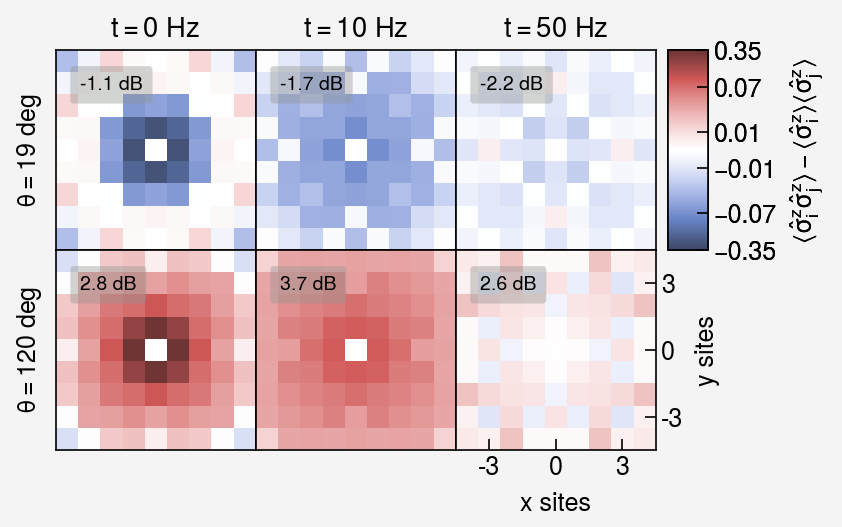

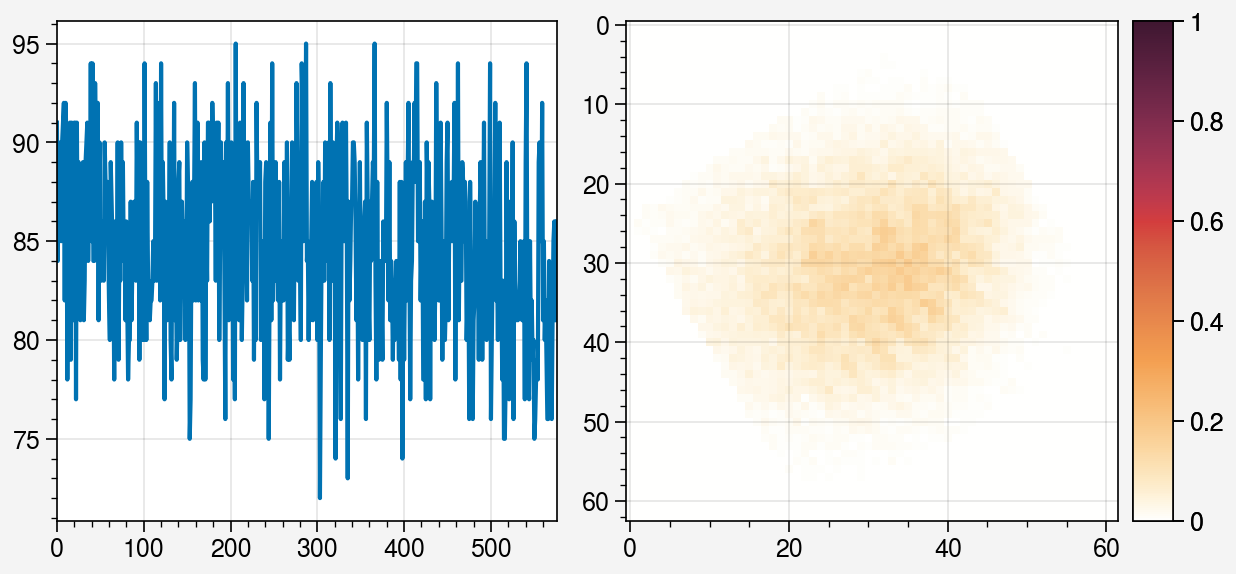

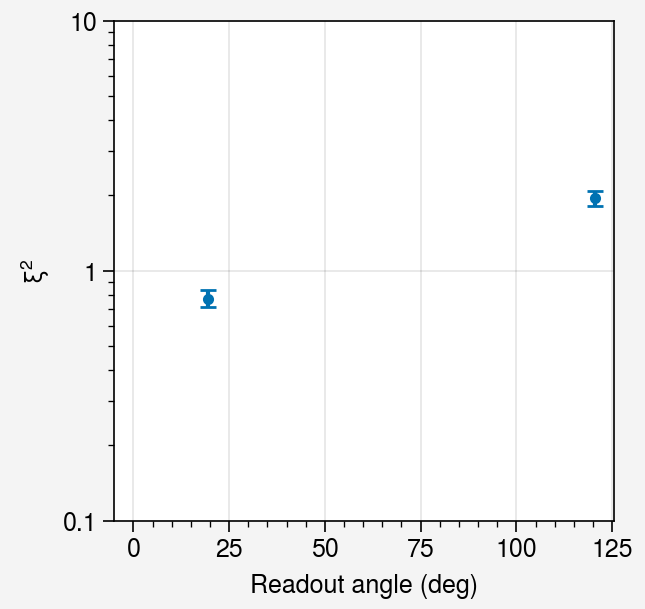

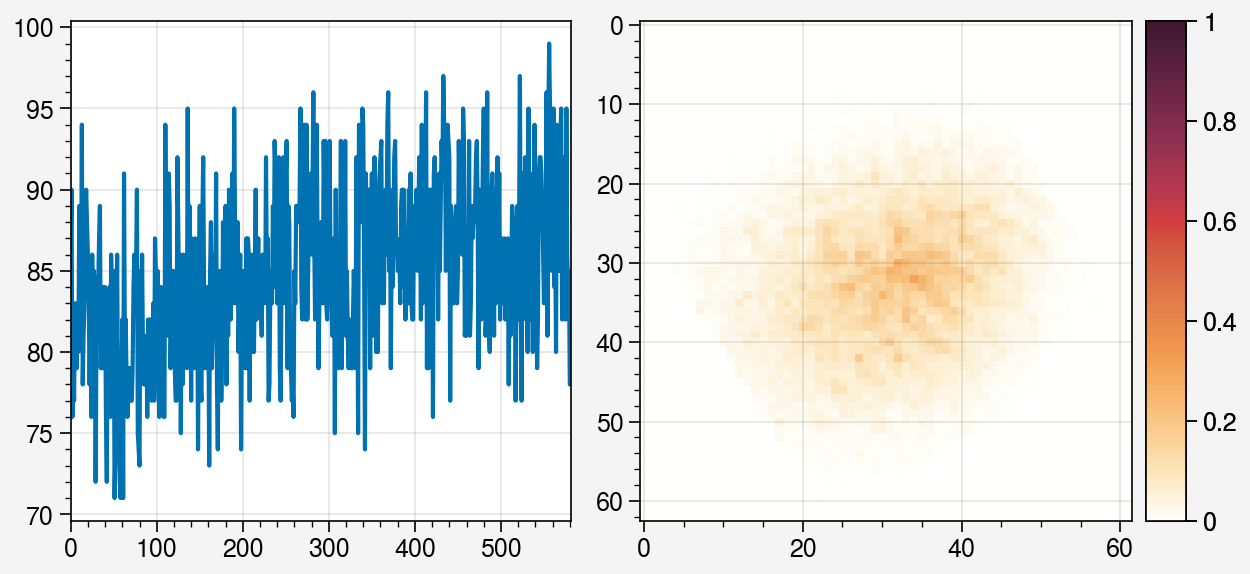

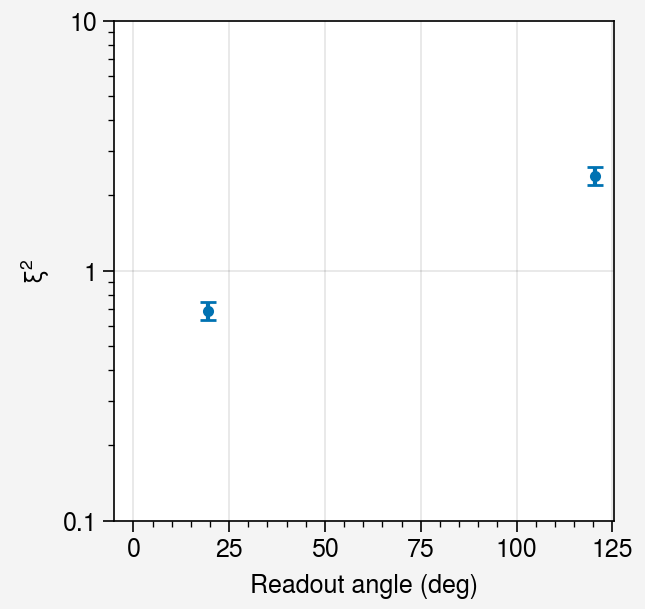

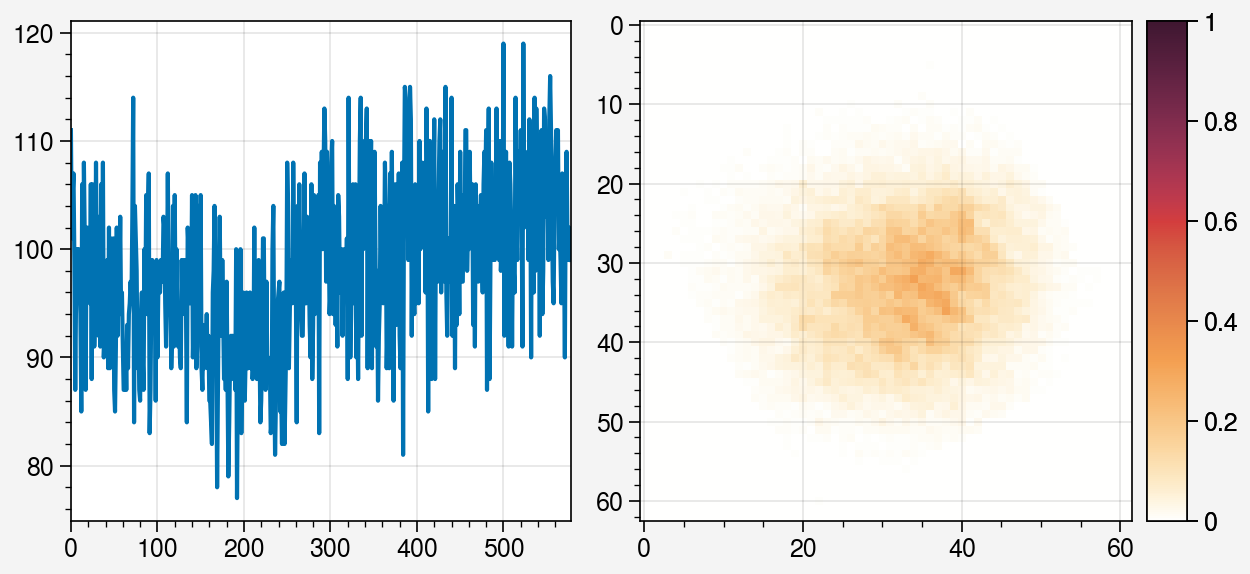

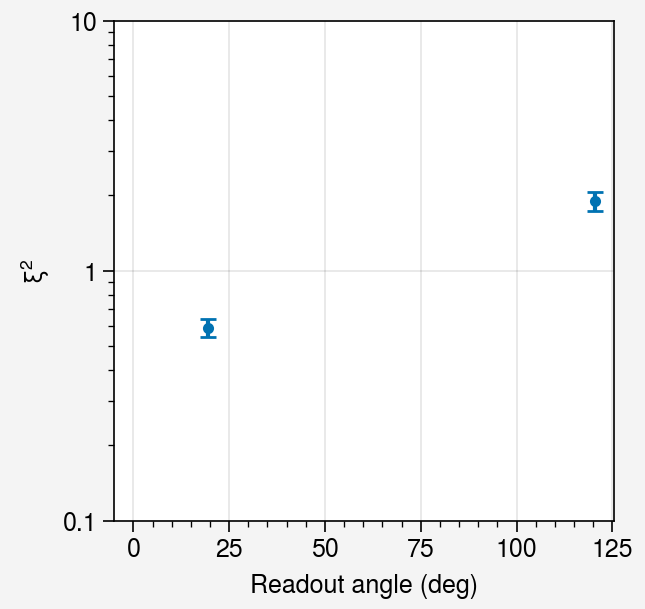

In [32]:
dirs = ['./data/2024/03/20', './data/2024/03/19', './data/2024/03/18']
scans = [156, 138, 111]

xa, xb = 10, 50
ya, yb = 10, 50
n = 9
sym = True
vmax = 0.35
vmin = -0.35
linear_cutoff = 0.01
linear_regime = 0.3
rabi = 800 # TODO

fig, ax = pplt.subplots([[1,2,3],[4,5,6]], space=0, share=False, refwidth=1)

for i in range(3):
    d = analyze(dirs[i], scans[i],
                     sum_spindown=True,
                     ratio_clip=(-0.5, 0.5),
                     double="none")

    x, y_mean, y_std, all_s, _ = get_squeezing(d, None, rabi, bootstrap=False)

    all_phis = np.array(d["variable_values"]["MicrowavePulseSweepVar"])
    phis = np.unique(all_phis)

    xi2_all = np.array(y_mean)
    
    for pidx in range(2):
        dNs = d["dN"][:,:,all_phis == phis[pidx]][xa:xb,ya:yb]
        Ns = np.sum(d["occs"], axis=0)[:,:,all_phis == phis[pidx]][xa:xb,ya:yb]
        corrs_slice, corrs_slice_std, corrs = get_avg_corrs(dNs, n, symmetrize=sym)

        xi2 = np.var(np.sum(dNs, axis=(0,1))/np.sqrt(np.sum(Ns, axis=(0,1))), ddof=1)
        
        imdata = np.copy(np.flip(np.flip(corrs_slice, axis=0), axis=1))
        #imdata[0,-1] = np.sum(corrs)
        #print(imdata[0,-1])

        print("xi2:", 10*np.log10(xi2), "dB")
        
        print(np.min(imdata), np.max(imdata))

        ax[i + 3*pidx].text(0.6, n - 2.3, "%.1f dB" % (10*np.log10(xi2)), fontsize=7,
                            bbox=dict(facecolor="grey", alpha=0.4, edgecolor="none", boxstyle="round, rounding_size=0.2, pad=0.5",))
        
        c = ax[i + 3*pidx].imshow(imdata, cmap="div", vmin=vmin, vmax=vmax, origin="lower",
                                  norm=SymLogNorm(linthresh=linear_cutoff, linscale=linear_regime,
                                              vmin=vmin, vmax=vmax, base=10))
                                  #norm=corrs_norm(vmin, vmax, linear_cutoff, linear_regime=linear_regime))
        ax[i + 3*pidx].format(grid=False, xticks=[], xminorticks=[], yticks=[], yminorticks=[])
        if i == 2 and pidx == 1:
            ax[i + 3*pidx].format(xticks=range(1,n,3), xticklabels=[ "%d" % (i - n//2) for i in range(1,n,3) ], xminorticks=[],
                         yticks=range(1,n,3), yticklabels=[ "%d" % (i - n//2) for i in range(1,n,3) ], yminorticks=[], ytickloc="right",
                                 tickdir="in", xlabel="x sites", ylabel="y sites")
        
        save_data("fig4_E_%dHz_%ddeg" % (TUNNELINGS[i], np.round(phis[pidx]*2*np.pi*rabi*180/np.pi)), imdata, ",".join([str(i) for i in list(range(imdata.shape[0])) ]))

    
    ax[i].format(title=r'$t=%d$ Hz' % TUNNELINGS[i])

for i in range(2):
    ax[3*i].format(ylabel=r'$\theta=%d$ deg' % np.round(phis[i]*2*np.pi*rabi*180/np.pi))

cbar = ax[2].colorbar(c, ticks=[vmin, vmin/5, -linear_cutoff, linear_cutoff, vmax/5, vmax], tickdir="in")
cbar.set_label(r'$\langle \hat{\sigma}^z_{i}\hat{\sigma}^z_{j}\rangle-\langle \hat{\sigma}^z_i \rangle \langle\hat{\sigma}^z_j\rangle$')

evt = 0.2
#fig.format(suptitle=r'$\langle Z_iZ_j\rangle -\langle Z_i\rangle\langle Z_j\rangle$ after $\tau=%.2f$ s' % evt)
fig.savefig("figures/tunneling_corrs.svg", dpi=300)
fig.savefig("figures/tunneling_corrs.png", dpi=300)

## High squeezing

In [22]:
dtwaharmonic=1e-3
pi_time = 0.0666667

dtwapulses = [ (pi_time*(i+0.5), 0, (-1)**i*0.5) for i in range(10) ]

N_clip: (448.0, 493.0)  min_fill: 0.08895833333333333
<N>: 472.26271186440675
center: [30.5 30.5]


Output()

  0%|          | 0/10 [00:00<?, ?it/s]

Calculating xi^2


  0%|          | 0/10 [00:00<?, ?it/s]

Ns in analyze: [450 456 449 431 450 461 451 433 456 464]


/home/vassilios/anaconda3/envs/tf/lib/python3.10/site-packages/erbium_analysis_modules/dtwa_module.py:143: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = axs[0].pcolormesh(Ts, Phis*180/np.pi, 10*np.log10(np.mean(xi2s, axis=0)))


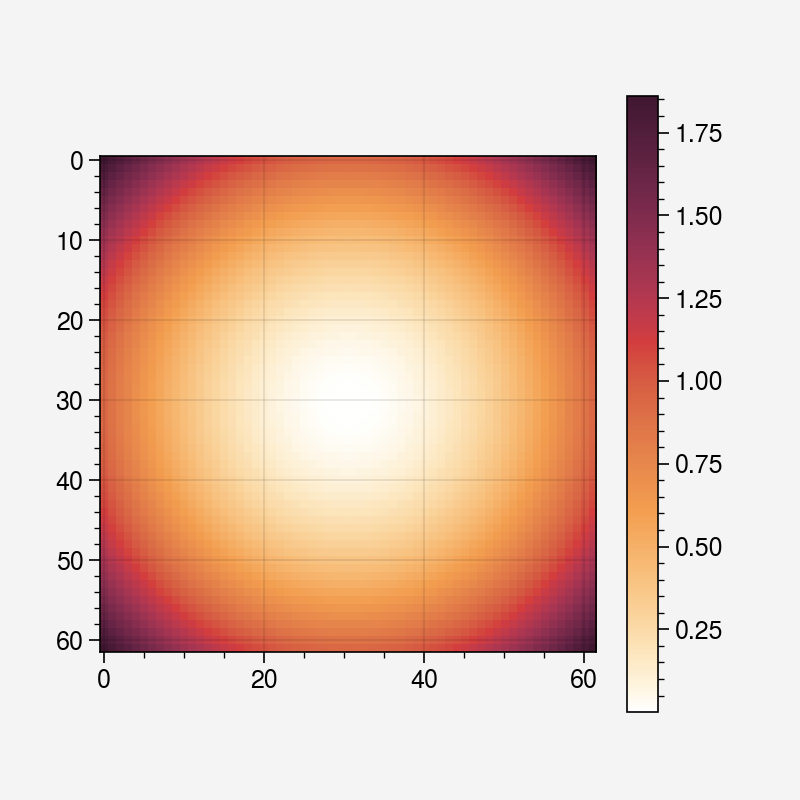

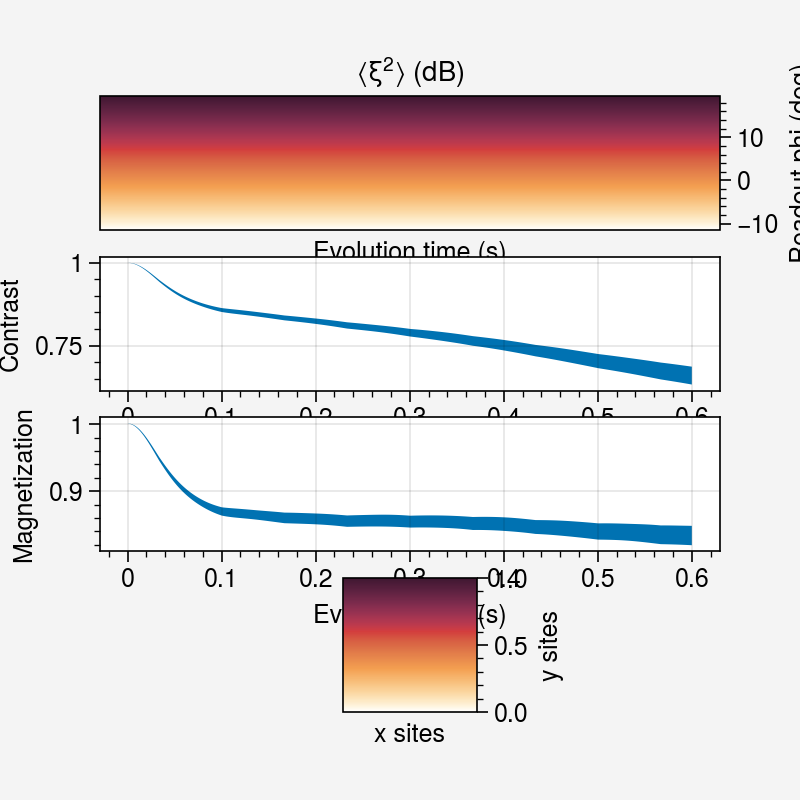

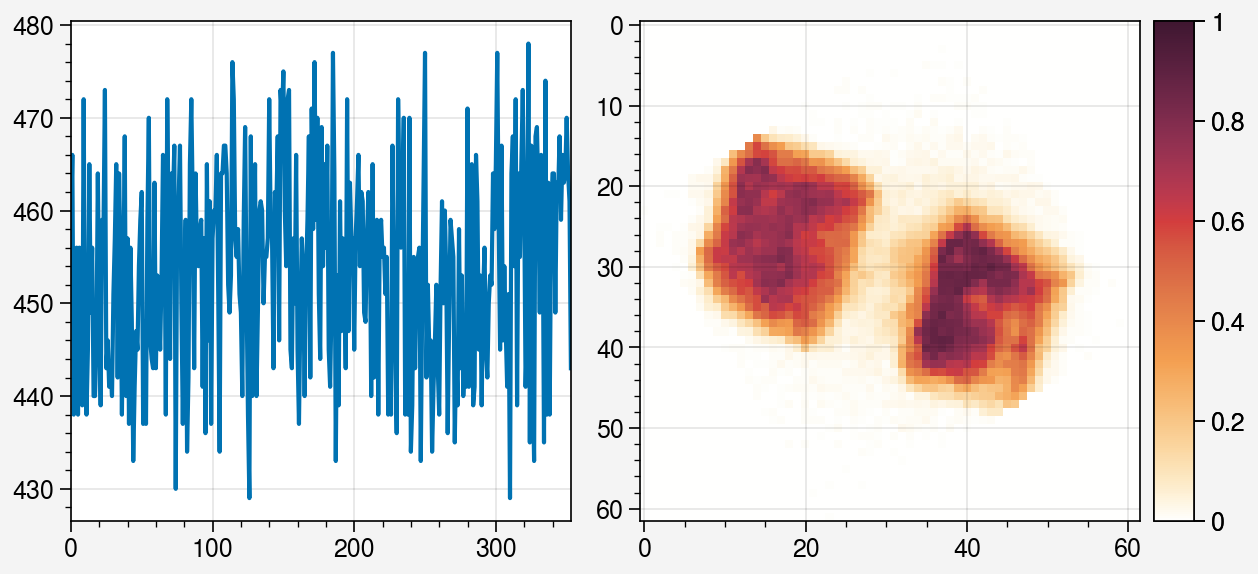

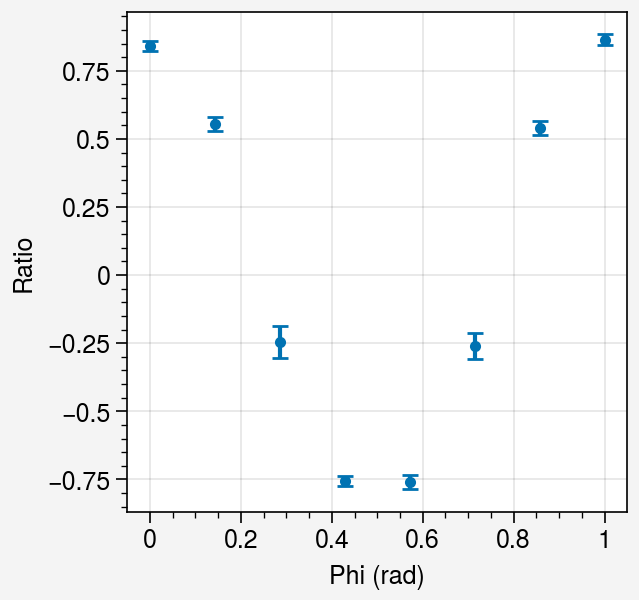

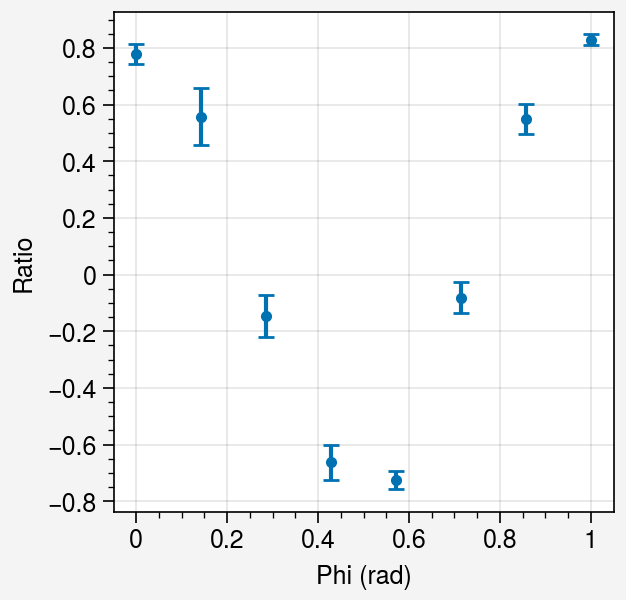

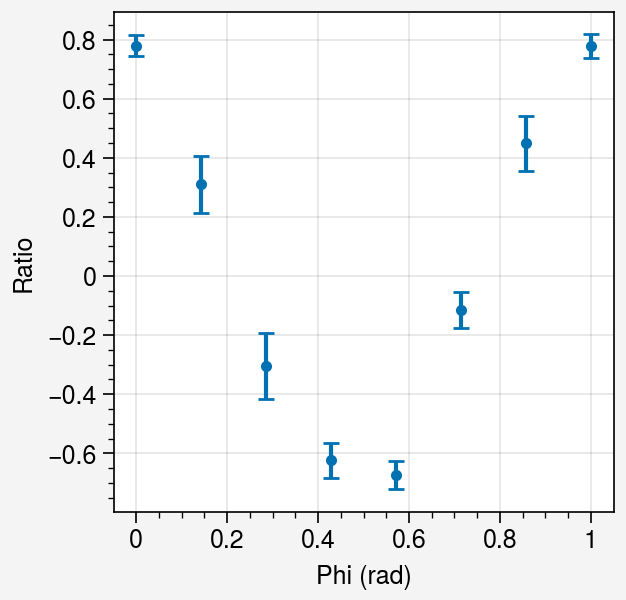

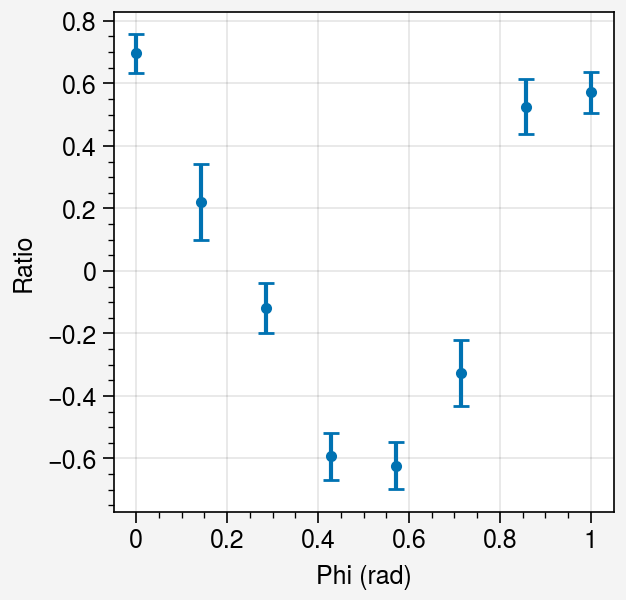

In [23]:
d_coh = analyze('./data/2024/03/17', 58, sum_spindown=True, double="none",
            maxr=62, maxc=62, dtwaprefix="highsqueezingcontrast_harm2", dtwaharmonic=dtwaharmonic, dtwapulses=dtwapulses)
all_ts = np.array(d_coh["variable_values"]["MicrowavePulseSweepVar2"])
ts = np.unique(all_ts)

n_bootstrap_resamples = 500

cs = []
cs_std = []
c_xs = []
c_ys = []
c_y_stds = []
c_popts = []
c_pstds = []
c_pbdists = []
for j, t in enumerate(ts):
    (x, y, y_std), (popt, pstd, pbdist), chisq, _ = get_contrast(d_coh, all_ts == t, bootstrap=True, ret_pbdist=True,
                                                                 n_bootstrap_resamples=n_bootstrap_resamples)

    c_xs.append(x)
    c_ys.append(y)
    c_y_stds.append(y_std)
    c_popts.append(popt)
    c_pstds.append(pstd)
    c_pbdists.append(pbdist)
    
    cs.append(popt[0])
    cs_std.append(pstd[0])

#plot_occs(ax[2+i], d, vmax)

In [ ]:
show_doublons(d_coh, all_ts)

Rabi: 803.2128514056225
N_clip: (495.0, 552.0)  min_fill: 0.07906687402799378


/tmp/ipykernel_133891/2374282933.py:50: RuntimeWarning: invalid value encountered in divide
  ratio = (spinup - spindown)/N


center: [30.5 30. ]


Output()

  0%|          | 0/10 [00:00<?, ?it/s]

Calculating xi^2


  0%|          | 0/10 [00:00<?, ?it/s]

Ns in analyze: [[232 242]
 [228 248]
 [221 256]
 [225 293]
 [233 275]
 [221 265]
 [226 291]
 [232 267]
 [256 250]
 [232 275]]


/home/vassilios/anaconda3/envs/tf/lib/python3.10/site-packages/erbium_analysis_modules/dtwa_module.py:143: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = axs[0].pcolormesh(Ts, Phis*180/np.pi, 10*np.log10(np.mean(xi2s, axis=0)))


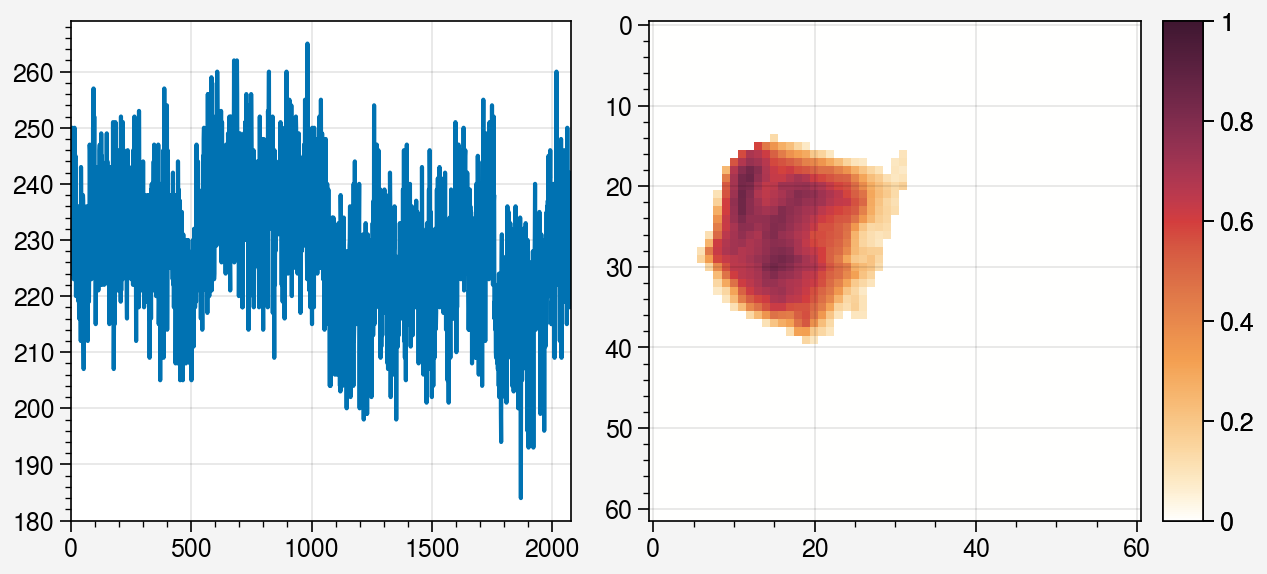

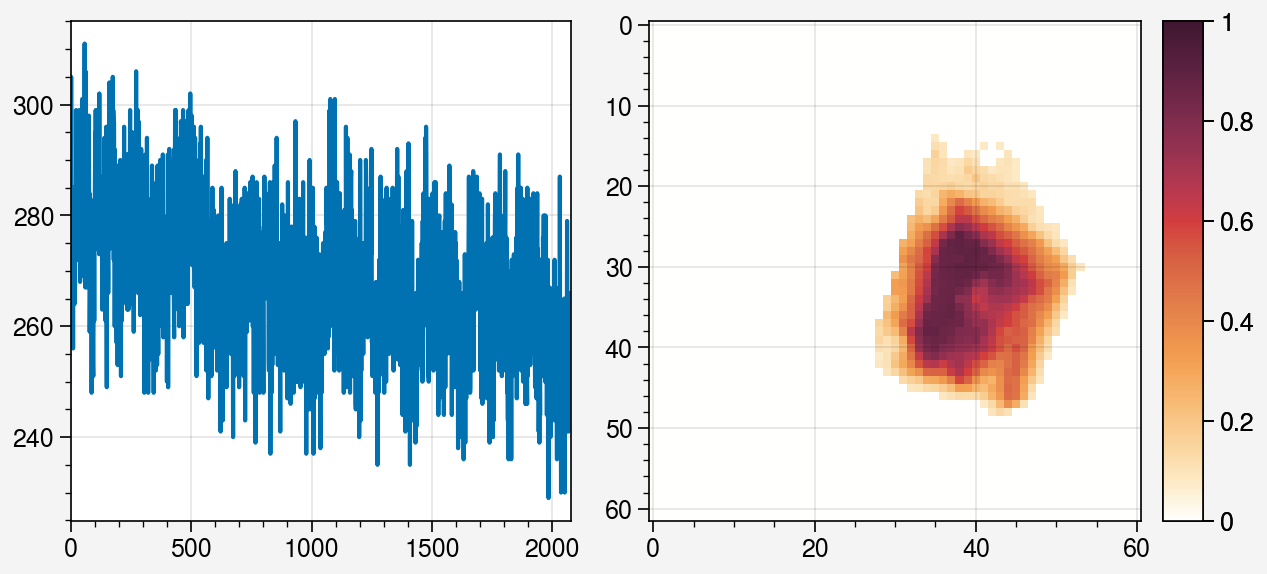

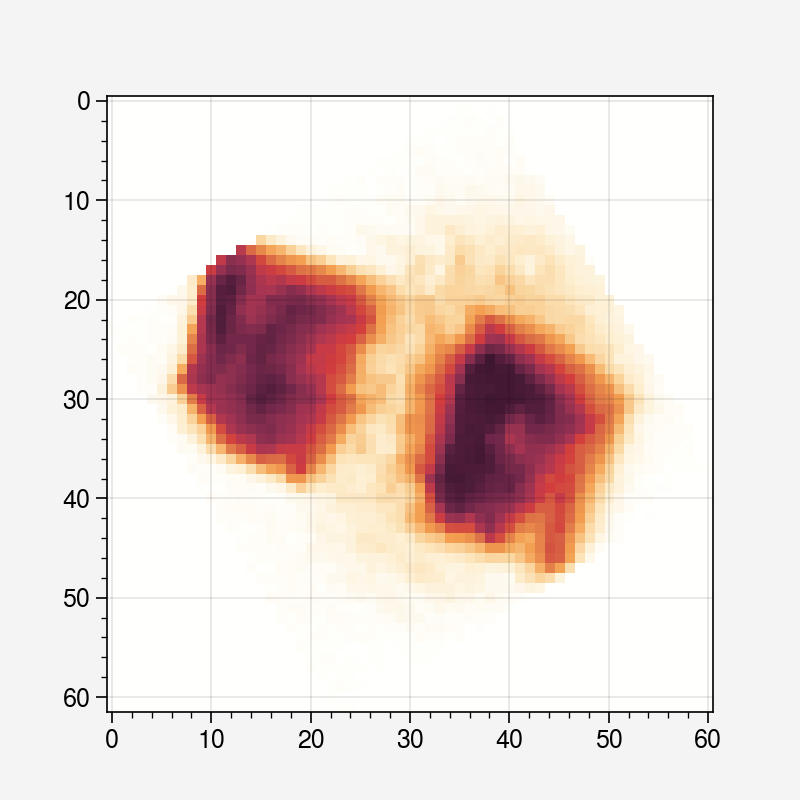

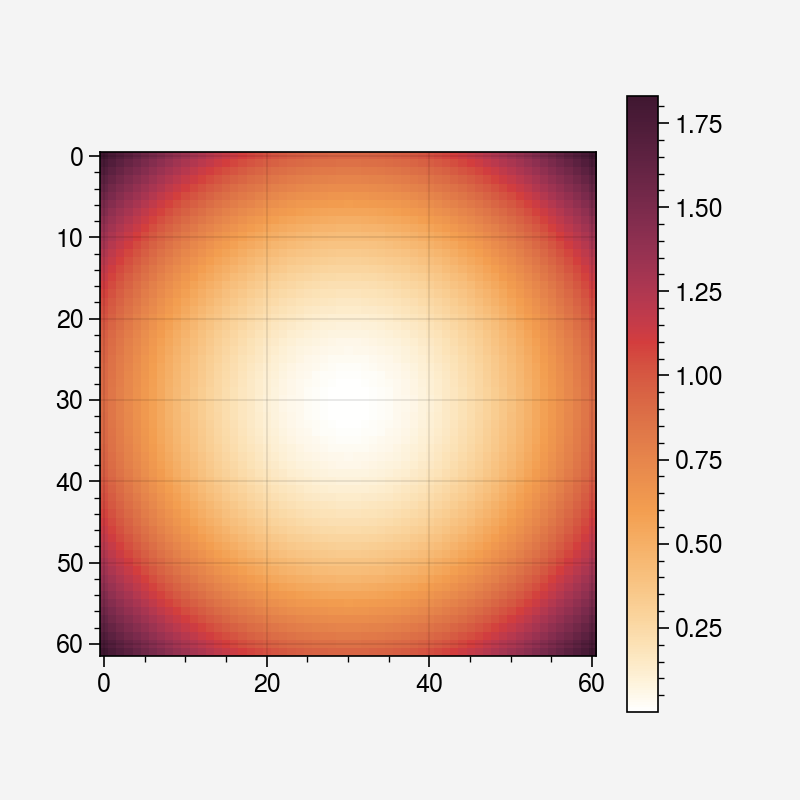

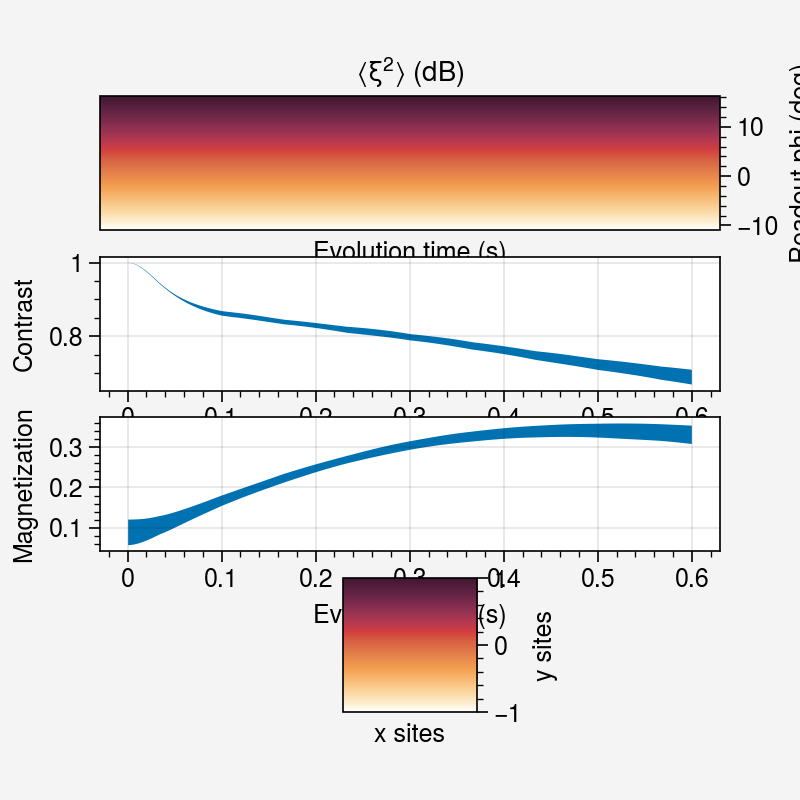

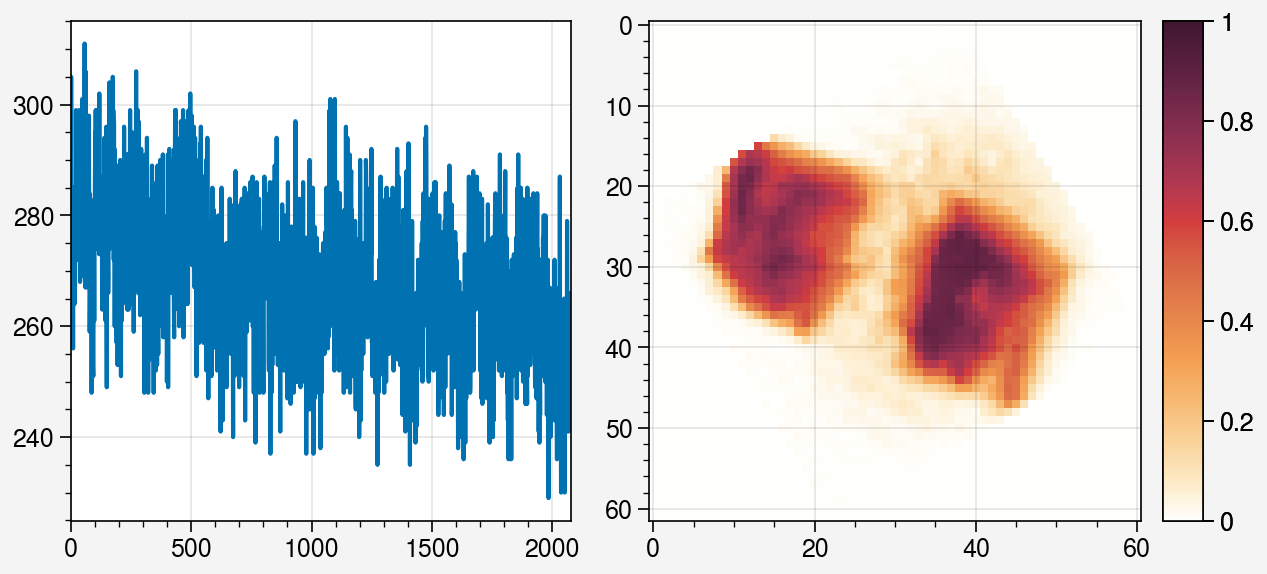

In [24]:
rabi = 0.5/0.6225e-3
print("Rabi:", rabi)

xa, xb = 10, 50
ya, yb = 10, 50
corrs_pidxs = [3, -1]
corrs_tidx = 1
corrs_n = 9
corrs_sym = True

d = analyze_diff('./data/2024/02/10', [68,69], reg_slope=-0.3, transpose=False, 
                 reg_cutoffs=(37, 39), sum_spindown=True, double="none", maxr=62, maxc=62,
                 dtwaprefix="highsqueezing_harm2", dtwaharmonic=1e-3, dtwapulses=dtwapulses)

all_phis = np.array(d[0]["variable_values"]["MicrowavePulseSweepVar"])
phis = np.unique(all_phis)

all_ts = np.array(d[0]["variable_values"]["MicrowavePulseSweepVar2"])
ts = np.unique(all_ts)

/tmp/ipykernel_133891/932470463.py:2: RuntimeWarning: invalid value encountered in divide
  moccs = np.sum(dN, axis=-1)/np.sum(np.abs(dN), axis=-1)
/tmp/ipykernel_133891/932470463.py:4: RuntimeWarning: invalid value encountered in divide
  corrs = np.einsum("ijn,abn->ijab", dN, dN)/np.einsum("ijn,abn->ijab", np.abs(dN), np.abs(dN)) \


Fitted squeezing: -7.07854558897123 +/- 0.9597017234618287 dB
chisq: 0.8609645041559721


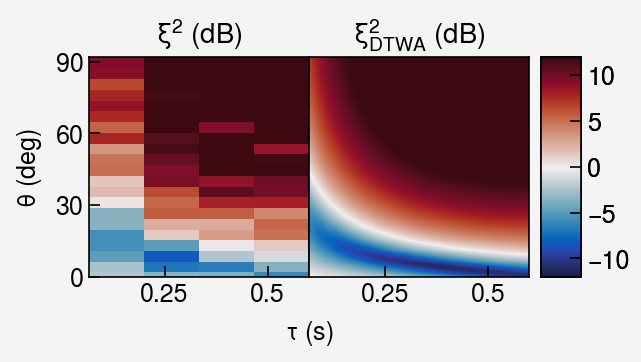

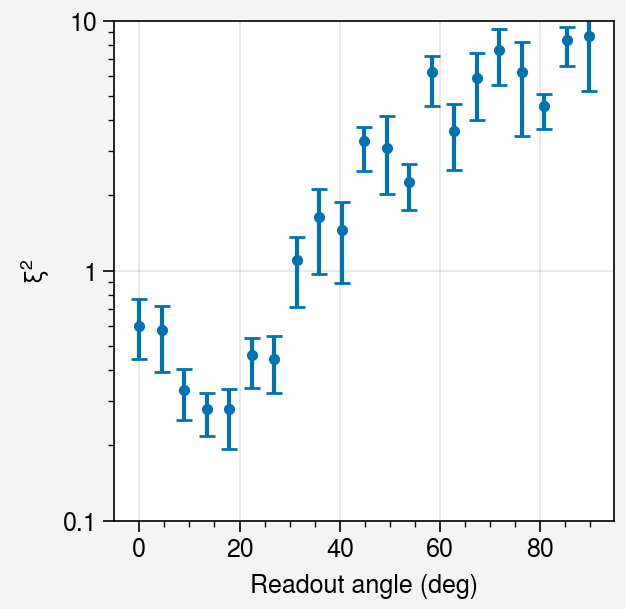

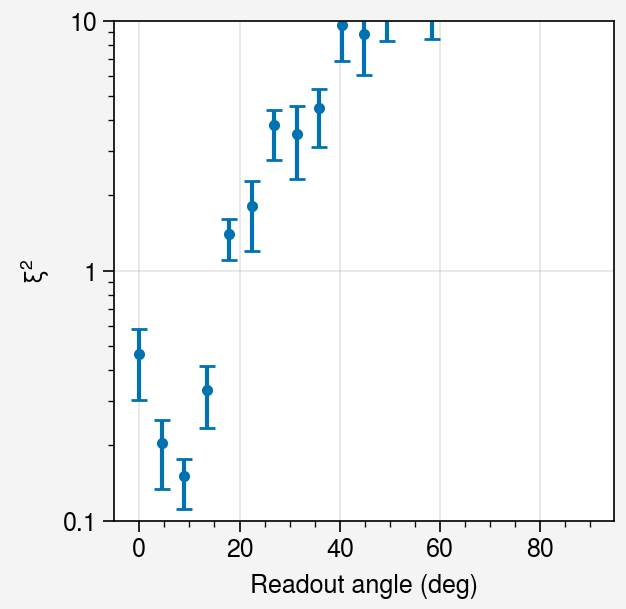

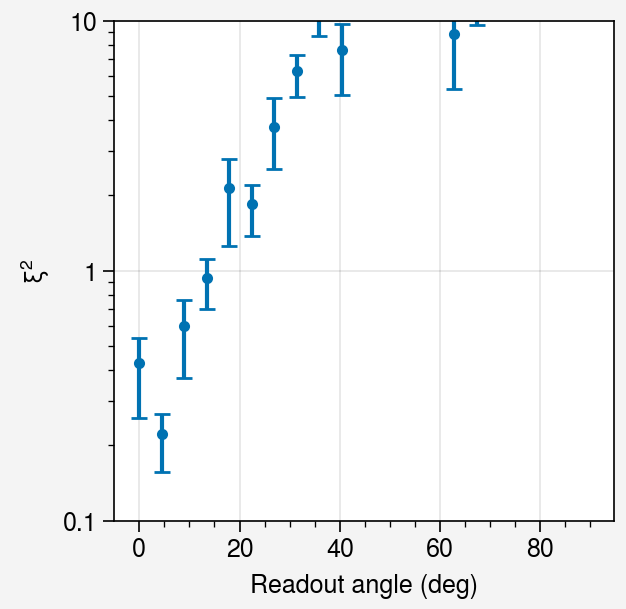

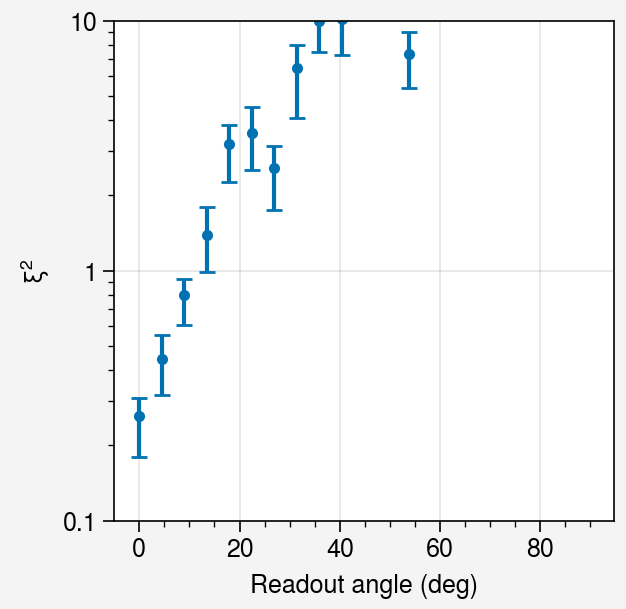

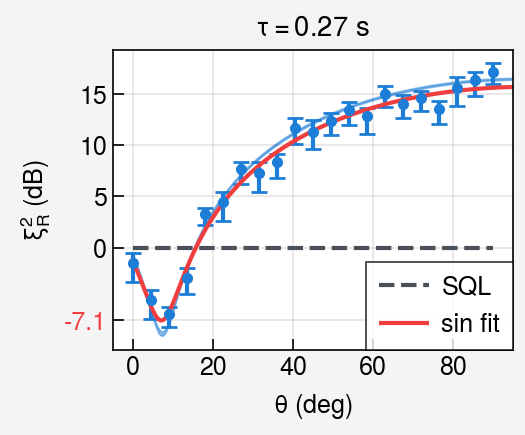

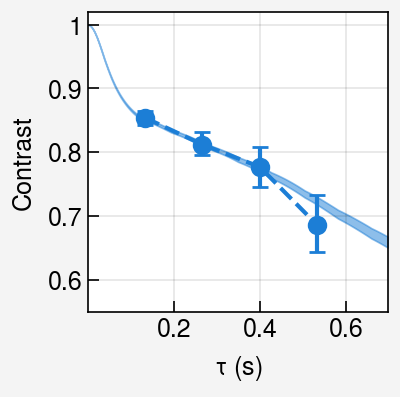

In [25]:
fig, ax = pplt.subplots([1,2], wspace=[0], sharex=True, sharey=False, refwidth=1.1)

xi2_all = []
xi2_std_all = []
all_ss = []
bdists_all = []
for ti, t in enumerate(ts):
    x, y_mean, y_std, all_s, bdists = get_squeezing_diff(d, all_ts == t, rabi, beta=1, n_bootstrap_resamples=n_bootstrap_resamples)
    xi2_all.append(y_mean)
    xi2_std_all.append(y_std)
    all_ss.append(all_s)
    bdists_all.append(bdists)
    
    save_data_twosided("fig3_C_t%.3fs" % t, x*2*np.pi*rabi*180/np.pi, y_mean, y_std, "theta (deg)", "xi^2")
    
corrs_slices = [
    get_avg_corrs(sum([ d[i]["dN"][:,:,(all_phis == phis[corrs_pidx])][xa:xb,ya:yb] for i in range(2) ]), 
                    corrs_n, symmetrize=corrs_sym)[0]
    for corrs_pidx in corrs_pidxs ]
    
xi2_all = np.array(xi2_all)
xi2_std_all = np.array(xi2_std_all)

dbmin = -12
c = plot_xi2(ax[0], xi2_all, ts, x, rabi, dbmin=dbmin)
plot_xi2_sim(ax[1], d[0], ts, x, rabi, dbmin=dbmin)

ax[0].format(xlabel=r'$\tau$ (s)', ylabel=r'$\theta$ (deg)', title=r'$\xi^2$ (dB)', yticks=np.arange(0, 100, 30), xminorticks=[], yminorticks=[], tickdir="in")
ax[1].format(title=r'$\xi^2_{\mathrm{DTWA}}$ (dB)', yticks=[], yminorticks=[], xminorticks=[], tickdir="in")
ax[1].colorbar(c, tickdir="in")

fig.savefig("figures/highsqueezing_xi.pdf", dpi=300)

c = COLORS[0]
tidx = 1
xi2r_mu = []
xi2r_std = []
for pidx in range(len(bdists_all[0])):
    mu = xi2_all[tidx][pidx]/cs[tidx]**2
    l, u = error_bar_percentile(bdists_all[tidx][pidx]/c_pbdists[tidx]**2)
    xi2r_mu.append(mu)
    xi2r_std.append((mu - l, u - mu))
xi2r_std = np.array(xi2r_std).T


p0 = (1/180, 0.15, 50, -np.pi/2)
#fit_squeeze(x, f, s, a, p):
popt, pcov, chisq = fit_curve(fit_squeeze, 360*rabi*x, xi2r_mu, np.mean(xi2r_std, axis=0), p0)
print("Fitted squeezing:", 10*np.log10(popt[1]), "+/-", (10/np.log(10))*pcov[1,1]**0.5/popt[1], "dB")
print("chisq:", chisq)

minxi2r = 10*np.log10(popt[1])
dBs = np.array([-10, minxi2r, 0, 5, 10, 15])
minordBs = np.array([-10, -5, -2.5, 0, 2.5, 5, 7.5])

fig, ax = pplt.subplots([1], wspace=[None], share=False, refwidth=2, refheight=1.5)

ax.errorbar(360*rabi*x, xi2r_mu, yerr=xi2r_std, fmt=".", color=c)
ax.plot([np.min(360*rabi*x), np.max(360*rabi*x)], [1, 1], color="grey7", ls="--", label="SQL")
ax.format(xlabel=r'$\theta$ (deg)', ylabel=r'$\xi^2_R$ (dB)', title=r'$\tau=%.2f$ s' % ts[tidx], yscale="log",
            xlim=(360*rabi*np.min(x) - 5, 360*rabi*np.max(x) + 5), xminorticks=[], tickdir="in",
            ylocator=np.power(10, dBs/10), yformatter=[ ("%d" % dB if dB != minxi2r else "%.1f" % dB) for dB in dBs ], 
                 yminorticks=[])
          #yminorlocator=np.power(10, minordBs/10))

save_data_twosided("fig3_E", 360*rabi*x, xi2r_mu, xi2r_std, "theta (deg)", "xi^2_R")
    
stidx = np.argmin(np.abs(ts[tidx] - d[0]["dtwa"]["ts"]))
ax.fill_between(d[0]["dtwa"]["phis"]*180/np.pi, 
                   (d[0]["dtwa"]["xi2rs"] - d[0]["dtwa"]["xi2rs_std"])[stidx,:],
                   (d[0]["dtwa"]["xi2rs"] + d[0]["dtwa"]["xi2rs_std"])[stidx,:],
                   color=c, alpha=0.5) 

fit_x = np.linspace(0, np.max(360*rabi*x) + 5, 1000)
#ax.plot(fit_x, quad(fit_x, *popt), color=c, ls="--")

#c2 = COLORS[1]
fitl, fitu = fit_thick(fit_squeeze, fit_x, popt, pcov, nsamples=1000)
fit_mu = fit_squeeze(fit_x, *popt)
ax.plot(fit_x, fit_mu, color=COLORS[1], label="sin fit")
#ax.fill_between(fit_x, fitl, fitu, facecolor="none", edgecolor=c, alpha=0.5, ls="-")

ax.legend(ncols=1, loc="lr")

ax.get_yticklabels()[1].set_color(COLORS[1])
ax.yaxis.get_major_ticks()[1].color = COLORS[1]

"""
ix = ax[3].inset(
    [40, 0.15, 50, 1.5], transform='data', zoom=False,
)
s_pidx = 2
s = all_ss[tidx][s_pidx]
counts, bins, patches = ix.hist(s, bins=5, alpha=0.9, color=COLORS[0])
sql_x = np.linspace(-3, 3, 1000)
sigma = np.sqrt(xi2_all[tidx][s_pidx])
ix.plot(sql_x + np.mean(s), (len(s)*(bins[1] - bins[0]))*(1/(np.sqrt(2*np.pi)*sigma))*np.exp(-sql_x**2/(2*sigma**2)), 
            "--", alpha=0.7, color=COLORS[1])
ix.plot(sql_x + np.mean(s), (len(s)*(bins[1] - bins[0]))*(1/np.sqrt(2*np.pi))*np.exp(-sql_x**2/2), 
            "--", alpha=0.7, label="SQL", color=COLORS[2])
ix.format(tickdir="in", xtickloc="top", ylabel="Counts", xlabel=r'$S_z/\sqrt{N/4}$', xminorticks=[], yminorticks=[])
"""

fig.savefig("figures/highsqueezing_xir.pdf", dpi=300)

fig, ax = pplt.subplots([1], wspace=[None], share=False, refwidth=1.5)

c = COLORS[0]
ax.errorbar(ts, cs, yerr=np.array(cs_std).T, fmt="o", ls="--", color=c)
ax.fill_between(d_coh["dtwa"]["ts"], d_coh["dtwa"]["cs"] - d_coh["dtwa"]["cs_std"], 
                   d_coh["dtwa"]["cs"] + d_coh["dtwa"]["cs_std"], 
                   alpha=0.5, color=c, edgecolor=c)
ax.format(xlabel=r'$\tau$ (s)', ylabel="Contrast", ylim=(0.55, 1.02), xminorticks=[], yminorticks=[], tickdir="in")

save_data_twosided("fig3_D", ts, cs, np.array(cs_std).T, "tau (sec)", "Contrast")

"""
Ns = np.sum(d_coh["occs_all_sites"], axis=(0,1,2))
oat_ts = np.linspace(0, 1, 1000)
oat_chis = chi_oat(d_coh["occs_all_sites"])
oat_contrasts = oat_contrast(np.expand_dims(oat_chis, 0), np.expand_dims(oat_ts, 1), np.expand_dims(Ns, 0))
oat_contrasts_mu = np.mean(oat_contrasts, axis=1)
oat_contrasts_std = scipy.stats.sem(oat_contrasts, axis=1)
ax.fill_between(oat_ts, oat_contrasts_mu - oat_contrasts_std, oat_contrasts_mu + oat_contrasts_std, alpha=0.5, color=COLORS[1])


ix = ax[0].inset(
    [0.06, 0.53, 0.28, 0.13], transform='data', zoom=False,
)
ci = 1
c_fit_x = np.linspace(0, 1, 1000)
ix.errorbar(c_xs[ci]*2*np.pi, c_ys[ci], yerr=c_y_stds[ci], fmt=".", color=c)
ix.plot(c_fit_x*2*np.pi, sin(c_fit_x, *c_popts[ci]), "--", label=r'$\tau=%.1f$ s' % (ts[ci]), color=c)
ix.format(xlabel= "Phase (rad)", ylabel=r'$S_z/S$', xlim=(-0.2, 2*np.pi + 0.2), ylim=(-1, 1),
          ytickloc="right", xtickloc="top", tickdir="in", xminorticks=[], yminorticks=[], xticks=[0, np.pi, 2*np.pi], 
          xticklabels=["0", r'$\pi$', r'$2\pi$'])
"""

fig.savefig("figures/highsqueezing_coh.pdf", dpi=300)

In [25]:
print(10*np.log10(xi2r_mu))
print(xi2r_mu)
print(xi2r_std)
print((10/np.log(10))*np.mean(xi2r_std, axis=0)/xi2r_mu)

[-1.51928155 -5.0853299  -6.43314454 -2.9558218   3.28051774  4.39290347
  7.61865373  7.27923888  8.30711877 11.63481875 11.28030637 12.2889774
 13.38650974 12.77235208 14.97072393 14.02267181 14.55164304 13.46719908
 15.52571808 16.3275049  17.09376371]
[0.7048096548287333, 0.31007518424977754, 0.22734507289137385, 0.5063115330746589, 2.1283927662823348, 2.7497318685007888, 5.779168707474926, 5.344706823581392, 6.771920907423754, 14.570748934181514, 13.42859689978115, 16.939388939024653, 21.809764415702396, 18.93368765260819, 31.410322290834834, 25.25033710282782, 28.52097080160219, 22.218764623197057, 35.692075940307944, 42.92897211647302, 51.2125464868779]
[[ 0.24048945  0.10839325  0.06425738  0.15285568  0.49966203  0.96375981
   1.59991208  2.00804695  2.20581029  4.48396513  4.51954085  4.55578061
   5.81359785  6.24742243  8.398049    6.6016425   7.05498815  5.94592423
  11.61121842 12.33725807 13.45783704]
 [ 0.1979413   0.08506017  0.04298631  0.10519938  0.25118392  0.81980

In [26]:
tidx = 1
pidx = 2
print("Fitted squeezing:", 10*np.log10(xi2_all[tidx][pidx]), "+/-", (10/np.log(10))*np.mean(xi2_std_all[tidx,:,pidx])/xi2_all[tidx][pidx], "dB")
print(ts[tidx])
print(360*rabi*x[pidx])

Fitted squeezing: -8.228955202818824 +/- 0.9366928285798708 dB
0.2666666333333333
8.975421686746989


In [27]:
d_poccs = [{
   "occs_all_sites": d[0]["occs_all_sites"], "mask": d[0]["mask"]
}, {
    "occs_all_sites": d[1]["occs_all_sites"], "mask": d[1]["mask"]
}]

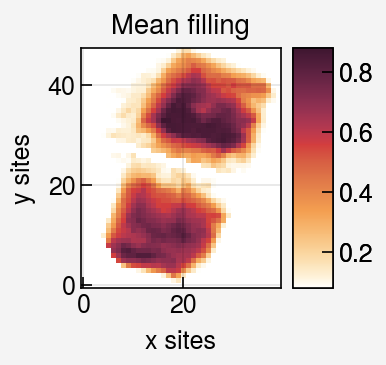

In [28]:
fig, ax = pplt.subplots([1], refwidth=1)

plotted = plot_occs_diff(ax, d_poccs, xlim=(5, 53), ylim=(10, 50))
fig.format(title="Mean filling", xlabel="x sites", ylabel="y sites", tickdir="in", xminorticks=[], yminorticks=[])

fig.savefig("figures/diffoccs.svg")
fig.savefig("figures/diffoccs.png", dpi=300)

save_data("fig3_B", plotted, ",".join([str(i) for i in list(range(plotted.shape[0]))]))

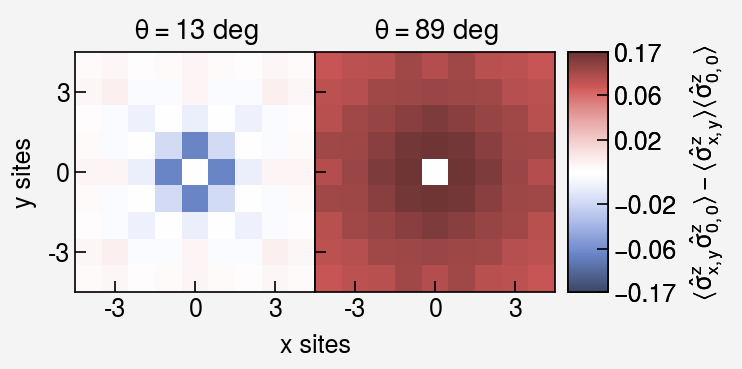

In [31]:
fig, ax = pplt.subplots([1,2], refwidth=1.2, wspace=0)

vmax = 0.17
linear_cutoff = 0.02
linear_regime = 0.3

for pidx in range(len(corrs_pidxs)):
    imdata = np.copy(np.flip(np.flip(corrs_slices[pidx], axis=0), axis=1))

    #ax[i + 3*pidx].text(0, n - 2, "%.1f dB" % (10*np.log10(xi2)), fontsize=8)
    
    c = ax[pidx].imshow(imdata, cmap="div", vmin=-vmax, vmax=vmax, origin="lower",
                        norm=SymLogNorm(linthresh=linear_cutoff, linscale=linear_regime,
                                              vmin=-vmax, vmax=vmax, base=10))
                                #norm=corrs_norm(-vmax, vmax, linear_cutoff, linear_regime=linear_regime))
    ax[pidx].format(grid=False, title=r'$\theta=%d$ deg' % (360*rabi*phis[corrs_pidxs[pidx]]),
                 xminorticks=[], xticks=range(1,corrs_n,3), xticklabels=[ "%d" % (i - corrs_n//2) for i in range(1,corrs_n,3) ], 
                 yminorticks=[], yticks=range(1,corrs_n,3), yticklabels=[ "%d" % (i - corrs_n//2) for i in range(1,corrs_n,3) ],
                xlabel="x sites", ylabel="y sites", tickdir="in"
                 )
    
    save_data("fig3_F_%ddeg" % (360*rabi*phis[corrs_pidxs[pidx]]), imdata, ",".join([ str(i) for i in list(range(imdata.shape[0]))]))
cbar = ax[1].colorbar(c, tickdir="in", ticks=[-vmax, np.round(100*(-vmax/3))/100, -linear_cutoff, linear_cutoff, np.round(100*(vmax/3))/100, vmax])
cbar.set_label(r'$\langle \hat{\sigma}^z_{x,y}\hat{\sigma}^z_{0,0}\rangle-\langle \hat{\sigma}^z_{x,y} \rangle \langle\hat{\sigma}^z_{0,0}\rangle$')

#fig.format(suptitle=r'$\langle Z_aZ_b\rangle -\langle Z_a\rangle\langle Z_b\rangle$')

fig.savefig("figures/highsqueezingcorrs.svg")
fig.savefig("figures/highsqueezingcorrs.png", dpi=600)

# Histogram

N_clip: (495.0, 552.0)  min_fill: 0.07906687402799378


/tmp/ipykernel_21350/2374282933.py:50: RuntimeWarning: invalid value encountered in divide
  ratio = (spinup - spindown)/N


23


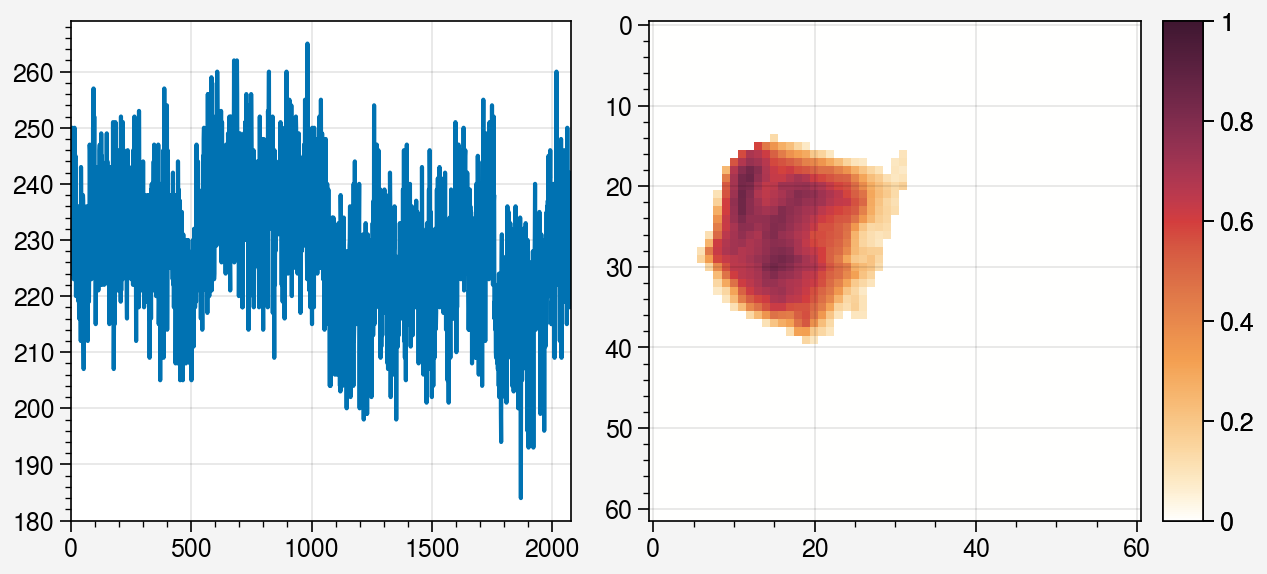

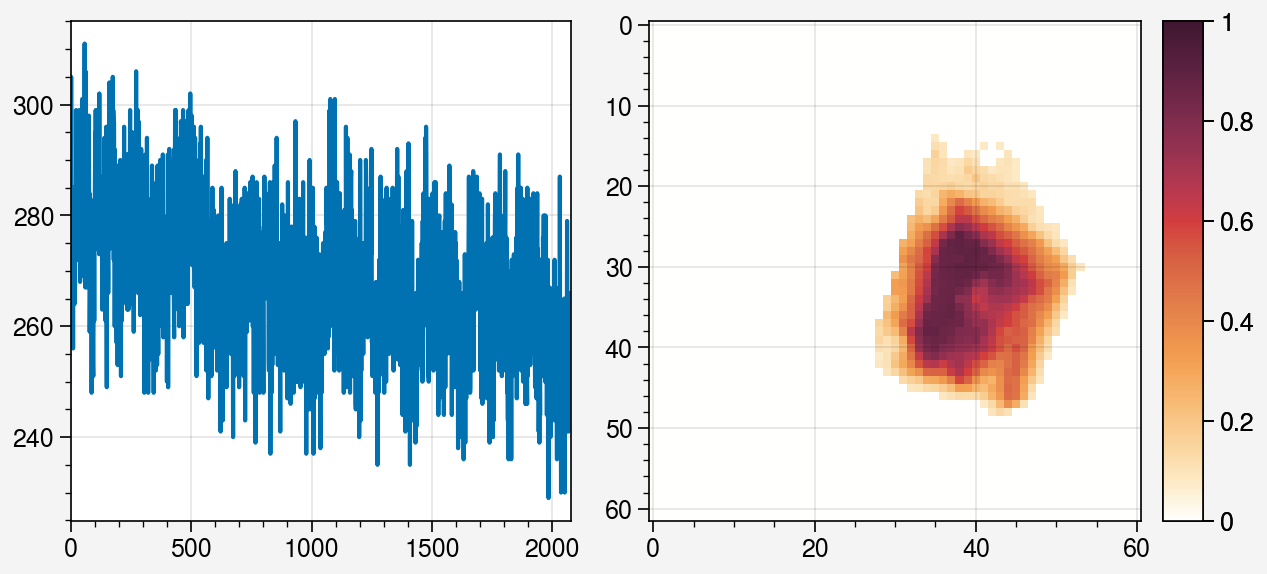

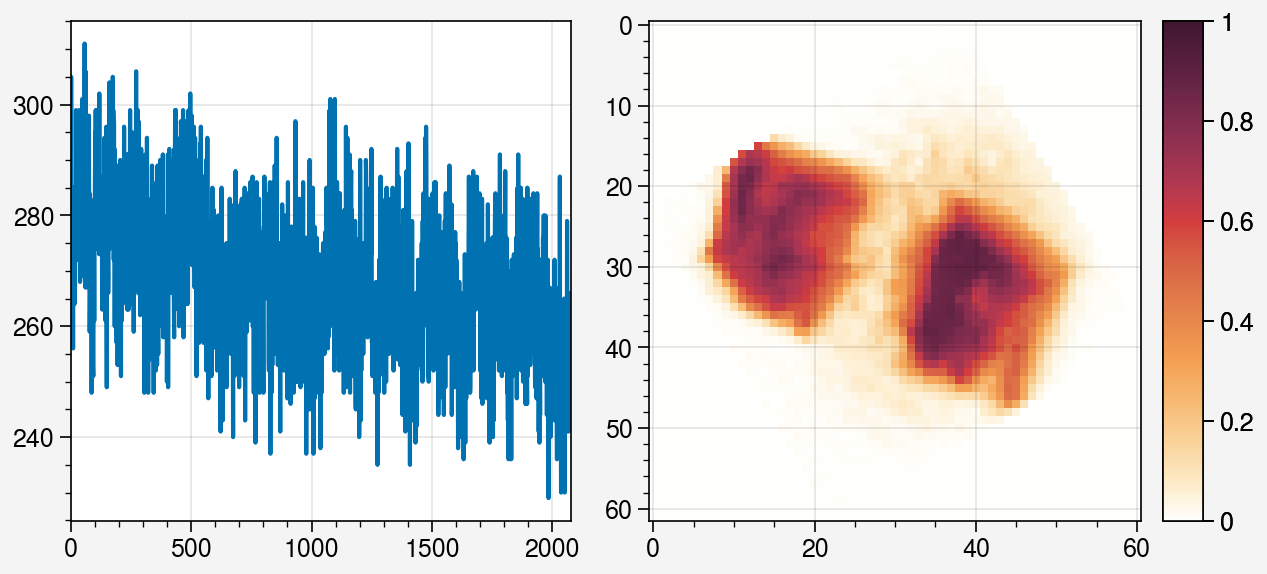

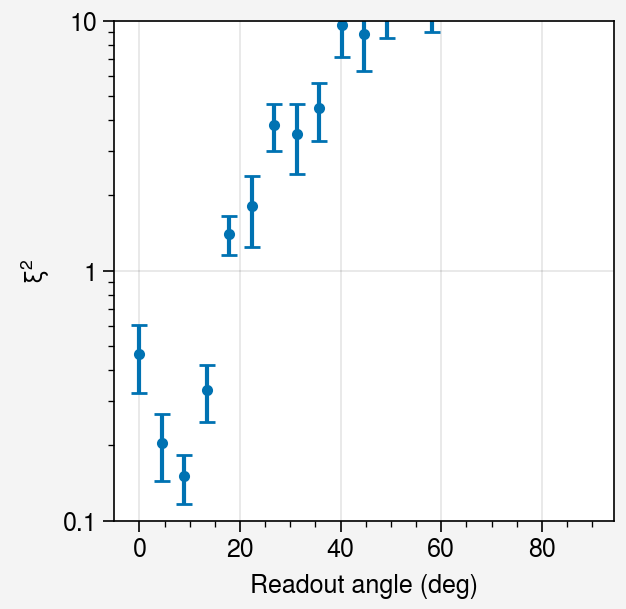

In [76]:
#d = analyze_diff('./data/2023/12/07/', 26, reg_slope=0.75, transpose=False, 
#                 reg_cutoffs=(3, 13), sum_spindown=True, double="none") # High squeezing many points
#pidx = 6

d = analyze_diff('./data/2024/02/10', [68,69], reg_slope=-0.3, transpose=False, 
                 reg_cutoffs=(37, 39), sum_spindown=True, double="none", maxr=62, maxc=62)
all_ts = np.array(d[0]["variable_values"]["MicrowavePulseSweepVar2"])
ts = np.unique(all_ts)
pidx = 2
tidx = 1

rabi = 800 # TODO

x, y_mean, y_std, all_s, _ = get_squeezing_diff(d, all_ts == ts[tidx], rabi, beta=1, bootstrap=False)

s = all_s[pidx]

print(len(s))

In [77]:
r = scipy.stats.bootstrap((s,), statistic=lambda x: np.var(x, ddof=1))

sigma2 = np.var(s, ddof=1)
l, u = error_bar_percentile(r.bootstrap_distribution)
ldB, udB = 10*np.log10(l), 10*np.log10(u)
dB = 10*np.log10(sigma2)
print(dB, dB - ldB, udB - dB)

print((10/np.log(10))*np.std(r.bootstrap_distribution)/sigma2)

-8.228955202818824 1.3571225770014976 0.7169047464173373
0.9662674903569312


-6.39865558039182


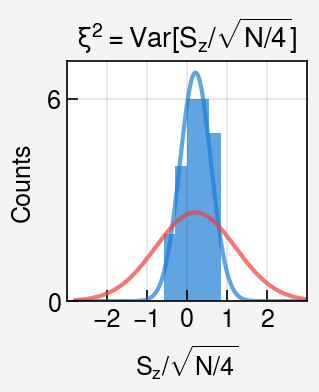

In [78]:
fig, ax = pplt.subplots([1], refwidth=1.2)

counts, bins, patches = ax.hist(s, bins=5, alpha=0.7, color=COLORS[0])
sql_x = np.linspace(-3, 3, 1000)
dB = 10*np.log10(sigma2/0.81**2)
print(dB)
ax.plot(sql_x + np.mean(s), (len(s)*(bins[1] - bins[0]))*(1/(np.sqrt(2*np.pi)*sigma2**0.5))*np.exp(-sql_x**2/(2*sigma2)), 
            alpha=0.7, color=COLORS[0])
ax.plot(sql_x + np.mean(s), (len(s)*(bins[1] - bins[0]))*(1/np.sqrt(2*np.pi))*np.exp(-sql_x**2/2), 
            color=COLORS[1], alpha=0.7)
ax.format(tickdir="in", ylabel="Counts", xlabel=r'$S_z/\sqrt{N/4}$', xlim=(-3, 3), yticks=[0, 6], yminorticks=[], xticks=[-2, -1, 0, 1, 2], xminorticks=[],
         title=r'$\xi^2=\mathrm{Var}[S_z/\sqrt{N/4}]$')#=%.1f dB$' % dB)
fig.savefig("figures/examplehist.png", dpi=600)
fig.savefig("figures/examplehist.svg")

save_data("fig3_A", np.stack([bins, np.concatenate([counts, [0]])], axis=0), "bins (including the leftmost edge of the first bin and rightmost bin of the last bin),counts (padded with a 0 at the end)")

In [79]:
print(bins)
print(counts)

[-0.5824247  -0.29569254 -0.00896038  0.27777178  0.56450394  0.8512361 ]
[2. 4. 6. 6. 5.]


# Rabi

N_clip: (1052.0, 1126.125)  min_fill: 0.09161290322580645
<N>: 1089.1681415929204


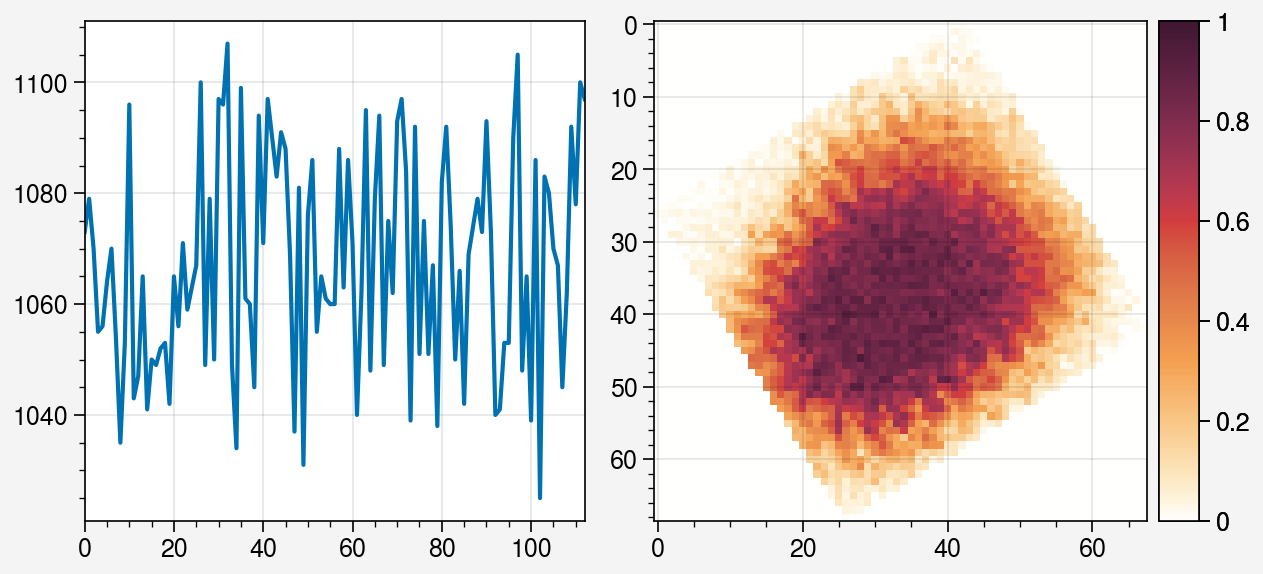

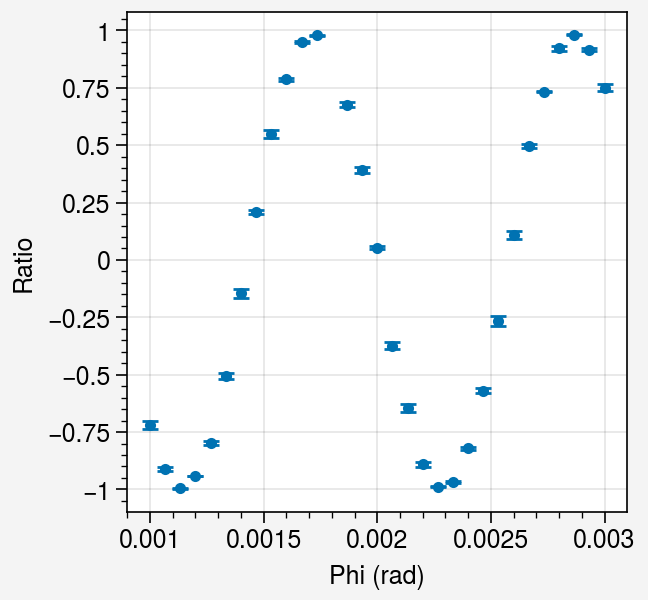

In [51]:
d = analyze("data/2023/12/06/", 27, sum_spindown=True, double="none", dtwaprefix=None, dtwaendt=2.1)

(x, y, y_std), (popt, pstd), chisq, (Ns, Ns_std) = get_contrast(d, None, phi_varname="MicrowavePulseGreenScienceHoldDuration0", do_fit=False)

Amplitude: -0.9882189739574059 +/- 0.0007591516201293472
Offset: -0.005090198936943661 +/- 0.0006986818350889144


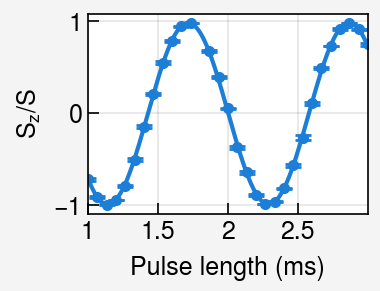

In [52]:
fig, ax = pplt.subplots([[1]], refwidth=1.4, refheight=1, sharey=False, space=0)

c = COLORS[0]
ax[0].errorbar(1e3*x, y, yerr=y_std, fmt=".", color=c)

save_data_onesided("fig_S5_A", 1e3*x, y, y_std, xaxis="Pulse length (ms)", yaxis="S_z/S")

popt, pcov, chisq = fit_curve(sin, x, y, y_std, (1, 1e3, 0, 0))
psigma = np.diag(pcov)**0.5
fit_x = np.linspace(np.min(x), np.max(x), 1000)
ax[0].plot(1e3*fit_x, sin(fit_x, *popt), color=c)#, label="%d Hz" % (np.abs(popt[1])))
#ax[1].errorbar(1e3*x, Ns, yerr=Ns_std, fmt=".", color=c)

print("Amplitude:", popt[0], "+/-", pcov[0,0]**0.5)
print("Offset:", popt[2], "+/-", pcov[2,2]**0.5)

#ax.legend(ncols=1, loc="t")
xticks = [1, 1.5, 2, 2.5]
ax[0].format(xlabel="Pulse length (ms)", ylabel=r'$S_z/S$', tickdir="in", xticks=xticks, xminorticks=[], yminorticks=[])
#ax[1].format(ylabel="Atom number", tickdir="in", xticks=xticks, yloc="right")

fig.savefig("figures/rabi.pdf")

# Magnetic field

N_clip: (1144.375, 1227.25)  min_fill: 0.1
<N>: 1186.5833333333333


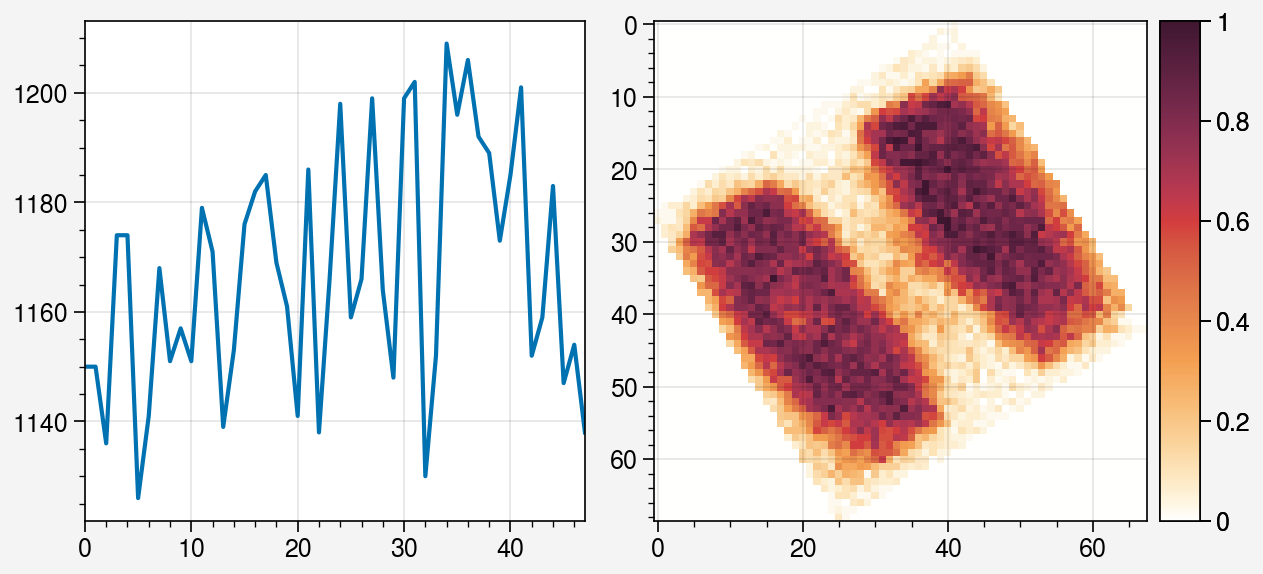

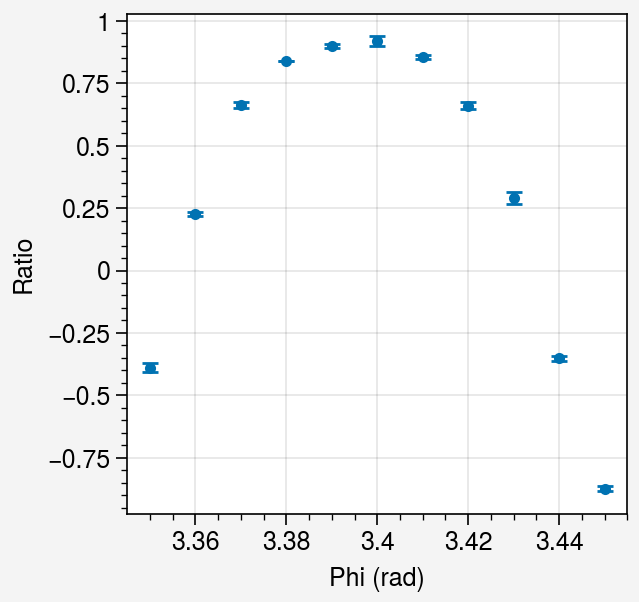

In [53]:
d = analyze("data/2023/12/04/", 37, sum_spindown=True, double="none", dtwaprefix=None, dtwaendt=2.1)

(x, y, y_std), (popt, pstd), chisq, _ = get_contrast(d, None, phi_varname="BigFeshbachDuringScienceLatticeHold5", do_fit=False)

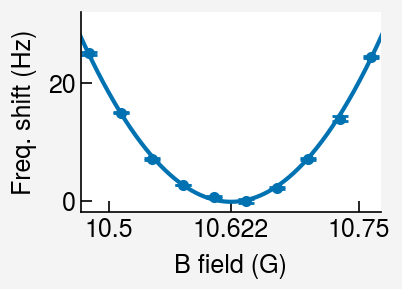

In [54]:
t_wait = 0.01

y_p = np.arcsin(y)/(2*np.pi*t_wait)
y_std_p = y_std/(2*np.pi*t_wait) # TODO: propagate errors correctly

y_p = -y_p + np.max(y_p)

endi = -1
x_p = x[:endi]
y_p = y_p[:endi]
y_std_p = y_std_p[:endi]


fig, ax = pplt.subplots([1], refwidth=1.5, refheight=1)
c = "C0"

popt, pcov, chisq = fit_curve(quad, x_p, y_p, y_std_p, (3.4, 1e3, 0))
psigma = np.diag(pcov)**0.5
fit_x = np.linspace(np.min(x_p) - 0.005, np.max(x_p) + 0.005, 1000)

B0 = 10.622
xf = B0/popt[0]

m = 1e-3*popt[1]/xf**2

ax.plot(xf*fit_x, quad(fit_x, *popt), color=c, label=r'%.1f mHz/mG$^2$' % m)
ax.errorbar(xf*x_p, y_p, yerr=y_std_p, fmt=".", color=c)

save_data_onesided("fig_1_C", xf*x_p, y_p, y_std_p, xaxis="B field (G)", yaxis="Freq. shift (Hz)")

#ax.legend()
ax.format(xlabel="B field (G)", ylabel="Freq. shift (Hz)", tickdir="in", xminorticks=[], yminorticks=[],
         xlim=[B0-0.15, B0+0.15], xticks=[10.5, B0, 10.75], grid=False)#, title="Magnetically insensitive qubit")
ax.spines[['right', 'top']].set_visible(False)

fig.savefig("figures/magneticfield.pdf")

# T2

0.48957505438207893
[793.65623528  16.84175011] [7.77169168 0.48957505]


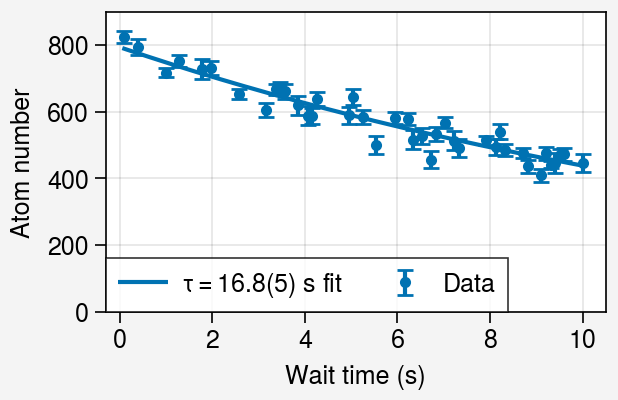

In [55]:
latticeloss = pickle.load(open("an_data/latticeloss.pickle", "rb"))

x = latticeloss["x"]
y = latticeloss["an"]
yerr = latticeloss["an_sem"]

mask = yerr < 30
x = x[mask]
y = y[mask]
yerr = yerr[mask]

popt, pcov = curve_fit(exp, x, y, (900, 16.8), sigma=yerr, absolute_sigma=True)

fit_x = np.linspace(np.min(x), np.max(x), 1000)

fig, ax = pplt.subplots([1], refheight=1.5, refwidth=2.5)

c = "C0"

fit_y = exp(fit_x, *popt)

print(pcov[1,1]**0.5)

ax.errorbar(x, y, yerr=yerr, fmt=".", label="Data", color=c)
ax.plot(fit_x, fit_y, label=r'$\tau=%.1f(%d)$ s fit' % (popt[1], round(10*pcov[1,1]**0.5)), color=c)
ax.format(xlabel= "Wait time (s)", ylabel="Atom number", xlim=(-0.3, 10.5), ylim=(0, 900), xminorticks=[], yminorticks=[])
ax.legend(loc="ll")
fig.savefig("figures/latticeloss.pdf")

save_data_onesided("fig_S3_B", x, y, yerr, xaxis="Wait time (s)", yaxis="Atom number")

print(popt, np.sqrt(np.diag(pcov)))

ll_x = x
ll_y = y
ll_yerr = yerr
ll_fit_x = fit_x
ll_fit_y = fit_y
ll_popt = popt

In [57]:
lattice_loss = ll_popt[1]
print(lattice_loss)

16.8417501145617


0.21217846137507382
[869.57148617   6.04647348] [5.64578343 0.21217846]


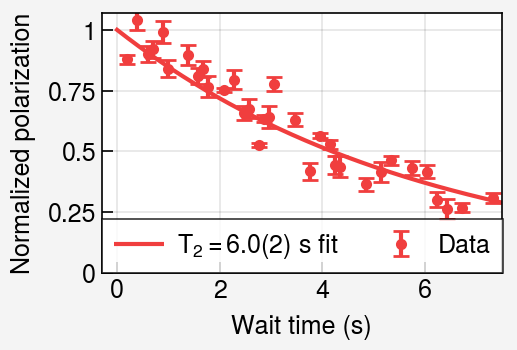

In [60]:
wahuha = pickle.load(open("an_data/wahuha.pickle", "rb"))

x = wahuha["x"]
fc = np.exp(-x/lattice_loss)
y = wahuha["an"]/fc
yerr = wahuha["an_sem"]/fc

mask = (yerr < 20) & (x < 7.5)
x = x[mask]
y = y[mask]
yerr = yerr[mask]

popt, pcov = curve_fit(contrast, x, y, (900, 16.8), sigma=yerr, absolute_sigma=True)

N0 = popt[0]

fit_x = np.linspace(0, 10, 1000)
fig, ax = pplt.subplots([1], sharey=False, sharex=True, refwidth=2, refheight=1.3)

print(pcov[1,1]**0.5)

ax[0].errorbar(x, 2*y/N0 - 1, yerr=(2*yerr/N0), fmt=".", color=COLORS[1], label="Data")
ax[0].plot(fit_x, 2*contrast(fit_x, *popt)/N0 - 1, label=r'$\mathrm{T}_2=%.1f(%d)$ s fit' % (popt[1], round(10*pcov[1,1]**0.5)), color=COLORS[1])
ax[0].format(xminorticks=[], yminorticks=[], ylabel="Normalized polarization", xlim=(-0.3, 7.5), ylim=(0, 1.07), tickdir="in", xlabel= "Wait time (s)")
ax[0].legend()
#fig.format(title="Interaction-decoupled T2")
#fig.savefig("figures/wahuha.png")

print(popt, np.sqrt(np.diag(pcov)))

#ix = ax.inset(
#    [0.5, 0.05, 5, 0.4], transform='data', zoom=False,
#)
#ix = ax[0].panel_axes("b", width='6em', space="1em")
#ix.errorbar(ll_x, ll_y, yerr=ll_yerr, fmt=".", color=COLORS[0])
#ix.plot(ll_fit_x, ll_fit_y, "--", label=r'$\tau=%.1f$ s fit' % (ll_popt[1]), color=COLORS[0])
#ax.format(xlabel= "Wait time (s)", ylabel="Atom number", xlim=(-0.3, 10.5), ylim=(0, 1000),
#         tickdir="in")
#ix.legend()

save_data_onesided("fig_S3_A", x, 2*y/N0 - 1, (2*yerr/N0), xaxis="Wait time (s)", yaxis="Normalized polarization")

fig.savefig("figures/t2.pdf")

In [58]:
print(popt)
wahuha_popt = popt

[869.57148617   6.04647348]


# Long time contrast

N_clip: (963.75, 1101.0)  min_fill: 0.09375
<N>: 1031.2206703910615


Output()

  0%|          | 0/10 [00:00<?, ?it/s]

Calculating xi^2


  0%|          | 0/10 [00:00<?, ?it/s]

Ns in analyze: [ 984 1001  920  935 1005  907  921  975  952  974]


/home/vassilios/anaconda3/envs/tf/lib/python3.10/site-packages/erbium_analysis_modules/dtwa_module.py:143: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = axs[0].pcolormesh(Ts, Phis*180/np.pi, 10*np.log10(np.mean(xi2s, axis=0)))
/home/vassilios/anaconda3/envs/tf/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/vassilios/anaconda3/envs/tf/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


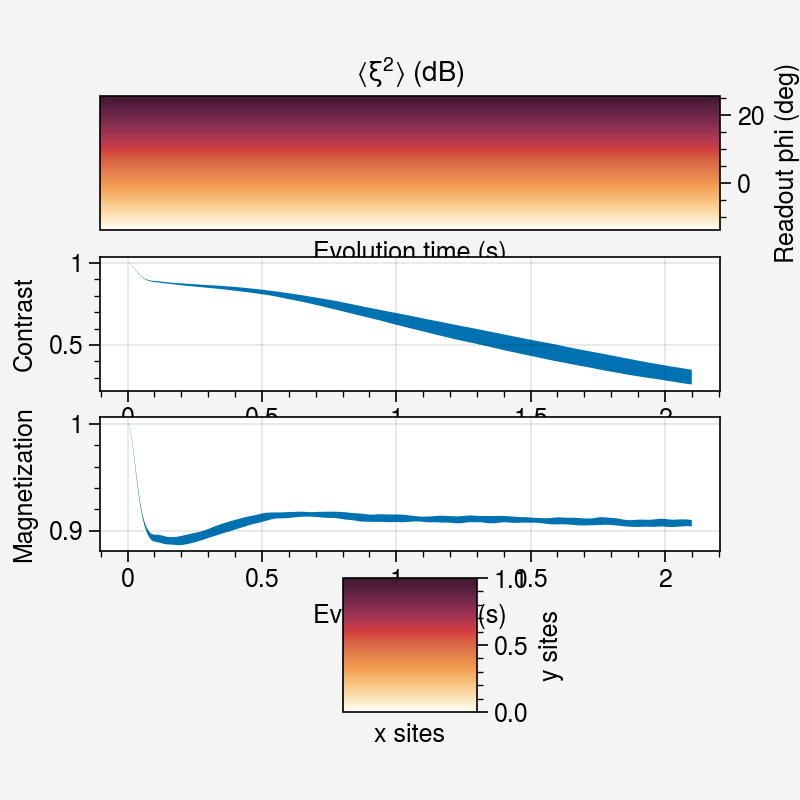

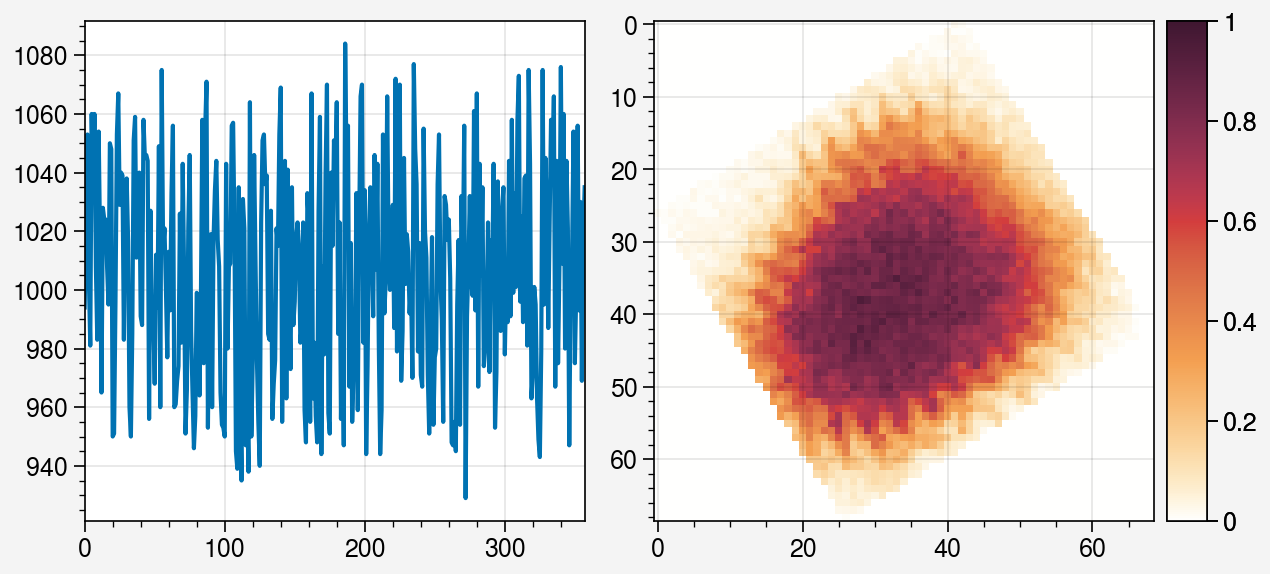

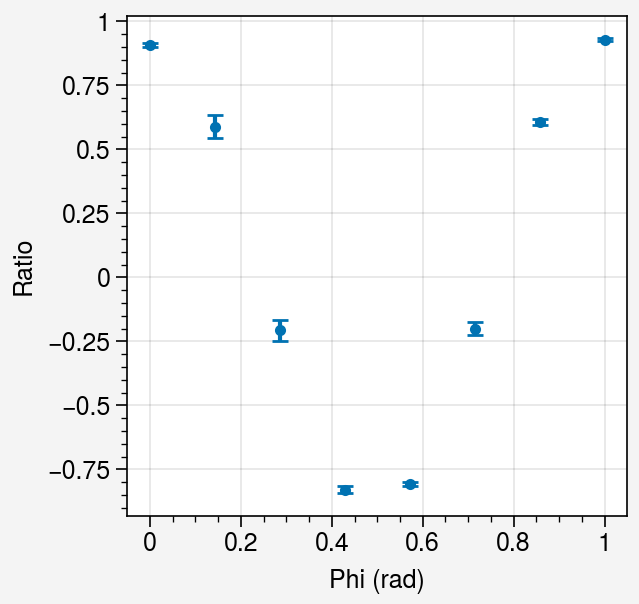

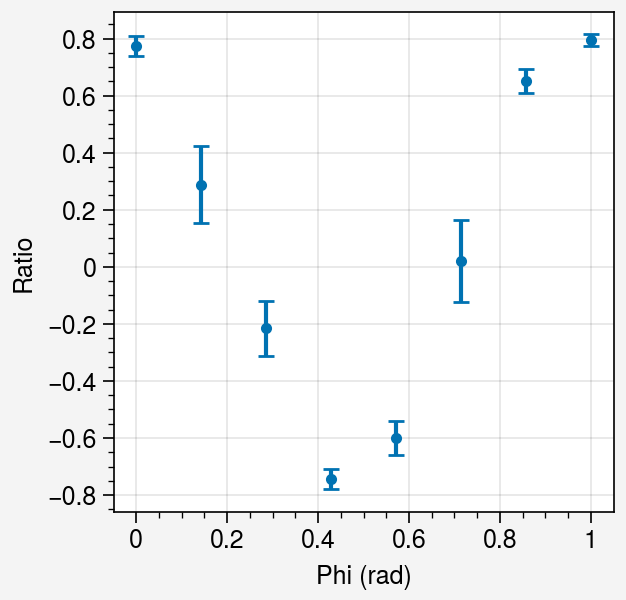

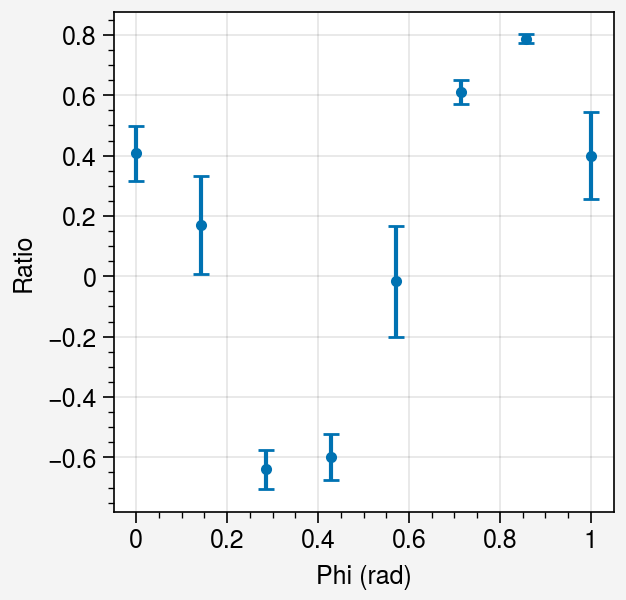

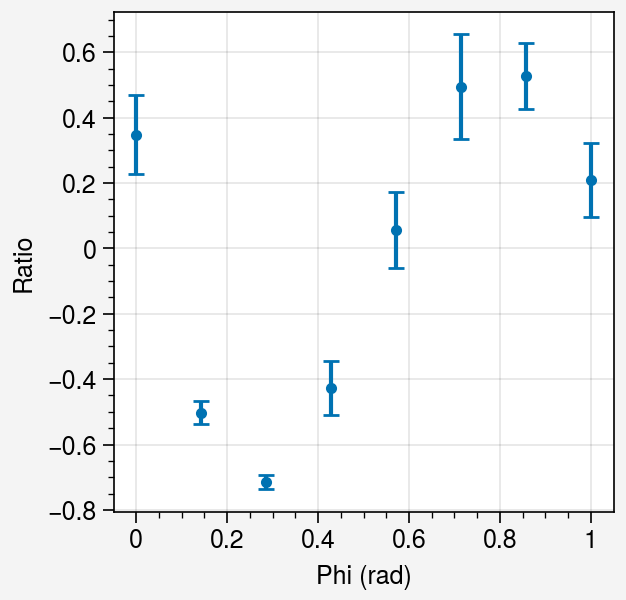

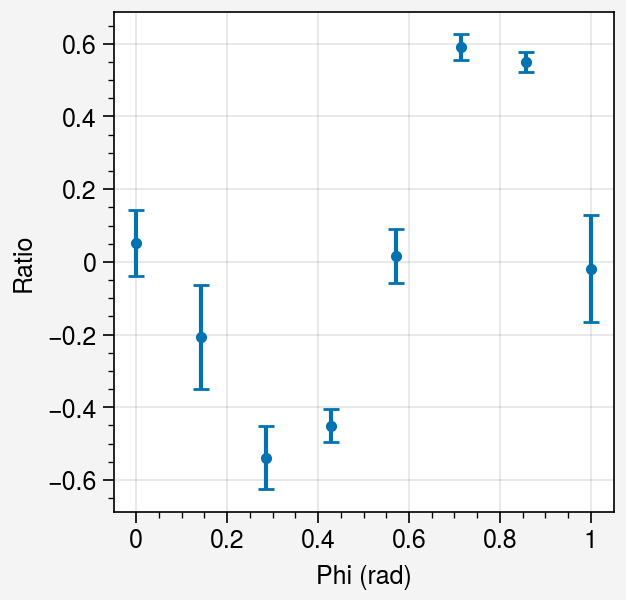

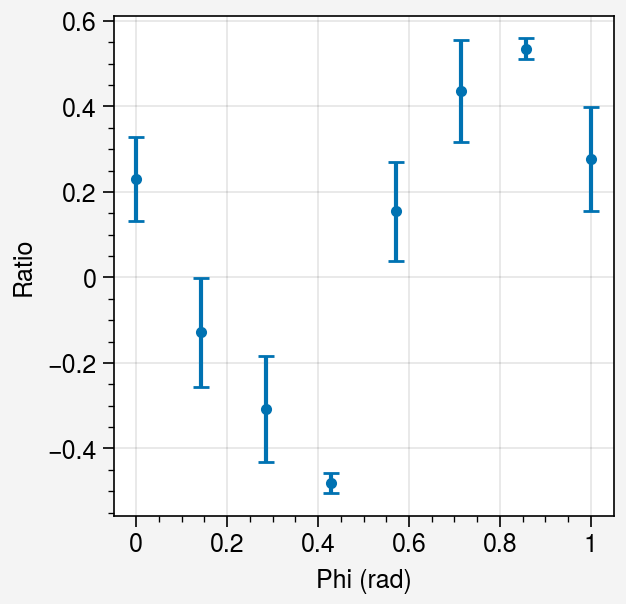

In [59]:
d = analyze("data/2023/12/05/", 34, sum_spindown=True, double="none", dtwaprefix="longcontrast2", dtwaendt=2.1)
           #dtwatunnelfreq=1, dtwaprefix="longcontrast2_tun")

all_ts = np.array(d["variable_values"]["MicrowavePulseSweepVar2"])
ts = np.unique(all_ts)

cs = []
cs_std = []
xs = []
ys = []
y_stds = []
popts = []
pstds = []
for j, t in enumerate(ts):
    (x, y, y_std), (popt, pstd), chisq, _ = get_contrast(d, all_ts == t)

    xs.append(x)
    ys.append(y)
    y_stds.append(y_std)
    popts.append(popt)
    pstds.append(pstd)
    
    cs.append(popt[0])
    cs_std.append(pstd[0])

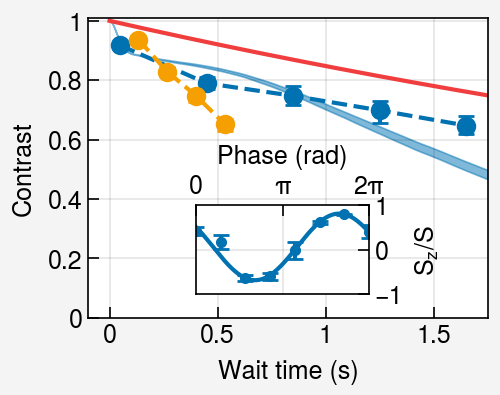

In [60]:
fig, ax = pplt.subplots([1], refwidth=2, refheight=1.5)    

c = "C0"
ax.errorbar(ts[:-1], cs[:-1], yerr=np.array(cs_std).T[:,:-1], ls="--", fmt="o", color=c)
ax.fill_between(d["dtwa"]["ts"], d["dtwa"]["cs"] - d["dtwa"]["cs_std"], d["dtwa"]["cs"] + d["dtwa"]["cs_std"], 
                   alpha=0.5, color=c)

save_data_twosided("fig_2_B_blue", ts[:-1], cs[:-1], np.array(cs_std).T[:,:-1], xaxis="Wait time (s)", yaxis="Contrast")

ax.format(xlabel="Wait time (s)", ylabel="Contrast", xlim=(-0.1, 1.75), ylim=(0, 1.01), tickdir="in", xminorticks=[], yminorticks=[])#, title="Interaction-limited T2")

def decay(tv, life):
    return np.exp(-tv/life)

ystd = np.array(cs_std).T[:,:-1]
popt, pcov, chisq = fit_curve(decay, ts[:-1], cs[:-1], (ystd[0] + ystd[1])/2, (3,))
#print(popt, pcov**0.5, chisq, (ystd[1] + ystd[0])/2)
#ax.plot(ts[:-1], decay(ts[:-1], *popt), color=c)

fit_x = np.linspace(0, 3, 1000)
ax.plot(fit_x, 2*contrast(fit_x, *wahuha_popt)/wahuha_popt[0] - 1, label="Interaction-decoupled", color=COLORS[1])

ax.errorbar(tun_ts, tun_cs[0], yerr=tun_cs_std[0], fmt="o", ls="--", color=COLORS[2])

save_data_twosided("fig_2_B_orange", tun_ts, tun_cs[0], tun_cs_std[0], xaxis="Wait time (s)", yaxis="Contrast")

ix = ax.inset(
    [0.4, 0.08, 0.8, 0.3], transform='data', zoom=False,
)
ci = 2
c_fit_x = np.linspace(0, 1, 1000)
ix.errorbar(xs[ci]*2*np.pi, ys[ci], yerr=y_stds[ci], fmt=".", color=c)
ix.plot(c_fit_x*2*np.pi, sin(c_fit_x, *popts[ci]), label=r'$\tau=%.1f$ s' % (ts[ci]), color=c)
ix.format(xlabel= "Phase (rad)", ylabel=r'$S_z/S$', xlim=(0, 2*np.pi), ylim=(-1, 1),
          ytickloc="right", xtickloc="top", tickdir="in", xminorticks=[], yminorticks=[], xticks=[0, np.pi, 2*np.pi], 
          xticklabels=["0", r'$\pi$', r'$2\pi$'])

save_data_onesided("fig_2_B_inset", xs[ci]*2*np.pi, ys[ci], y_stds[ci], xaxis="Wait time (s)", yaxis="Normalized polarization")

fig.savefig("figures/longcontrast.pdf")

In [61]:
print(ts)

[0.05 0.45 0.85 1.25 1.65 2.05]


# Pi pulse calibration 2

N_clip: (649.0, 1009.0)  min_fill: 0.052780519907864434
<N>: 664.680157946693


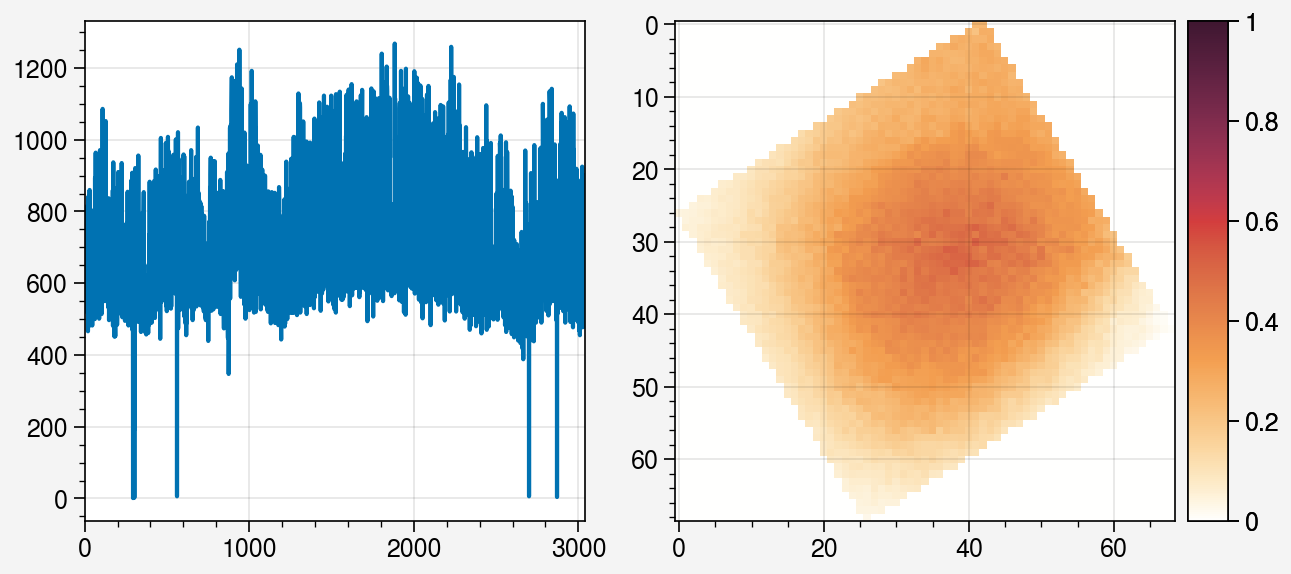

In [47]:
d = analyze("data/2023/11/15/", 185, sum_spindown=True, double="none", no_shot_mask=True)

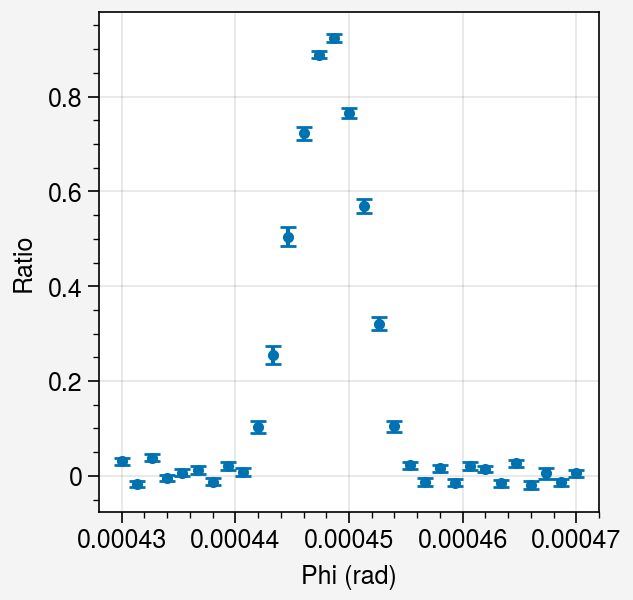

In [48]:
all_pls = np.array(d["variable_values"]["MicrowavePulsePiLength"])
pls = np.unique(all_pls)

(all_x, all_y, all_err), (_,_), _, _ = get_contrast(d, None, do_fit=False, phi_varname="MicrowavePulsePiLength")
all_x = 1e3*all_x

In [49]:
def gauss(x, x0, sigma, a, o):
    return o + a*np.exp(-(x-x0)**2/(2*sigma**2))

def gauss2(x, x0, sigma, a):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [50]:
def get_pulse_fid(x, y, err, npulses=400):
    popt2 = np.array([ 0.44818419,  0.00295783, 0.93880027, -0.0146525 ])

    popt, pcov = curve_fit(gauss, x, y, popt2, sigma=err, absolute_sigma=True)
    
    #formula is from the solution to Solve[((o + (1 - o)*Exp[-400*f])) == a, f] // N
    fid = (1/npulses)*np.log((1 - popt[3])/(popt[2] - popt[3]))
    std23 = np.sqrt(pcov[3,3] + pcov[2,2] - pcov[2,3] - pcov[3,2])
    fid_err1 = fid - \
        (1/npulses)*np.log((1 - popt[3] - pcov[3,3]**0.5)/(popt[2] - popt[3] + std23))
    
    fid_err2 = (1/npulses)*np.log((1 - popt[3] + pcov[3,3]**0.5)/(popt[2] - popt[3] - std23)) - fid
        
    return popt, pcov, fid, np.array([fid_err1, fid_err2])

In [51]:
def get_pulse_fid2(x, y, err, npulses=400):
    popt2 = np.array([ 0.44818419,  0.00295783, 0.93880027 ])

    popt, pcov = curve_fit(gauss2, x, y, popt2, sigma=err, absolute_sigma=True)
    
    #formula is from the solution to Solve[Exp[-400*f] == a, f] // N
    fid = (1/npulses)*np.log(1/popt[2])
    fid_err = (1/npulses)*(1/np.abs(popt[2]))*pcov[2,2]**0.5
        
    return popt, pcov, fid, fid_err

Fidelity: 0.9998363460823699 +/- 1.389367336247513e-05
FWHM: 6.902817871429415 +/- 0.06495832034025749 us


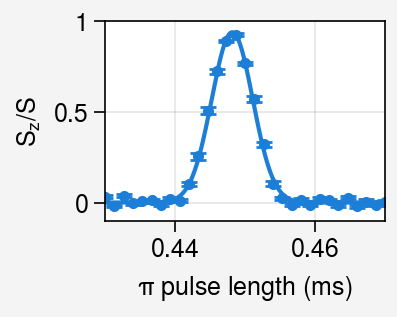

In [52]:
#x, y, err = np.load("pi_data/2000pulsegauss.npy")

popt, pcov, fid, fiderr = get_pulse_fid2(all_x, all_y, all_err)

fig, ax = pplt.subplots([1], refwidth=1.4, refheight=1)

xlim = (0.43, 0.47)
fit_x = np.linspace(xlim[0], xlim[1], 1000)
ax.plot(fit_x, gauss2(fit_x, *popt), color=COLORS[0])
ax.errorbar(all_x, all_y, yerr=all_err, fmt=".", color=COLORS[0])

ax.format(xlim=xlim, xlabel=r'$\pi$ pulse length (ms)', ylabel=r'$S_z/S$', xminorticks=[], yticks=[1, 0.5, 0], ylim=(-0.1, 1), yminorticks=[])
          #yticks=list(reversed([0, -0.5, maxsz])), 
          #yticklabels=list(reversed(["0", "-0.5", "%.3f(%d)" % (maxsz, np.round(maxsz_err*1000))])), yminorticks=[-0.75, -0.25])

#ax.get_yticklabels()[0].set_color(COLORS[0])
#ax.yaxis.get_major_ticks()[0].color = COLORS[0]

fig.savefig("figures/picalib2.pdf")

save_data_onesided("fig_S5_B", all_x, all_y, all_err, xaxis="Pi pulse length (ms)", yaxis="S_z/S")

print("Fidelity:", 1-fid, "+/-", fiderr)
print("FWHM:", 1e3*2.355*popt[1], "+/-", 1e3*2.355*pcov[1,1]**0.5, "us")

7.841910134944886e-05 9.615556009516323e-06
8.525899760355272e-05 7.191626174800929e-06
7.829188218640261e-05 8.77192742079819e-06
4.862926367719101e-05 5.947783995427095e-06
4.814443334210401e-05 6.568597156535019e-06
4.779994989614444e-05 7.106067399582287e-06
5.339341250111085e-05 5.2692290309142975e-06
9.130277145719969e-05 1.1874861457349838e-05
4.852780350972203e-05 1.1856482488119997e-05
4.326739805032312e-05 4.9053888172483976e-06
5.6486026785246914e-05 7.57889396638649e-06
3.739030528063672e-05 6.575002086519912e-06
7.494853041046464e-05 9.110577243385545e-06
0.00012101275256368482 2.578813098723356e-05
4.268678692344086e-05 5.734034199184509e-06


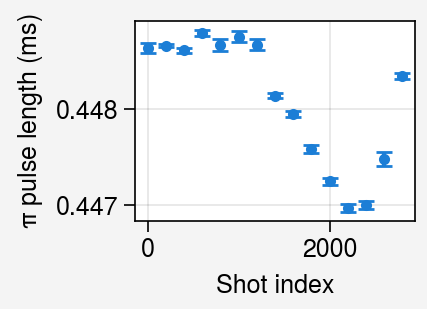

In [68]:
sample_size = 200
nsamples = int(d["occs_all_sites"].shape[-1]/sample_size)

drift_x = []
drift_y = []
drift_err = []
drift_popts = []
drift_pstds = []
drift_fids = []
drift_fiderrs = []
for i in range(nsamples):
    mask = np.arange(0, d["occs_all_sites"].shape[-1])
    mask = (mask < ((i+1)*sample_size)) & (mask >= (i*sample_size))
    
    (x, y, err), (_,_), _, _ = get_contrast(d, mask, do_fit=False, phi_varname="MicrowavePulsePiLength", plot=False)
    x = 1e3*x
    
    popt, pcov, fid, fiderr = get_pulse_fid2(x, y, err)
    print(fid, fiderr)
    
    drift_x.append(i*sample_size)
    drift_y.append(popt[0])
    drift_err.append(pcov[0,0]**0.5)
    
    drift_popts.append(popt)
    drift_pstds.append(np.diag(pcov)**0.5)
    
    drift_fids.append(fid)
    drift_fiderrs.append(fiderr)
    
fig, ax = pplt.subplots([1], refwidth=1.4, refheight=1)

ax.errorbar(drift_x, drift_y, yerr=drift_err, fmt=".", color=COLORS[0])

ax.format(xlabel="Shot index", ylabel=r'$\pi$ pulse length (ms)', xminorticks=[], yminorticks=[])
          #yticks=[0.7, 0.8, 0.9, maxsz], yticklabels=["0.7", "0.8", "0.9", "%.3f(%d)" % (maxsz, np.round(maxsz_err*1000))], yminorticks=[])

ax.get_yticklabels()[3].set_color(COLORS[0])
ax.yaxis.get_major_ticks()[3].color = COLORS[0]

save_data_onesided("fig_S5_C", drift_x, drift_y, drift_err, xaxis="Shot index", yaxis="Pi pulse length (ms)")

fig.savefig("figures/picalib_drift.pdf")

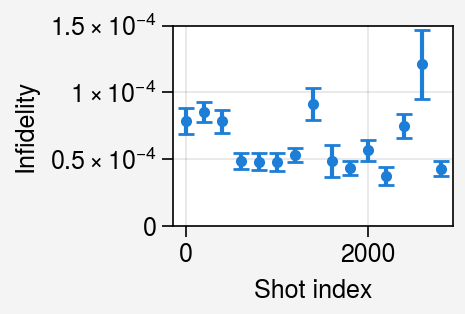

In [69]:
#x, y, err1, err2 = np.load("pi_data/2000pulseInfidelity.npy")

fig, ax = pplt.subplots([1], refwidth=1.4, refheight=1)

ax.errorbar(drift_x, drift_fids, yerr=drift_fiderrs, fmt=".", color=COLORS[0])

ax.format(xlabel="Shot index", ylabel="Infidelity", xminorticks=[], yminorticks=[],
          ylim=(0, 1.5e-4),
          yticks=[0, 0.5e-4, 1e-4, 1.5e-4], yticklabels=["0", r'$0.5\times10^{-4}$', r'$1\times 10^{-4}$', r'$1.5\times10^{-4}$'])
          #yticks=[0.7, 0.8, 0.9, maxsz], yticklabels=["0.7", "0.8", "0.9", "%.3f(%d)" % (maxsz, np.round(maxsz_err*1000))], yminorticks=[])

#ax.get_yticklabels()[3].set_color(COLORS[0])
#ax.yaxis.get_major_ticks()[3].color = COLORS[0]

save_data_onesided("fig_S5_D", drift_x, drift_fids, drift_fiderrs, xaxis="Shot index", yaxis="Infidelity")

fig.savefig("figures/piinf_drift.pdf")

# 2000 pulses pi pulse fidelity

N_clip: (595.75, 817.0)  min_fill: 0.07727272727272727
<N>: 723.75


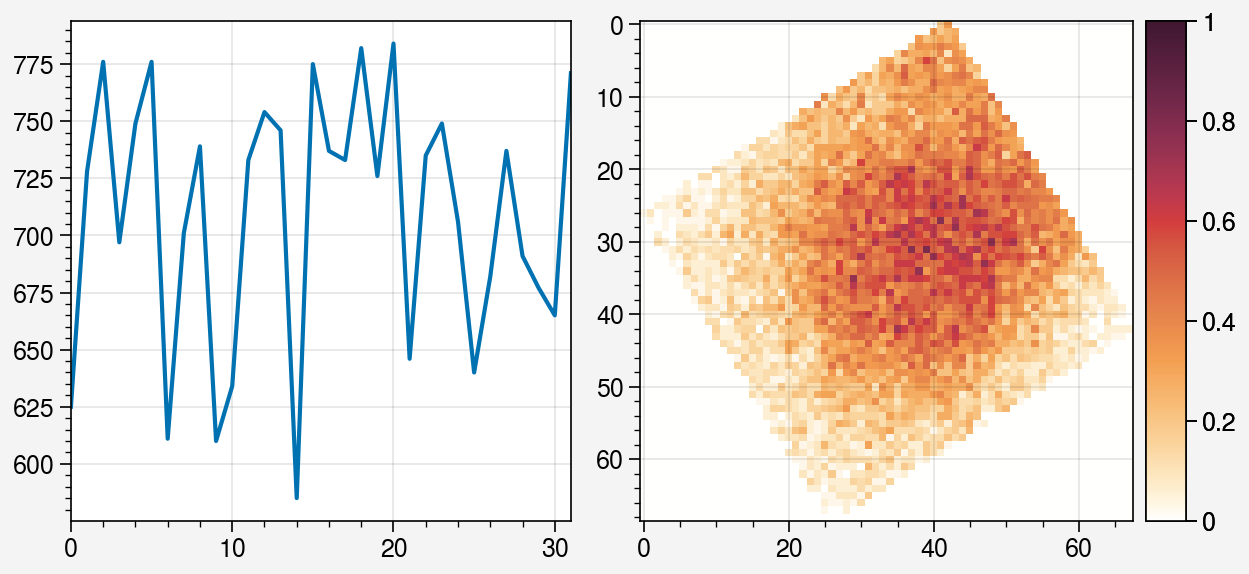

In [70]:
d = analyze("data/2023/11/15/", 178, sum_spindown=True, double="none", no_shot_mask=False)

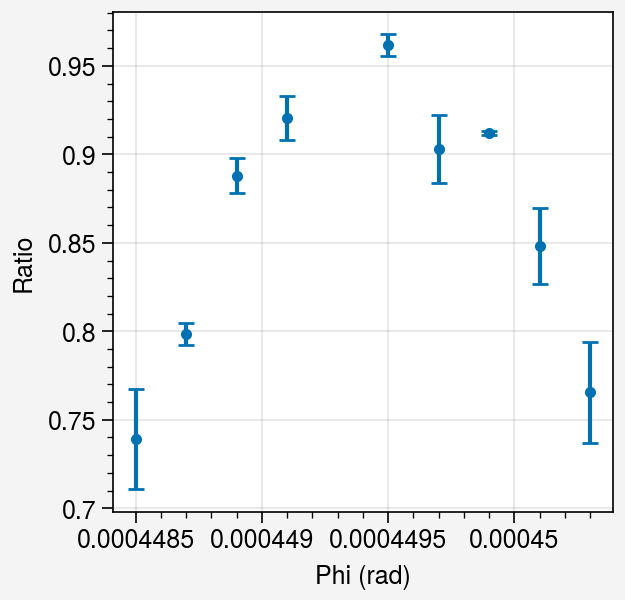

In [71]:
all_pls = np.array(d["variable_values"]["MicrowavePulsePiLength"])
pls = np.unique(all_pls)

(all_x, all_y, all_err), (_,_), _, _ = get_contrast(d, None, do_fit=False, phi_varname="MicrowavePulsePiLength")
all_x = 1e3*all_x

In [72]:
popt, pcov, fid, fiderr = get_pulse_fid2(all_x, all_y, all_err, npulses=2000)

save_data_onesided("2000pi_pulses_fidelity", all_x, all_y, all_err, xaxis="Pi pulse time (ms)", yaxis="S_z/S")

print("Fidelity", 1-fid, "+/-", fiderr)

Fidelity 0.9999812707535342 +/- 2.581560811435879e-06


# Mean field interaction

N_clip: (1046.0, 1173.0)  min_fill: 0.09566976932416027
<N>: 1118.3389923329682


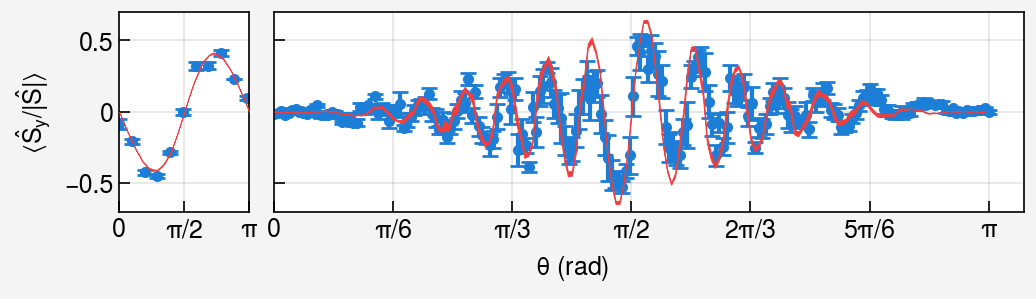

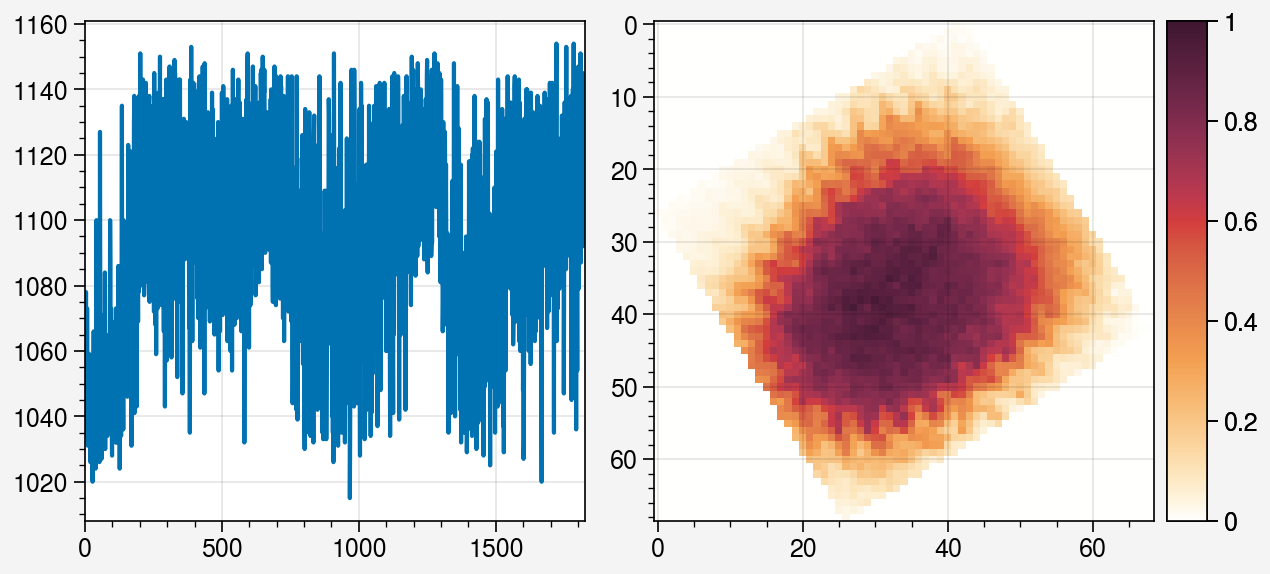

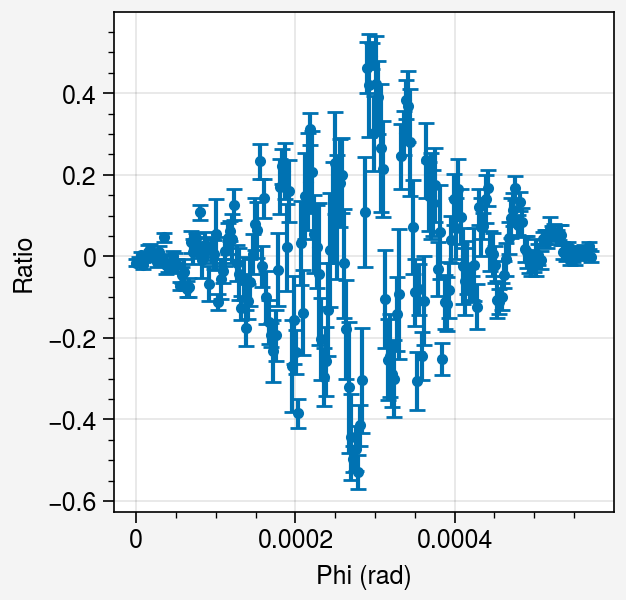

In [73]:
fig, ax = pplt.subplots([1,2,2,2,2,2], refheight=1, refwidth=0.65, space=1, sharex=True)

d = pickle.load(open("meanfielddata/mean100ms.pickle", "rb"))
ax[0].errorbar(d["theta"], d["ratio"], yerr=d["ratio_sem"], fmt=".", color=COLORS[0], label=r'$100$ ms')

#d = pickle.load(open("an_data/mean300ms.pickle", "rb"))
#ax[1].errorbar(d["phi"], d["ratio"], yerr=d["ratio_sem"], fmt=".", color=COLORS[0], label=r'$300$ ms')

ax[0].format(xticks=[0, np.pi/2, np.pi], xlabel=r'$\theta$ (rad)',
        xticklabels=["0", r'$\pi/2$', r'$\pi$'], xminorticks=[], yminorticks=[],
          ylim=(-0.7, 0.7), tickdir="in", ylabel=r'$\langle \hat{S}_y/|\hat{S}|\langle$')

ax[0].fill_between(d["theta_dtwa"], d["ratio_dtwa_mu"] - d["ratio_dtwa_std"], d["ratio_dtwa_mu"] + d["ratio_dtwa_std"], 
                   color=COLORS[1], zorder=3)
#ax[0].legend(loc="ul")

save_data_onesided("fig2_A_100ms", d["theta"], d["ratio"], yerr=d["ratio_sem"], xaxis="theta (rad)", yaxis="S_y/S")

#d = analyze("data/2023/06/22/", 19, sum_spindown=True, double="none", dtwaprefix=None, dtwaendt=2.1)
d = analyze("data/2023/12/05/", 77, sum_spindown=True, double="none", dtwaprefix=None, dtwaendt=2.1)

#pickle.dump(d["mask"], open("meanfield1000ms2_mask.pickle", "wb"))

dtwa_data = pickle.load(open("meanfielddata/meanfielddata1000ms2_dtwa.pickle", "rb"))

(x, y, y_std), (popt, pstd), chisq, _ = get_contrast(d, None, phi_varname="MicrowavePulseSweepVar", do_fit=False)

#rabi = np.pi/0.3125e-3
rabi = np.pi/0.571e-3

ax[1].errorbar(rabi*x, y, yerr=y_std, fmt=".", color=COLORS[0], label=r'$1000$ ms')
ax[1].format(xticks=[0, np.pi/6, np.pi/3, np.pi/2, 2*np.pi/3, 5*np.pi/6, np.pi],
            xticklabels=["0", r'$\pi/6$', r'$\pi/3$', r'$\pi/2$', r'$2\pi/3$', r'$5\pi/6$', r'$\pi$'], xminorticks=[],
                tickdir="in", ylabel=r'$\langle \hat{S}_y/|\hat{S}|\rangle$', yminorticks=[])

ax[1].fill_between(dtwa_data[0], dtwa_data[1] - dtwa_data[2], dtwa_data[1] + dtwa_data[2], color=COLORS[1], zorder=3)

ax[1].format(xlabel=r'$\theta$ (rad)')

save_data_onesided("fig2_A_1000ms", rabi*x, y, y_std, xaxis="theta (rad)", yaxis="S_y/S")

#ax[1].legend(loc="ul")
fig.savefig("figures/meanfield_all.pdf")

# Scan stats

./data/2024/02/02  scan 40
N_clip: (54.0, 69.0)  min_fill: 0.03066010422698321
<N>: 61.06014712245781
<N>: 55.10774556469061 max filling: 0.32929467762873216



./data/2024/02/02  scan 18
N_clip: (55.0, 69.0)  min_fill: 0.03172109010557329
<N>: 61.78889311525295
<N>: 55.32788132369722 max filling: 0.34271586154431344



./data/2024/02/01  scan 179
N_clip: (63.0, 78.0)  min_fill: 0.024176857949200378
<N>: 68.85460170146945
<N>: 64.81206496519721 max filling: 0.28306264501160094



./data/2024/03/19  scan 80
N_clip: (78.0, 98.0)  min_fill: 0.016875
<N>: 87.73706896551724
<N>: 84.75 max filling: 0.1810344827586207



./data/2024/03/19  scan 109
N_clip: (76.0, 92.0)  min_fill: 0.0196875
<N>: 83.65625
<N>: 78.57589285714286 max filling: 0.20535714285714285



./data/2024/03/15  scan 113
N_clip: (53.0, 68.0)  min_fill: 0.0209375
<N>: 60.75949367088607
<N>: 54.36286919831224 max filling: 0.21940928270042195





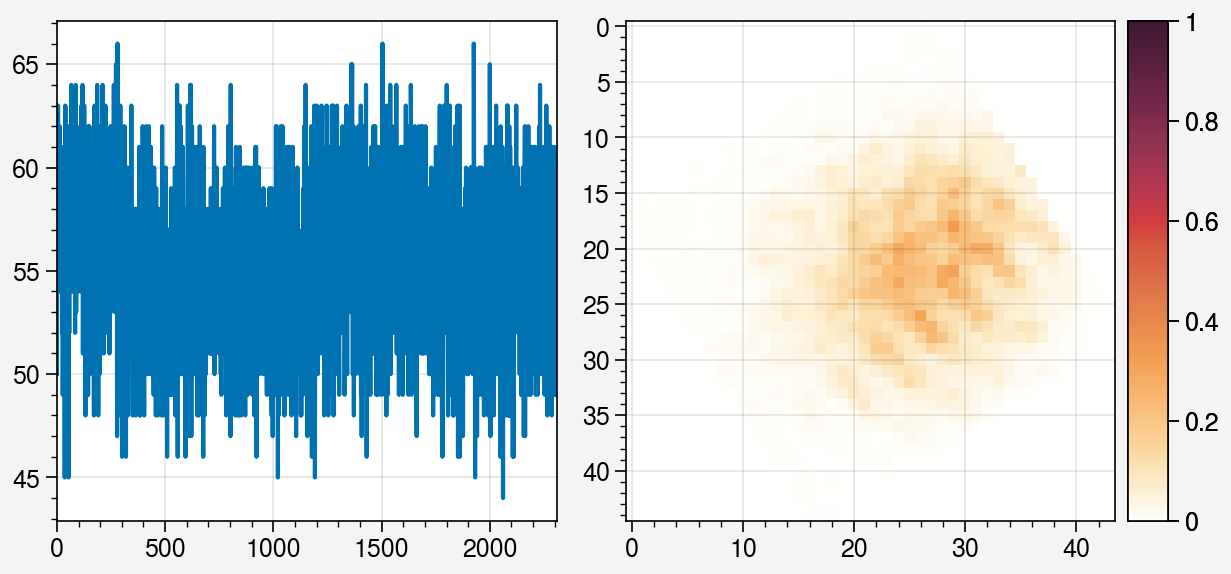

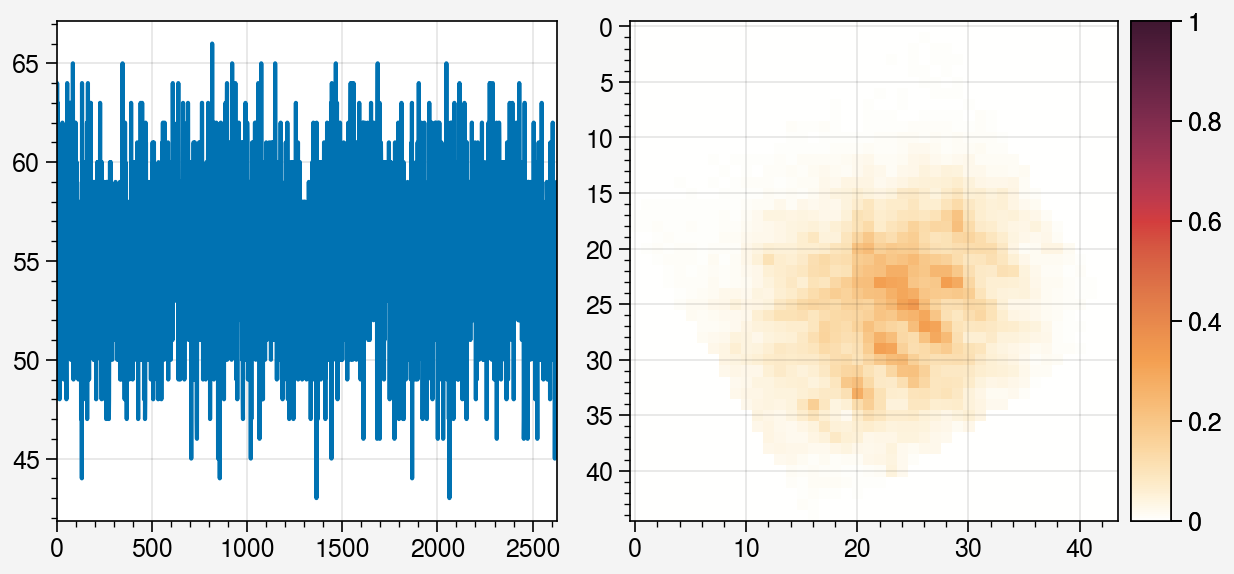

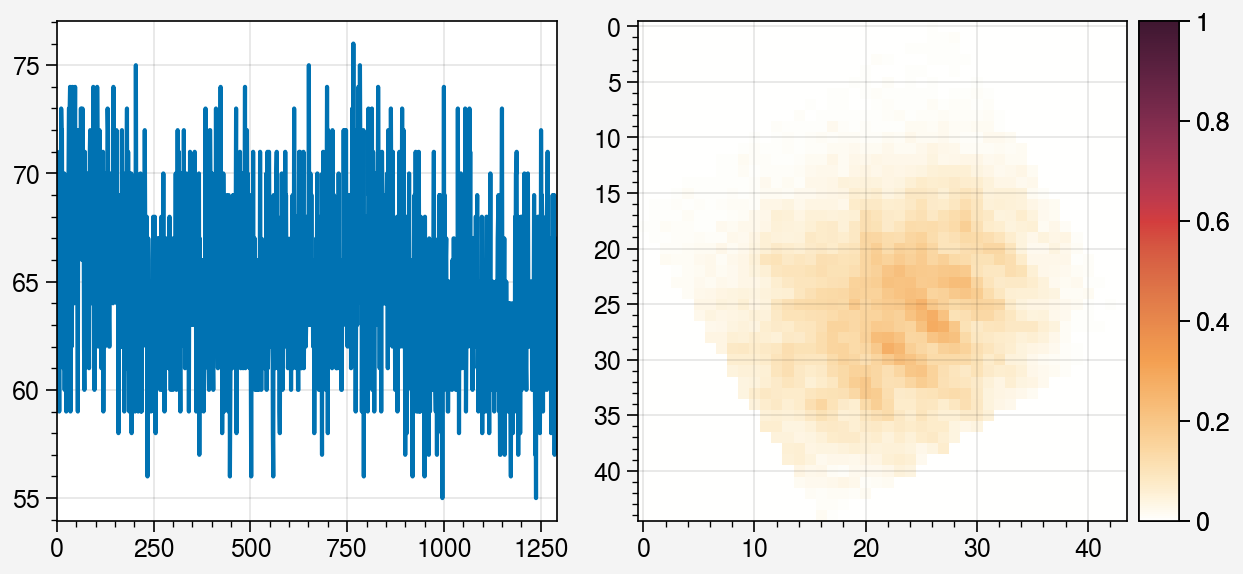

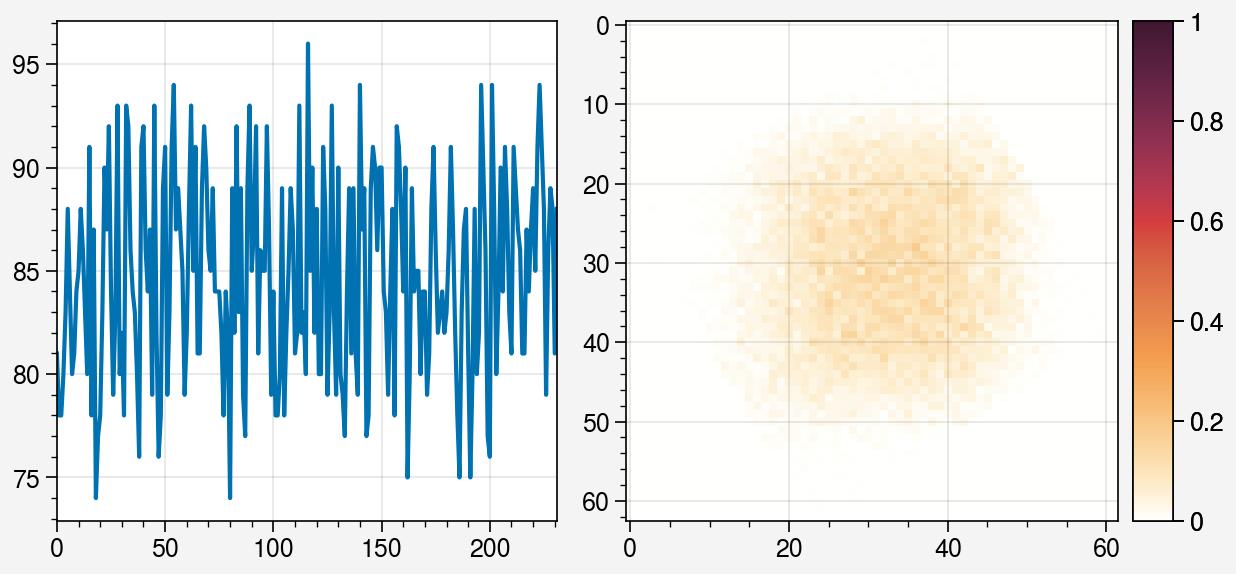

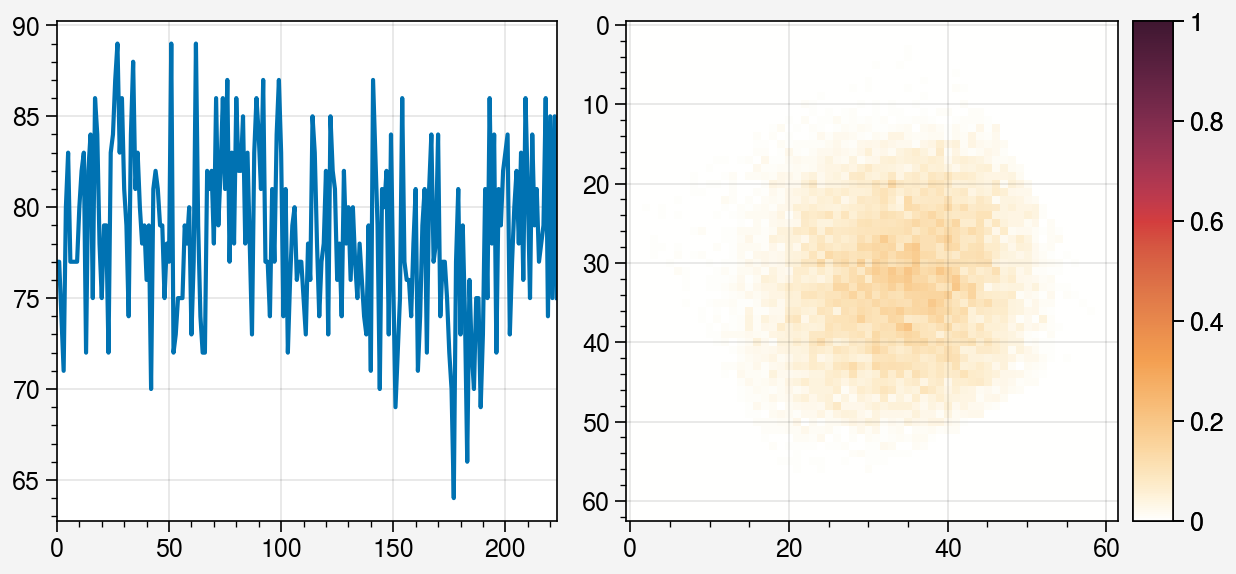

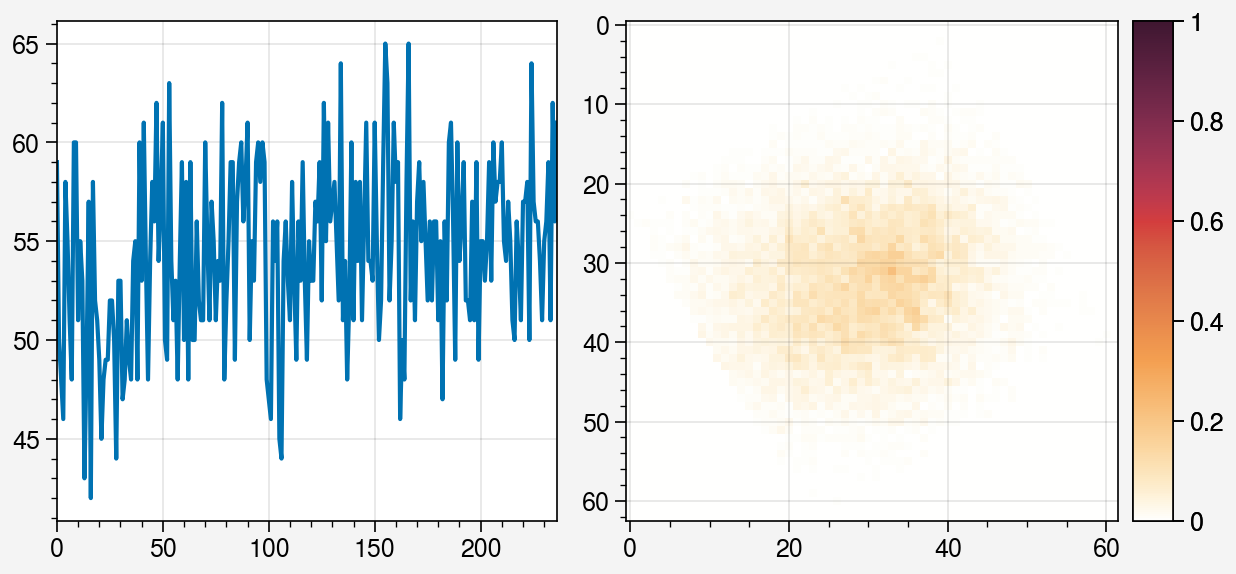

In [74]:
# Tunneling squeezing

dirs = ['./data/2024/02/02', './data/2024/02/02', './data/2024/02/01',
        './data/2024/03/19', './data/2024/03/19', './data/2024/03/15']
scans = [40, 18, 179, 80, 109, 113]

for i in range(len(dirs)):
    print("%s  scan %d" % (dirs[i], scans[i]))
    
    get_scan_stats(dirs[i], scans[i])
    print("\n\n")

./data/2024/03/20  scan 156
N_clip: (83.0, 99.0)  min_fill: 0.019125000000000003
<N>: 91.30103806228374
<N>: 84.77162629757785 max filling: 0.18685121107266436



./data/2024/03/19  scan 138
N_clip: (87.0, 105.0)  min_fill: 0.028499999999999998
<N>: 96.21955403087479
<N>: 84.88507718696398 max filling: 0.307032590051458



./data/2024/03/18  scan 111
N_clip: (96.0, 124.0)  min_fill: 0.0305
<N>: 109.17808219178082
<N>: 98.38527397260275 max filling: 0.3099315068493151





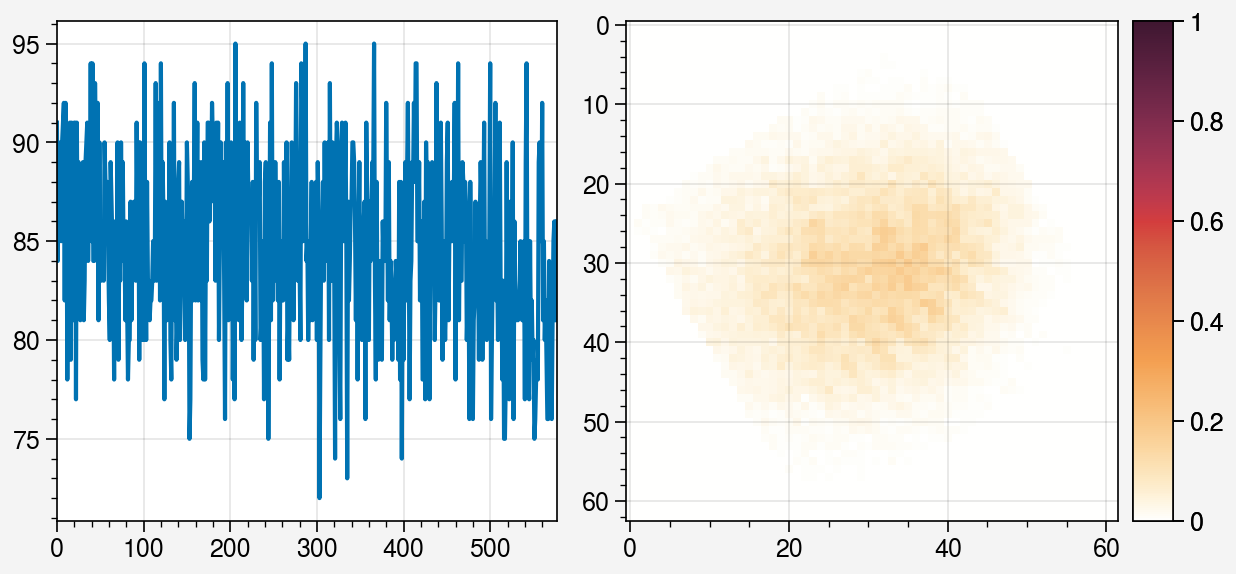

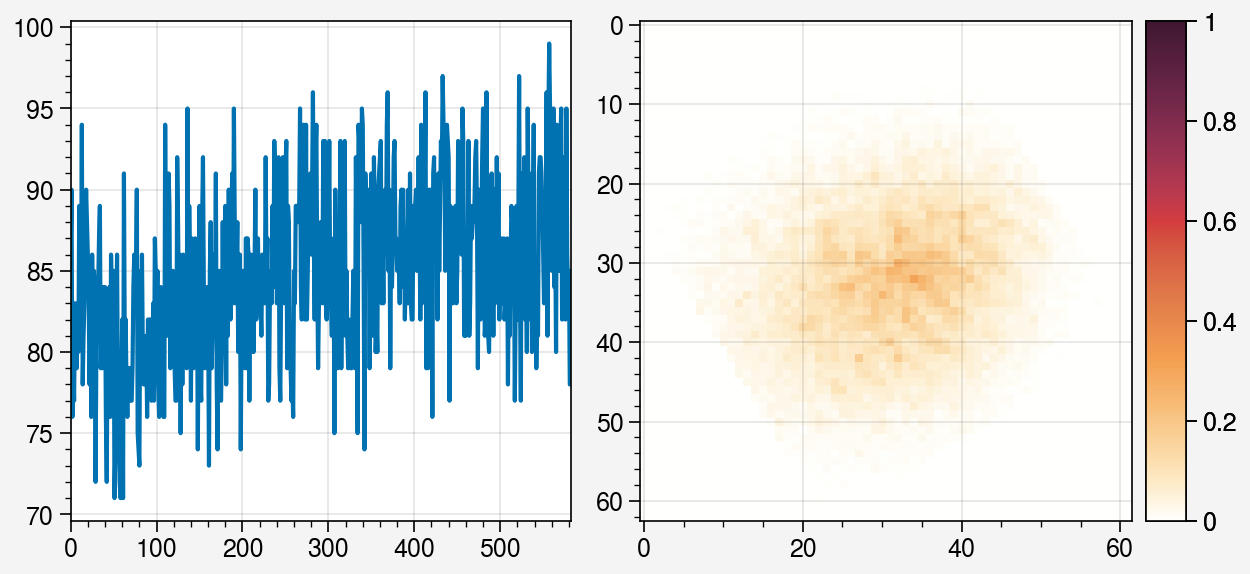

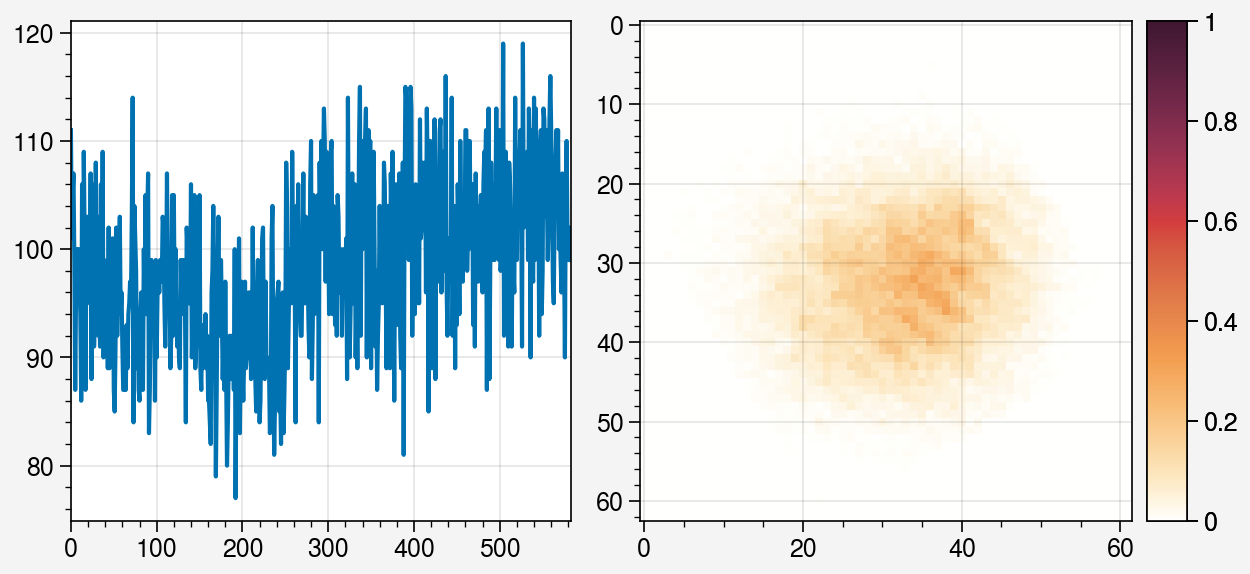

In [75]:
# Correlations

dirs = ['./data/2024/03/20', './data/2024/03/19', './data/2024/03/18']
scans = [156, 138, 111]

for i in range(len(dirs)):
    print("%s  scan %d" % (dirs[i], scans[i]))
    
    get_scan_stats(dirs[i], scans[i])
    print("\n\n")

In [ ]:
# high squeezing
get_scan_stats('./data/2024/02/10', [68, 69], ratio_clip=(-0.95, 0.95), 
                 maxr=60, maxc=60, shot_clip=(0, 2100))

# high squeezing contrast
get_scan_stats('./data/2024/03/17', 58, shot_clip=(0, 180))

In [ ]:
# long T2
print(get_scan_stats('./data/2023/12/05', 34))

In [ ]:
dirs = ['./data/2024/02/02', './data/2024/02/02', './data/2024/02/01']
scans = [40, 18, 179]

for i in range(len(dirs)):
    print("%s  scan %d" % (dirs[i], scans[i]))
    
    get_scan_stats(dirs[i], scans[i])
    print("\n\n")

(3, 69, 68, 66)
N_clip: (1144.375, 1227.25)  min_fill: 0.1
<N>: 1186.5833333333333
<N>: 1167.1875 max filling: 1.0416666666666667


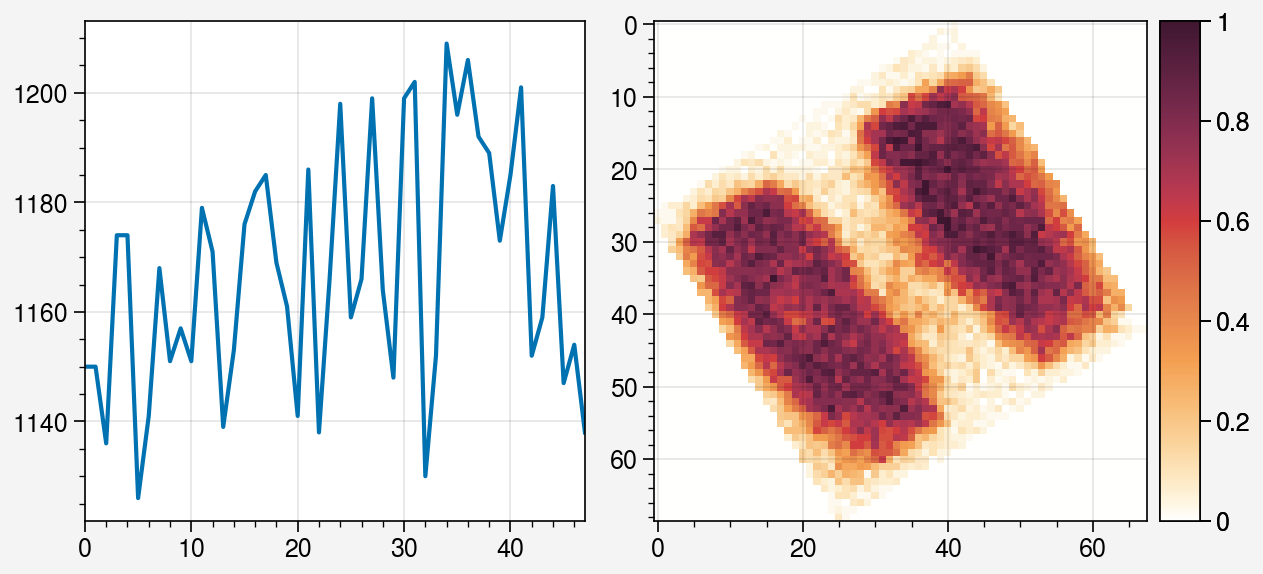

In [69]:
# magnetically insensitive
get_scan_stats('./data/2023/12/04', 37, sum_spindown=True)

(3, 69, 69, 2471)
N_clip: (1046.0, 1173.0)  min_fill: 0.09566976932416027
<N>: 1118.3389923329682
<N>: 1094.7508214676889 max filling: 0.9698795180722891


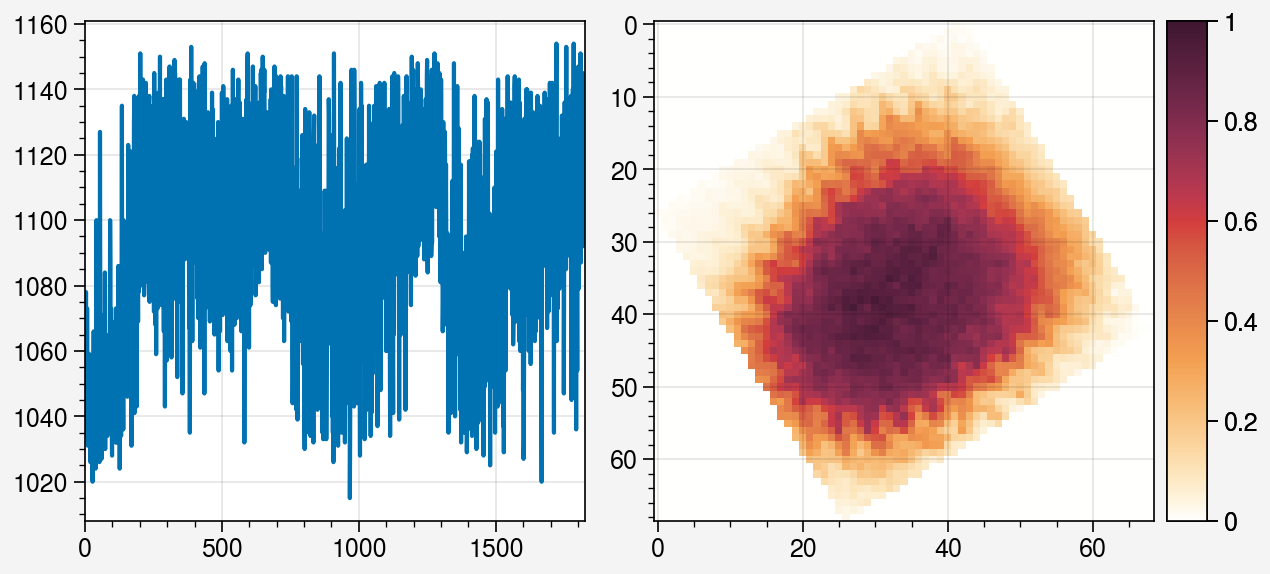

In [70]:
# Mean field interaction

# 1000 ms
get_scan_stats('./data/2023/12/05', 77, sum_spindown=True)

(3, 69, 68, 155)
N_clip: (1052.0, 1126.125)  min_fill: 0.09161290322580645
<N>: 1089.1681415929204
<N>: 1067.5575221238937 max filling: 0.9557522123893806


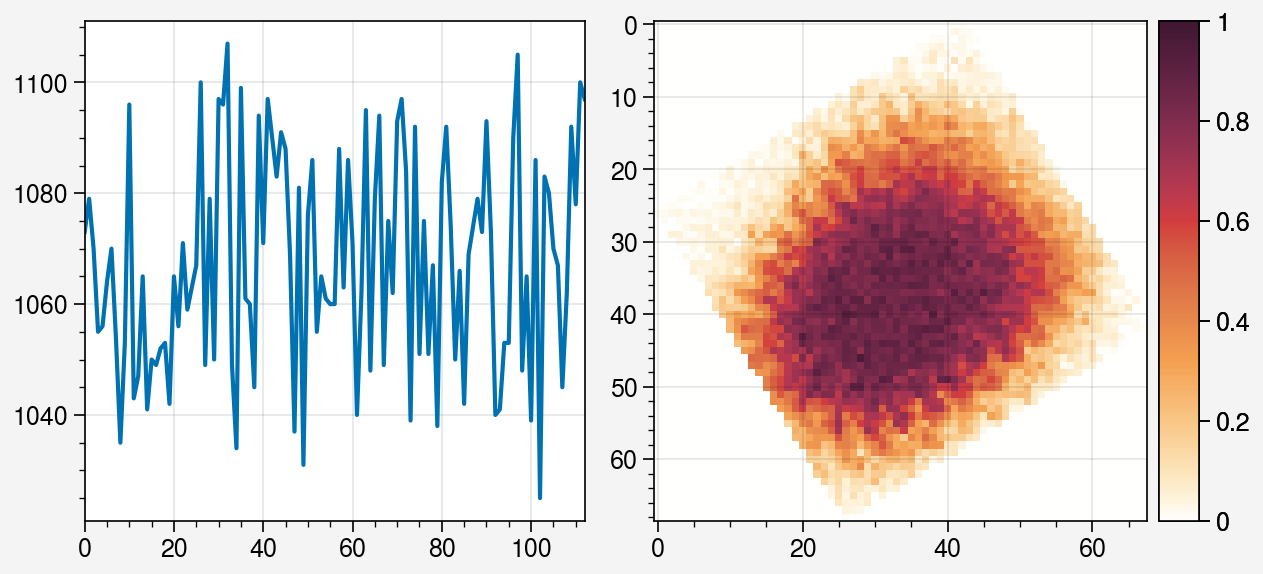

In [71]:
# Rabi
get_scan_stats('./data/2023/12/06', 27, sum_spindown=True)